In [1]:
import numpy as np
import cupy as cp
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
gen = cp.random.default_rng()

%matplotlib inline

import os
# os.environ["CUPY_ACCELERATORS"] = "cutensor,cub,python"
# os.environ['CUPY_CUDA_PER_THREAD_DEFAULT_STREAM'] = "0"

In [2]:
# def gillespie(n_ratio, N, M = 1):
#     runs = []
#     for _ in range(M):
#         Ns = [int(n_ratio * N / (n_ratio + 1))]
#         Ns.append(N-Ns[0])
#         g = [1, -1]
#         cumulative = [0]
#         counts = np.array([0, 0]) 
#         r2 = gen.uniform(size = N)
#         for j in range(N):
#             a = [(Ns[i] - counts[i]) / (N - j) for i in range(2)]
#             mu = 0
#             n = r2[j] - a[mu]
#             mu = int(n > 0)

#             cumulative.append(cumulative[-1] + g[mu])
#             counts[mu] += 1
#     runs.append(np.array(cumulative))
#     return runs
# x = gillespie(1,100, 30)
# print(x)

In [3]:
def gillespie(n_ratio, N, M = 1):
    # gen = np.random.default_rng()
    Ns = [[int(n_ratio * N / (n_ratio + 1))]]
    Ns[0].append(N-Ns[0][0])
    Ns = cp.array(Ns).T
    g = cp.array([1, -1])
    cumulative = cp.zeros([N+1,M])
    counts = cp.zeros([2,M])
    r2 = gen.uniform(size = [N+1,M])
    rang = cp.arange(M)
    for j in range(N):
        a = (Ns - counts) / (N-j)
        n = r2[j] - a[0]
        mu = (n > 0) + 0
        cumulative[j+1] = cumulative[j] + g[mu]
        counts[mu, rang] += 1
    return cumulative.T

In [4]:
def empirical_test(n_ratio, N, theta,j, M):
    runs = gillespie(n_ratio, N, M)
    successes = runs[:,j] == theta
    return cp.sum(successes) / M

In [5]:
# testing hypergeometric distribution
N = 100
n_ratio = 1
Np = int(N * n_ratio / (n_ratio + 1))
j = 98
theta = (2 * Np - N) * j / N
print(f'target theta = {theta}')


suc = (theta + j) / 2
if suc % 1 == 0:
    true = sp.special.comb(Np, suc) * sp.special.comb(N - Np, j - suc) / sp.special.comb(N, j)
    print(f'True probability that theta({j}) = {theta} is {np.round(true,4)}')
else:
    true = 0
    print("impossible")

test = empirical_test(n_ratio, N, theta,j, 1000000)
print(f'Sample estimate: {np.round(test,4)}')

target theta = 0.0
True probability that theta(98) = 0.0 is 0.5051
Sample estimate: 0.5043


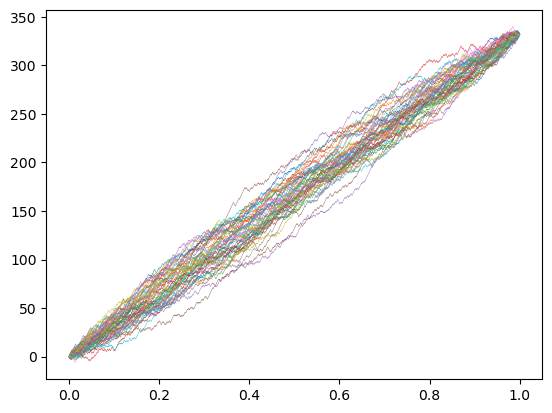

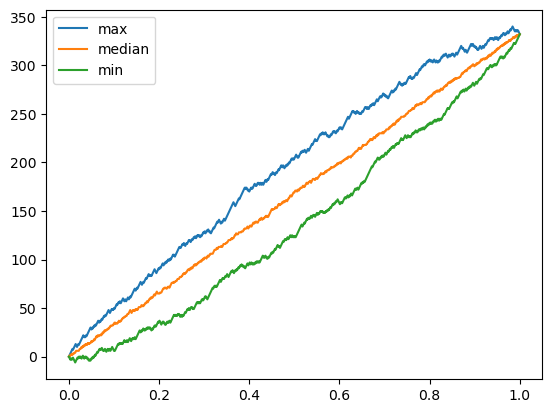

In [6]:
N = 1000
n_ratio = 2
M = 50
t = np.linspace(0, 1, N + 1)
x = gillespie(n_ratio, N, M).get()

plt.plot(t, x.T,linewidth=0.3,alpha=1)
plt.show()
max = np.max(x,axis=0)
min = np.min(x,axis=0)
med = np.median(x,axis=0)
plt.plot(t, max,label="max")
plt.plot(t, med,label="median")
plt.plot(t, min,label="min")
plt.legend()
plt.show()

In [7]:
# find empirical distribution of intersection locations (with null path) and number of intersections
def intersection_density(n_ratio, N, M): 
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])
    x0 = cp.arange(N+1) * (Ns[0] - Ns[1]) / N
    intersections = cp.zeros([M,N+1])
    x = gillespie(n_ratio, N, M)
    y = x - x0
    # intersections[:,1:] = y[:,1:] == 0
    intersections = y == 0

    inter_number = cp.sum(intersections, axis = 1)
    inters = cp.argwhere(intersections == 1).T[1] / N

    return inters.get(), inter_number.get()

In [8]:
runs = []
del runs
cp._default_memory_pool.free_all_blocks()

n_ratios = [i for i in range(1,6)]
N1 = [i * 300 for i in range(1,4)]
M = 200000
runs = []
for N in N1:
    runs.append([])
    for n_ratio in n_ratios:
        runs[-1].append(intersection_density(n_ratio, N, M))

In [ ]:
def f(N): 
    return 1 - 1 / (N-1)
print(1-f(300)) # probability of no intersection with null path


0.0033444816053511683


0.003405


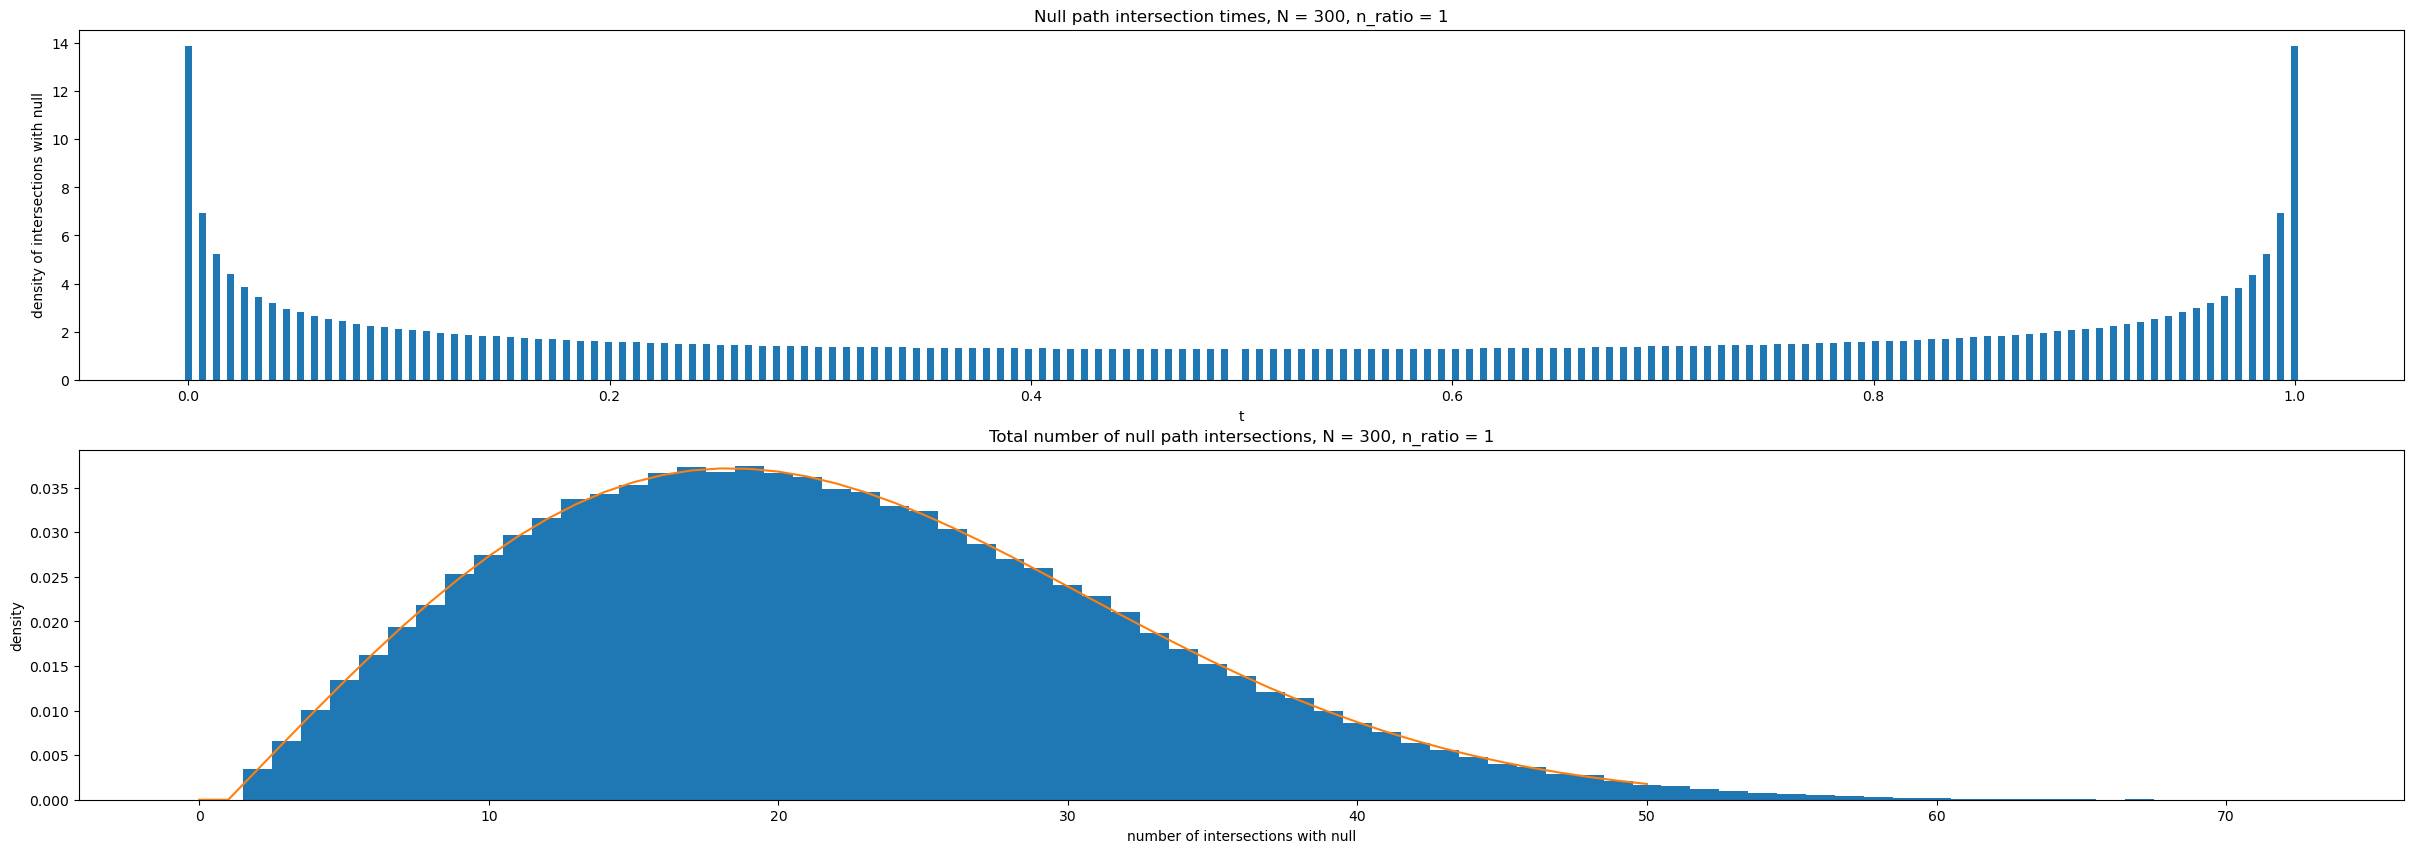

0.006225


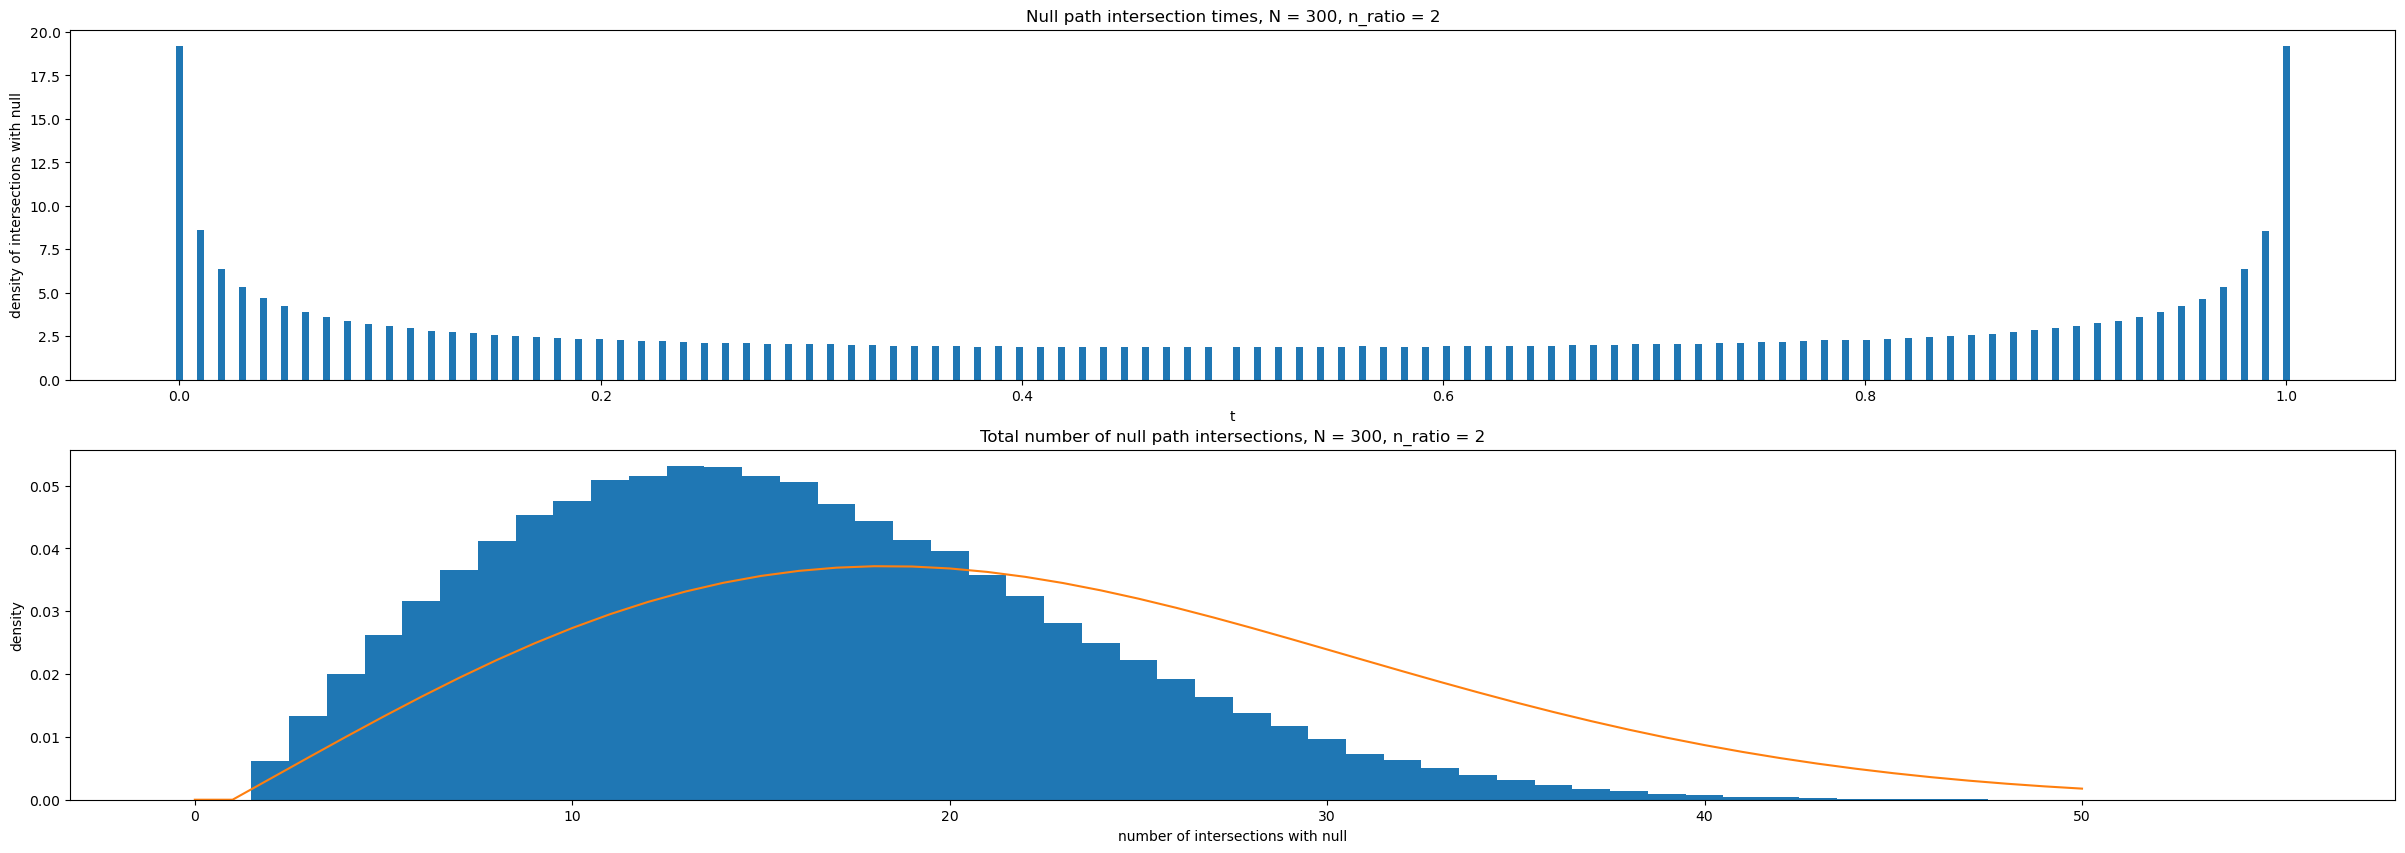

0.009815


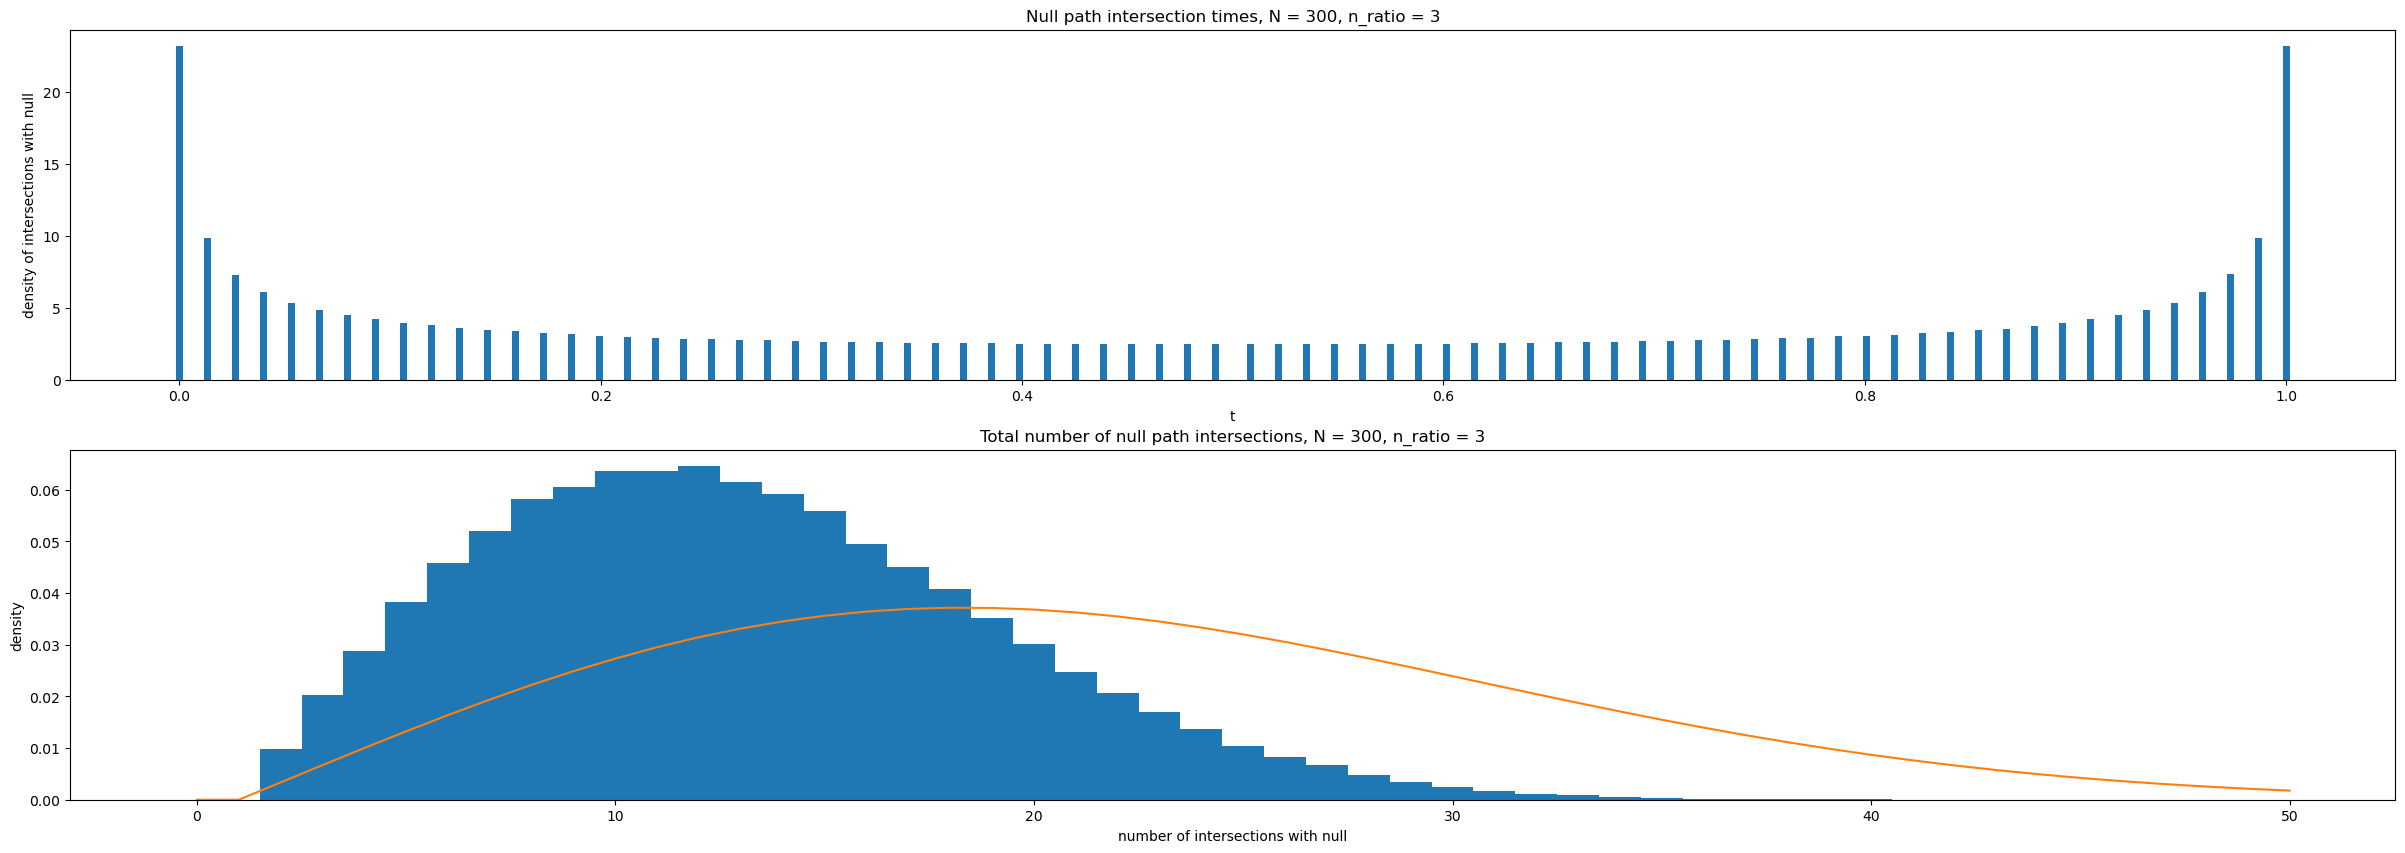

0.01336


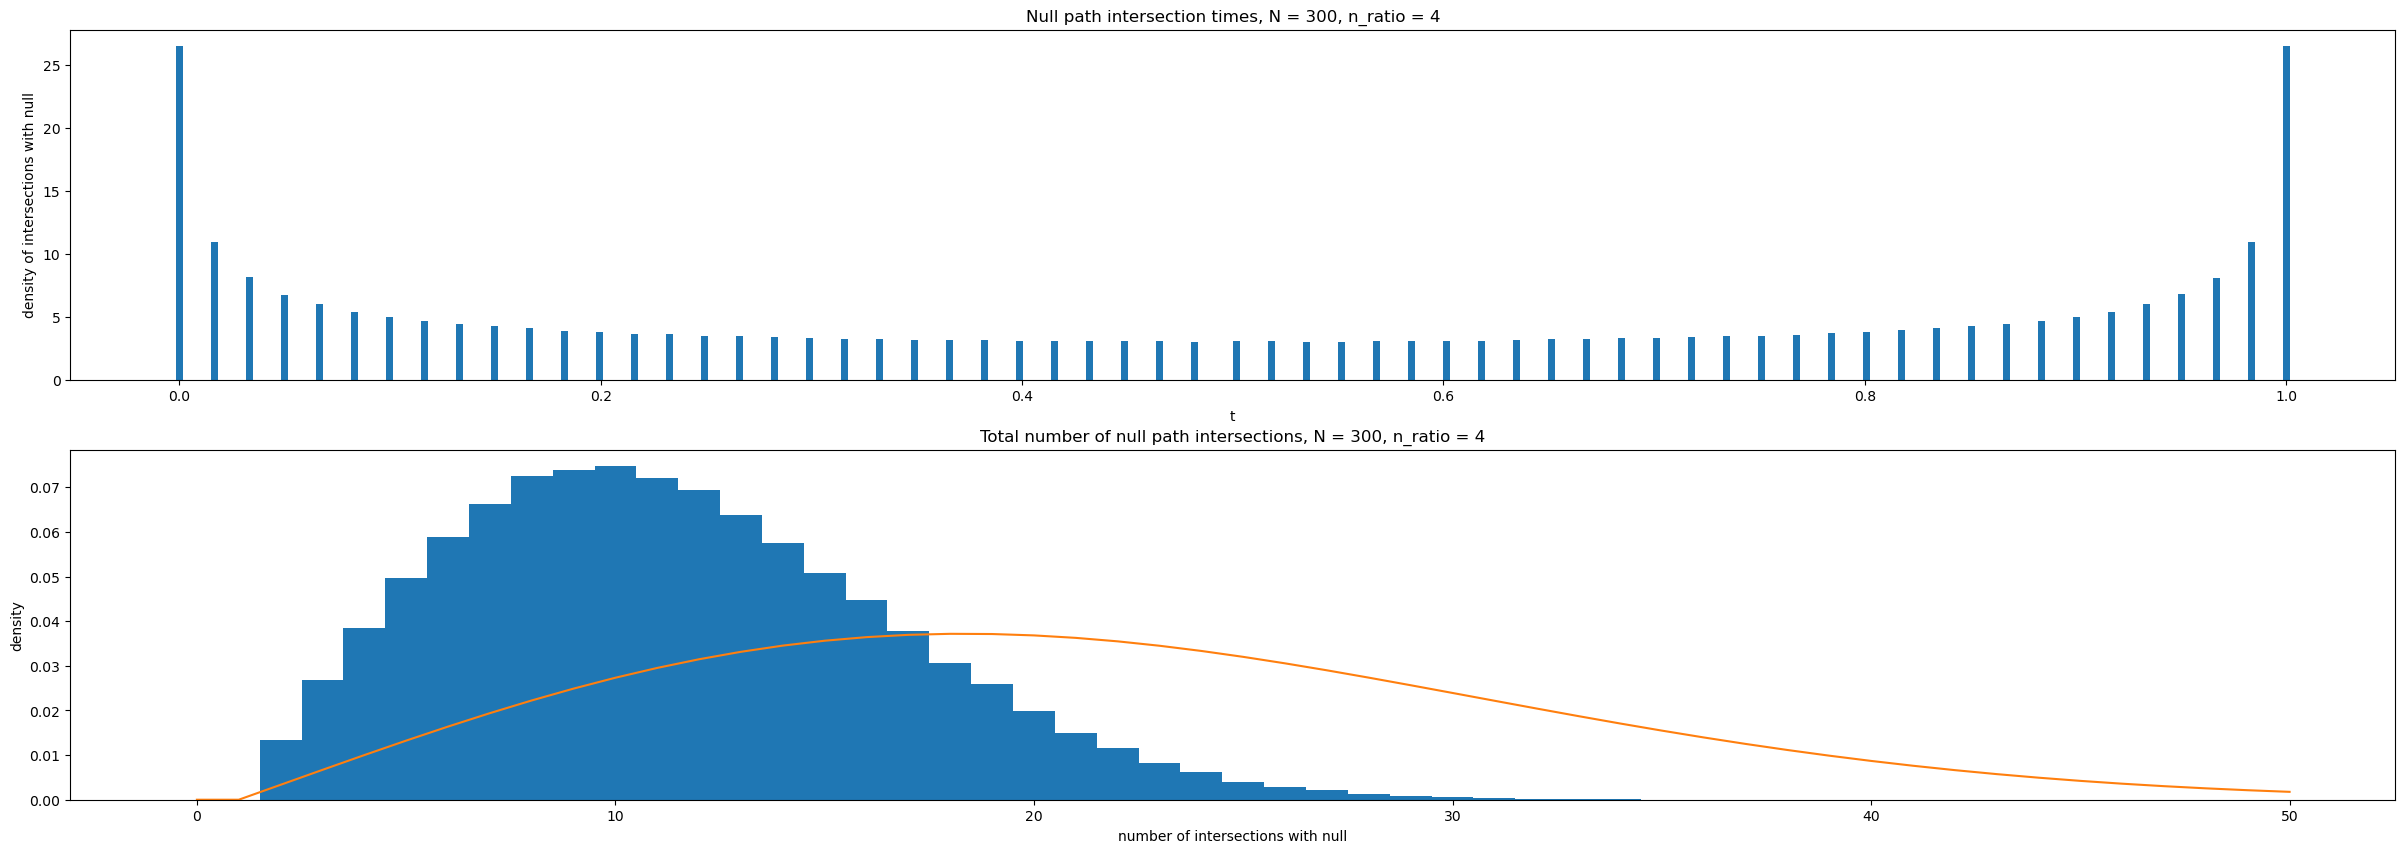

0.016735


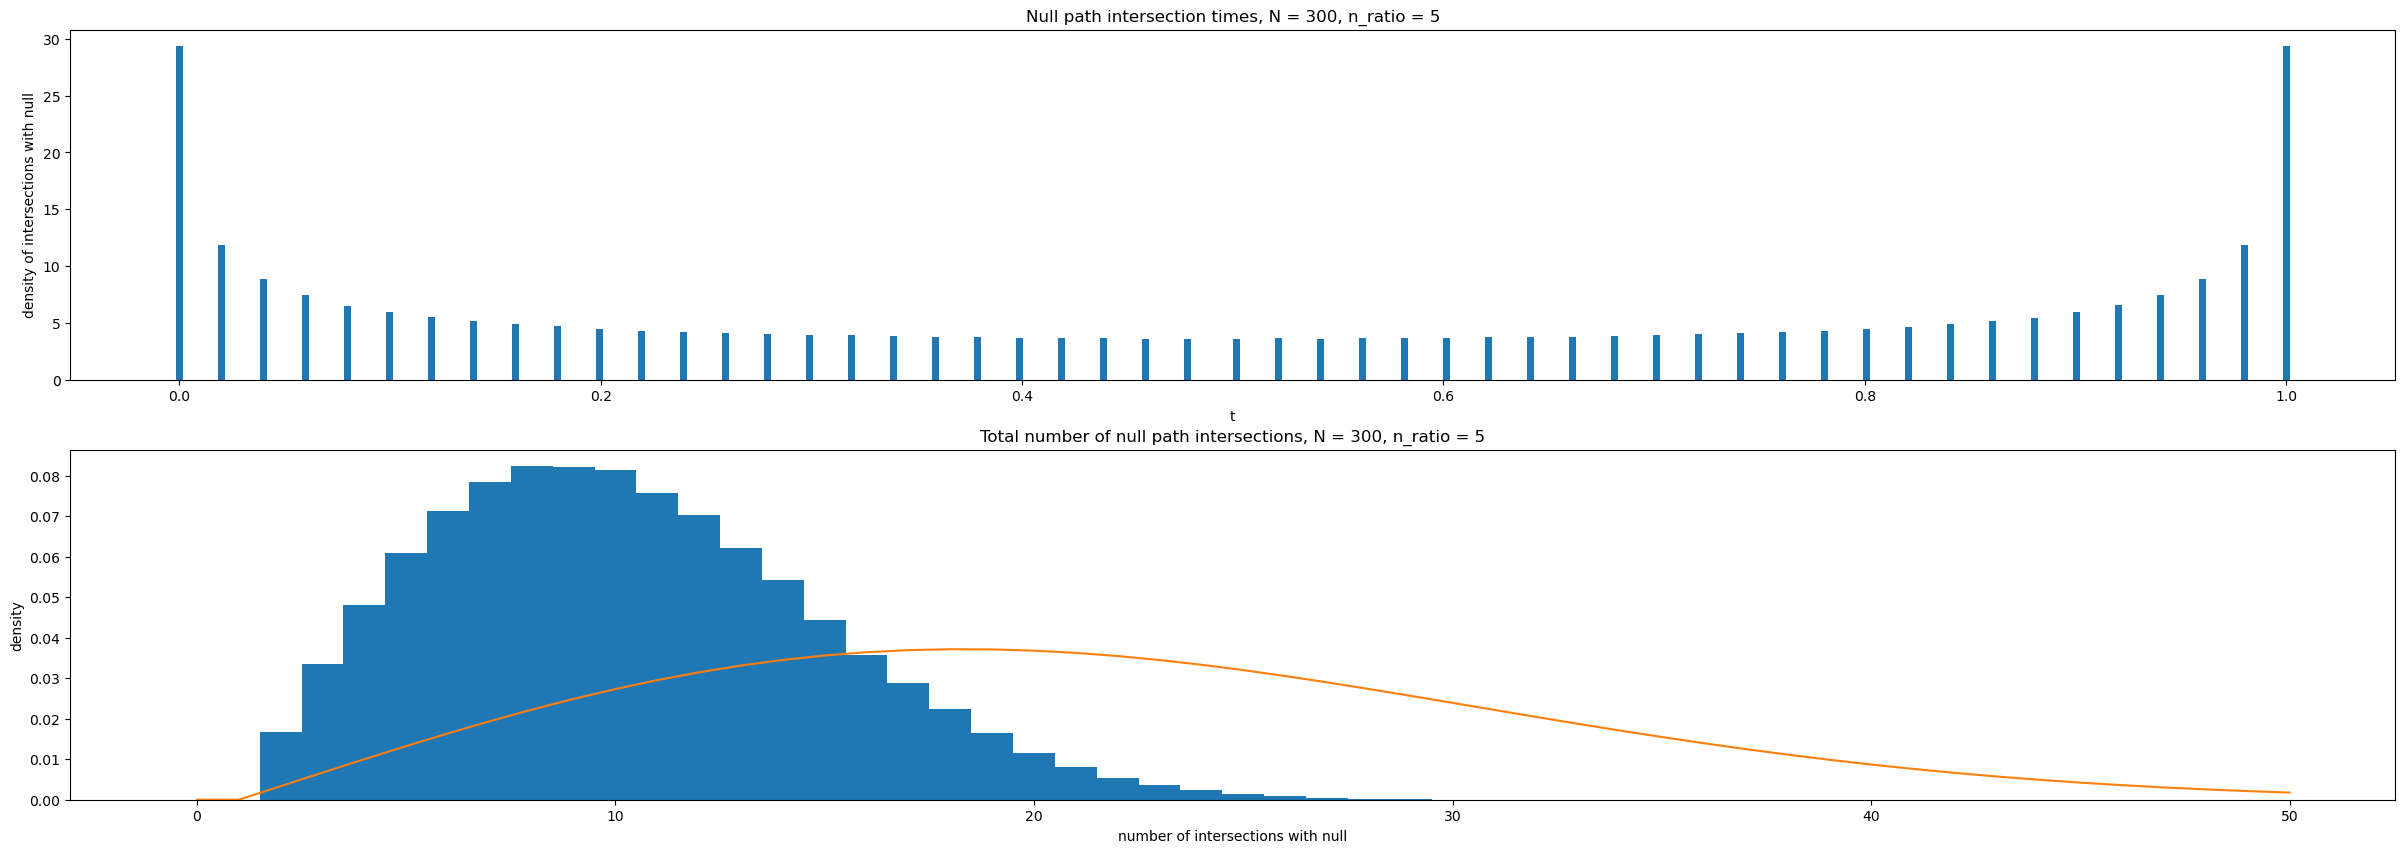

0.00154


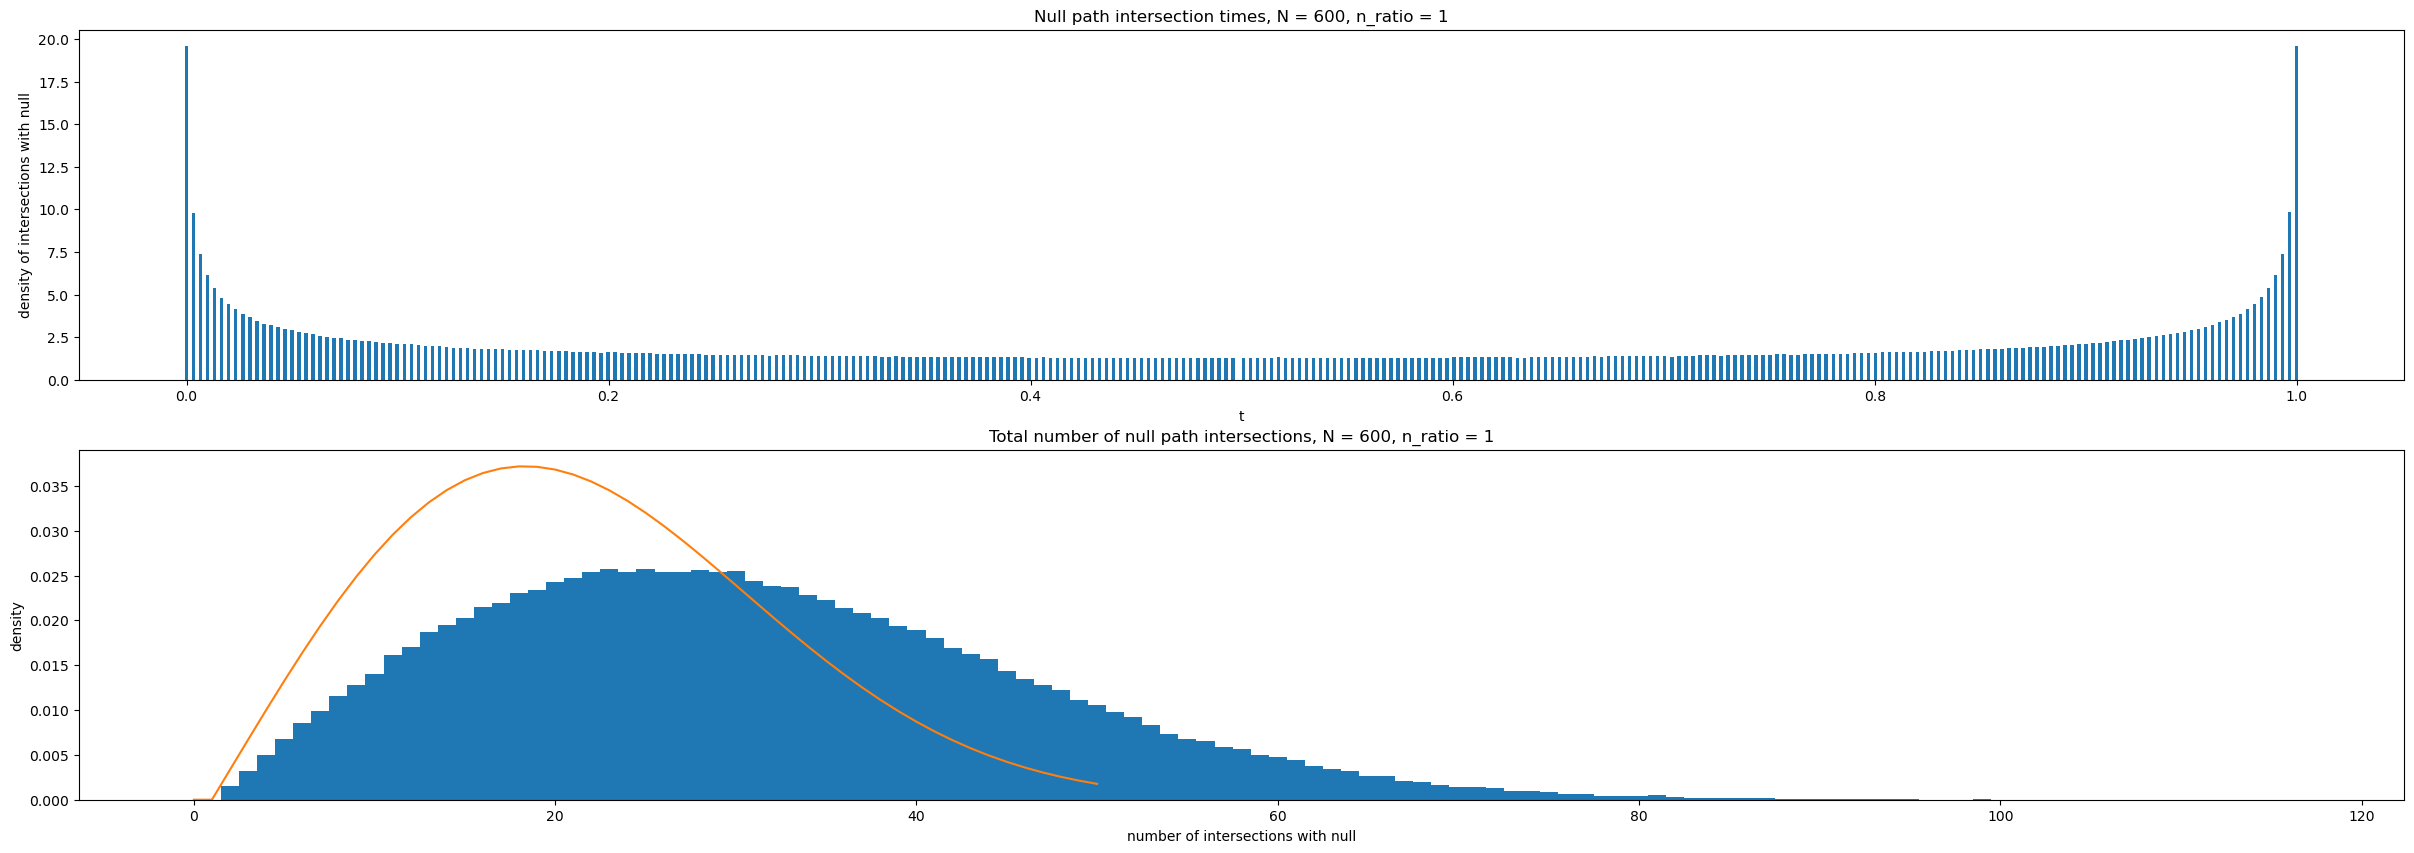

0.00355


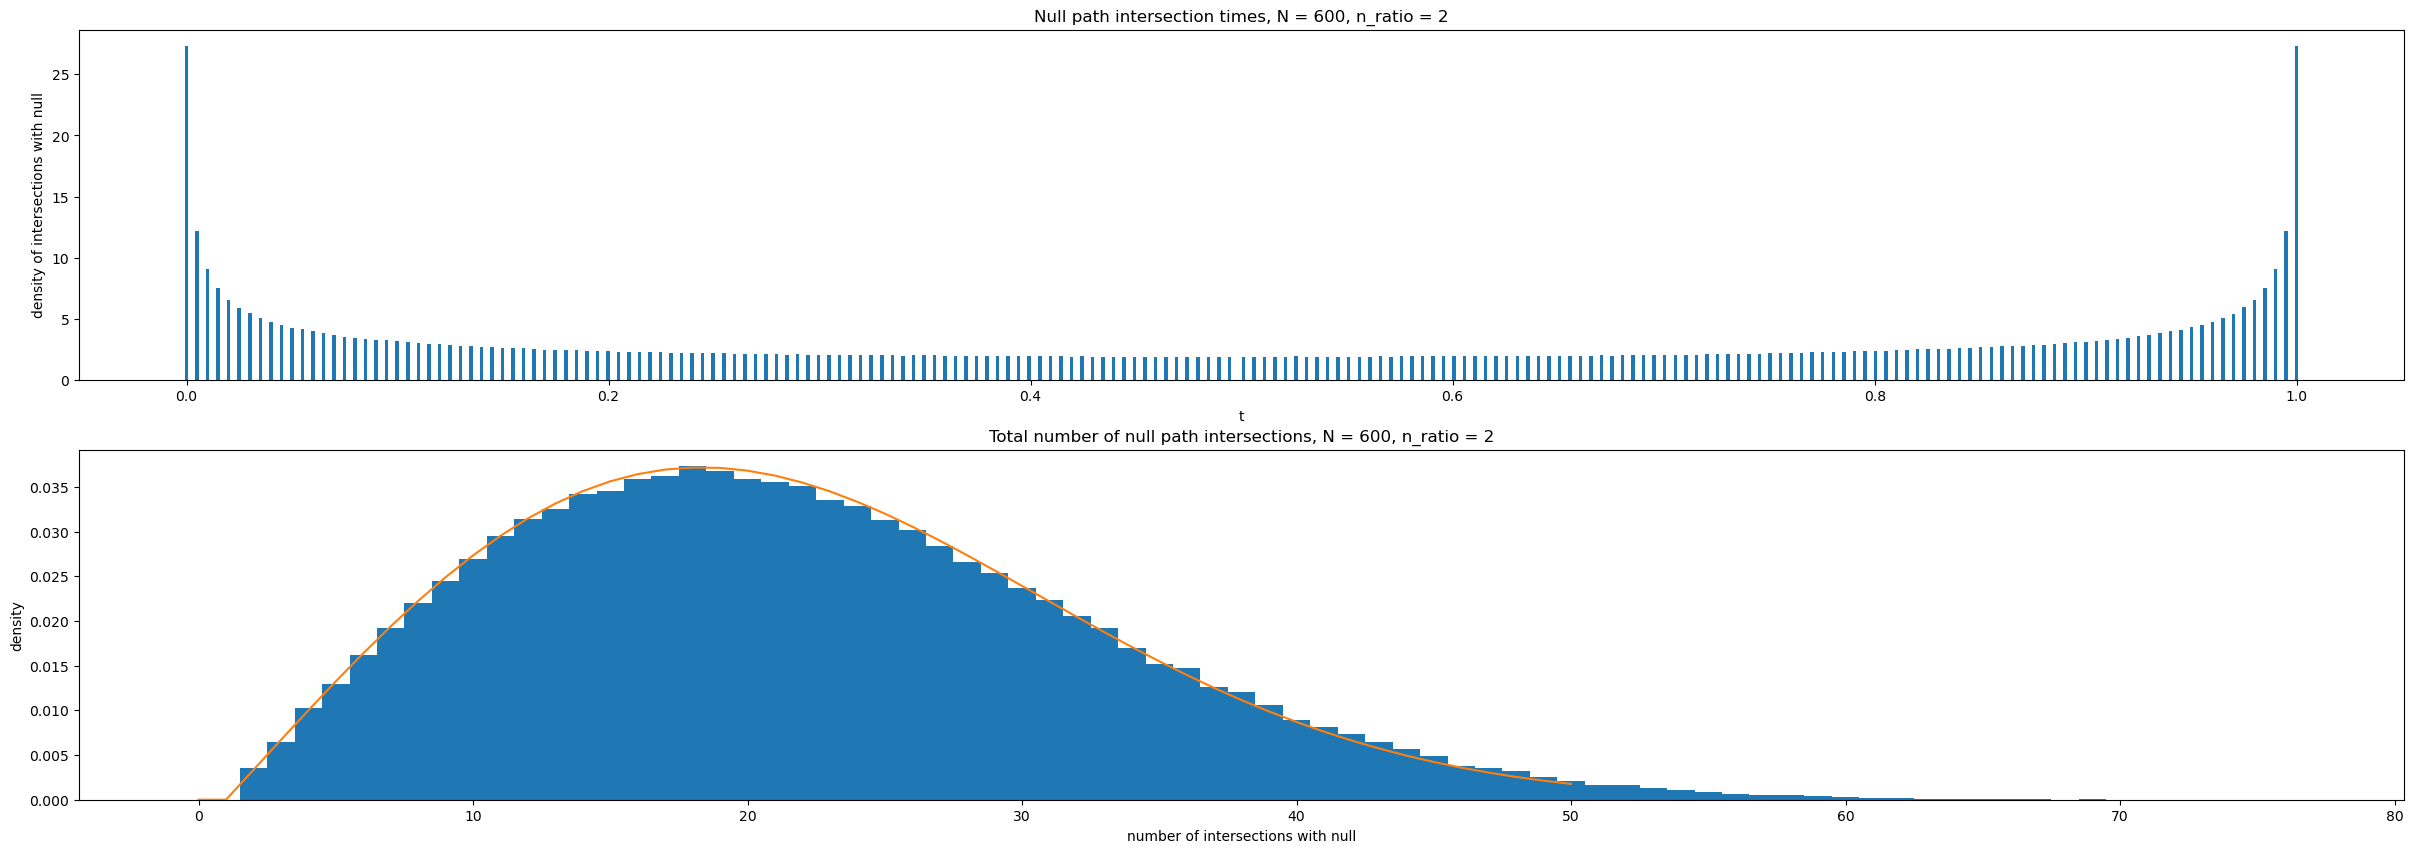

0.00483


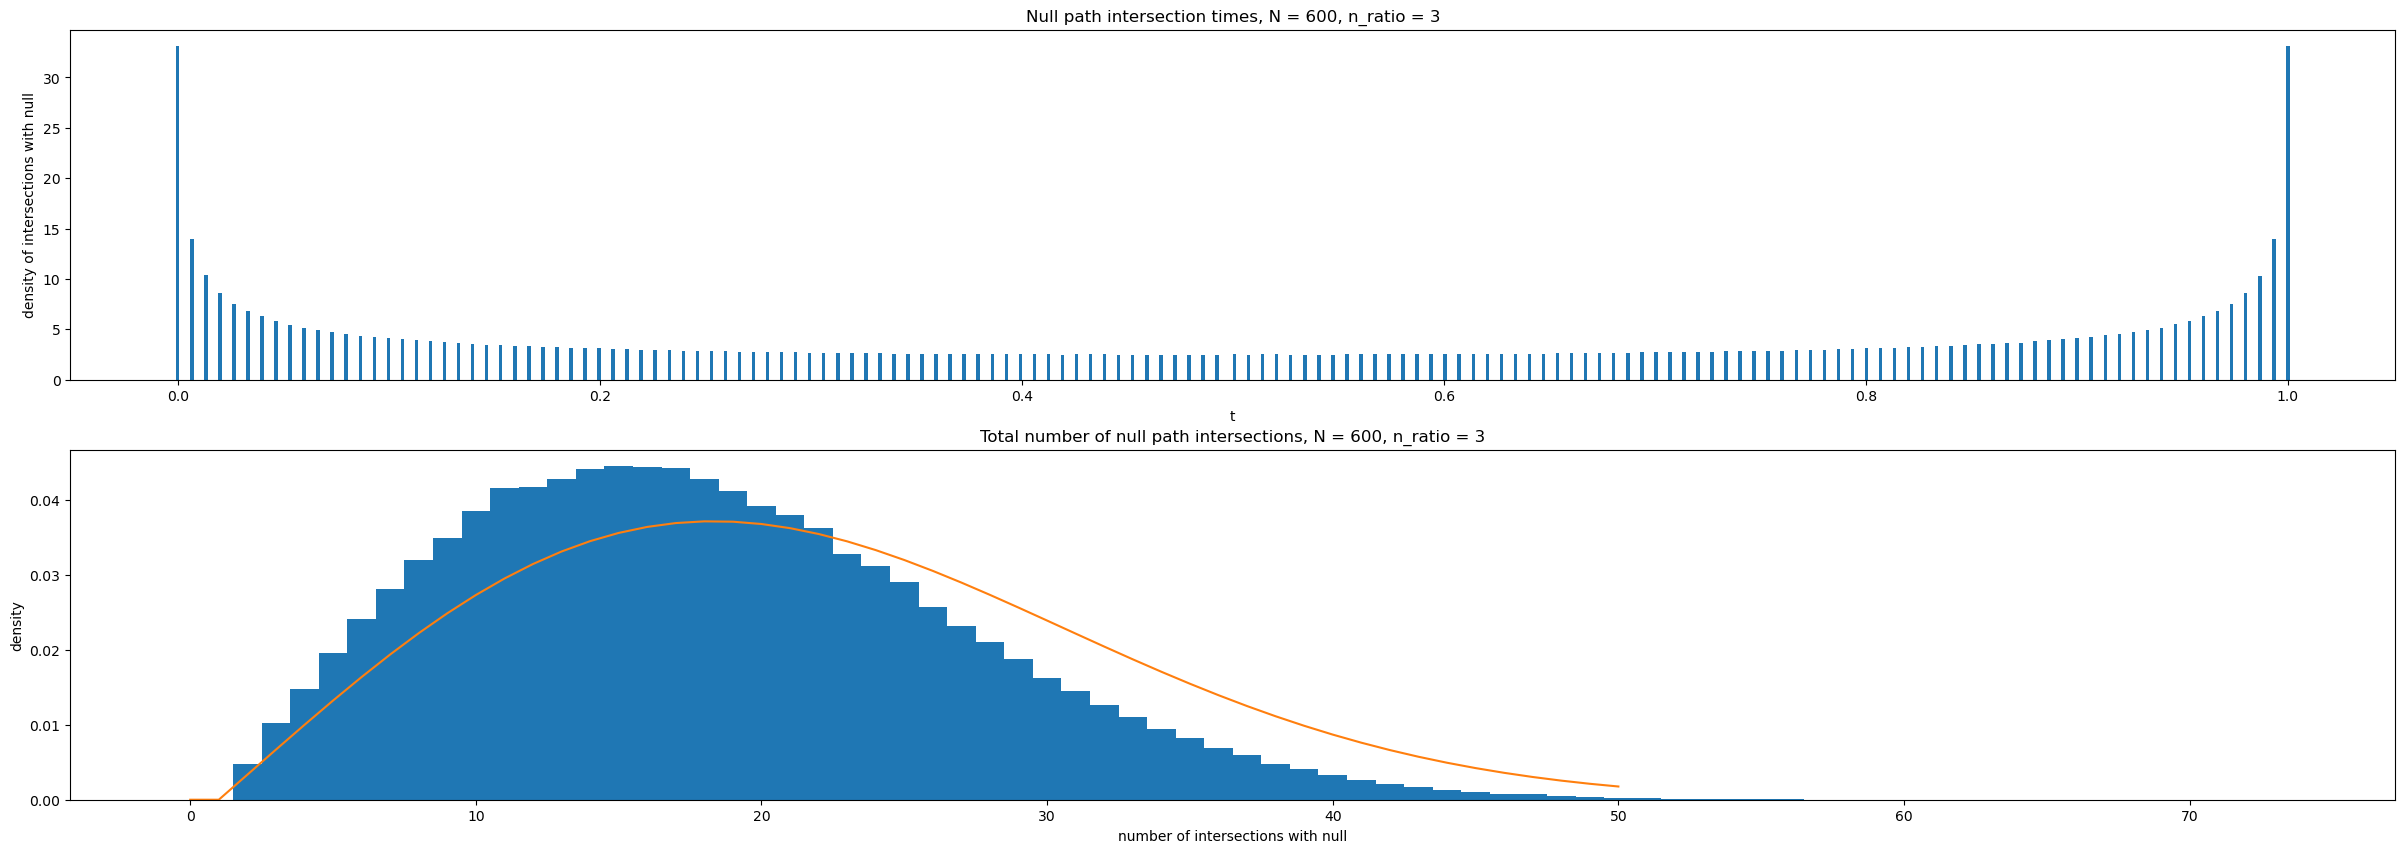

0.006395


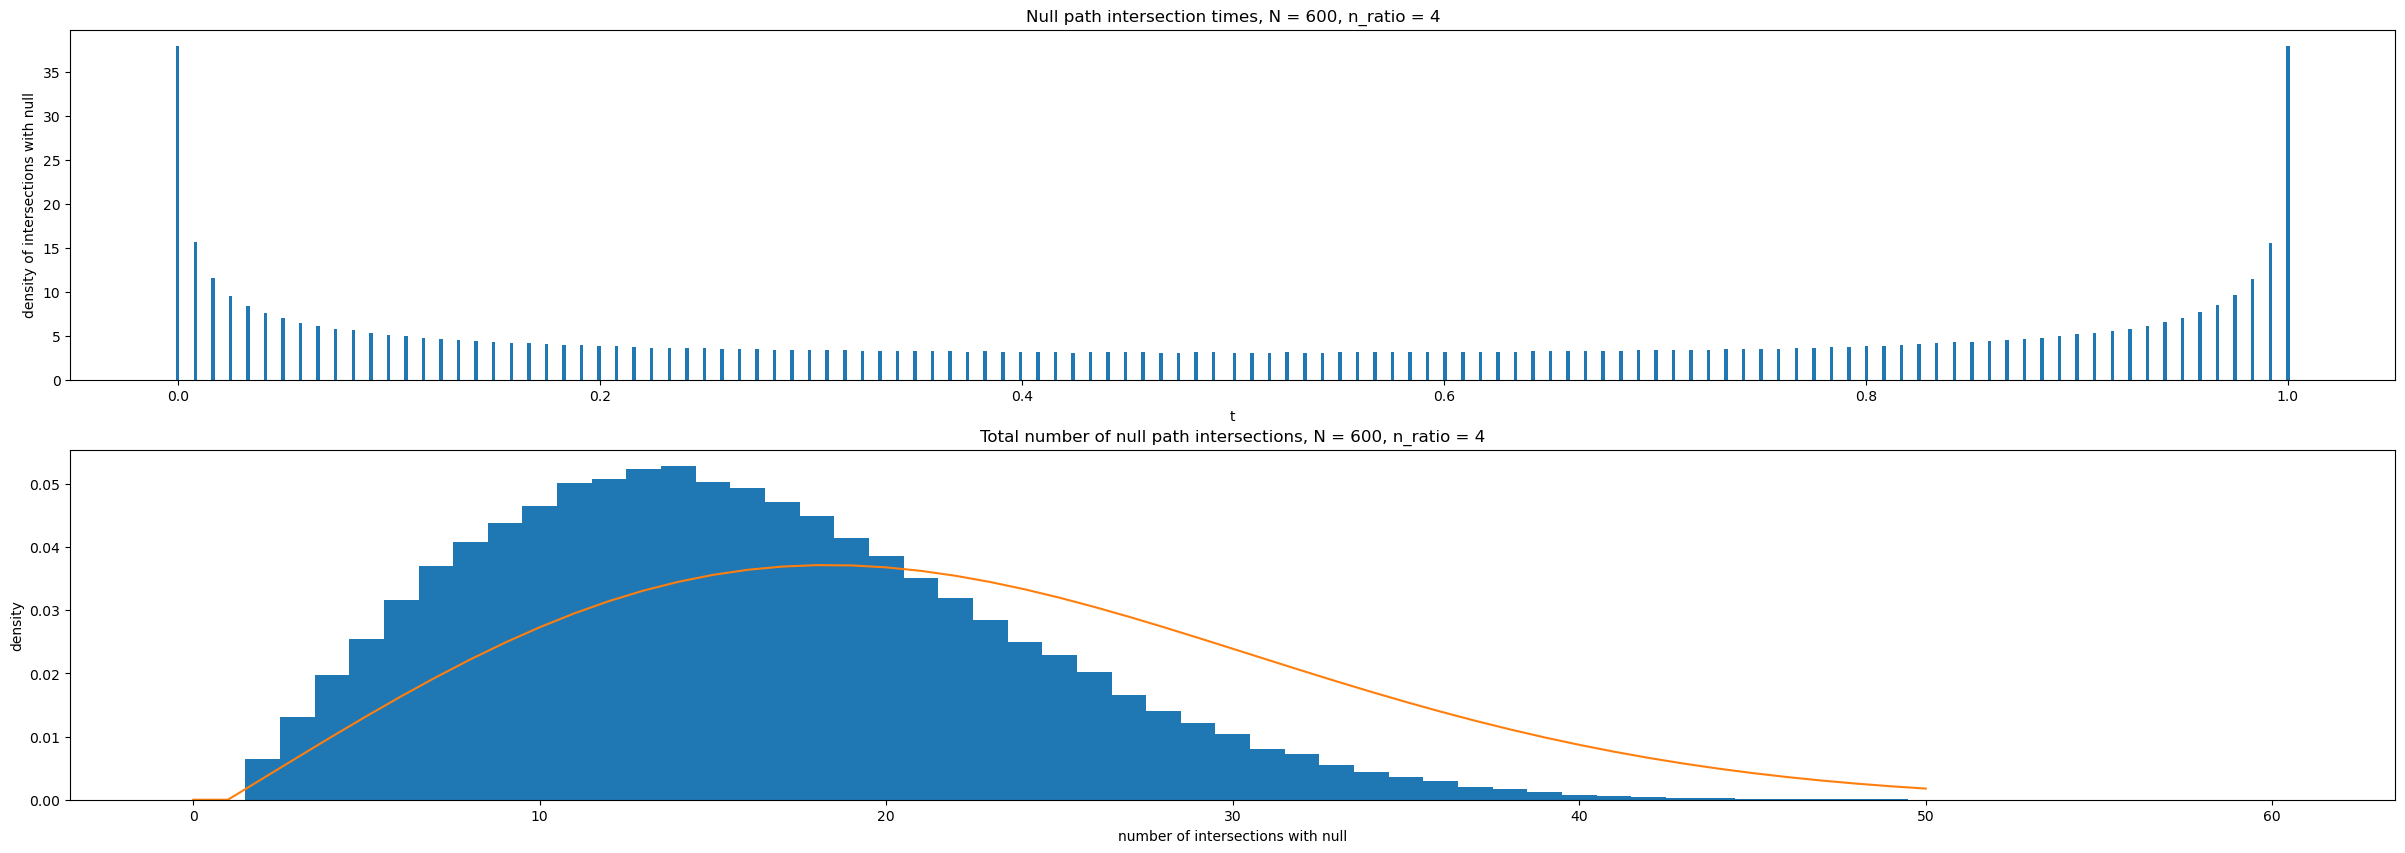

0.008385


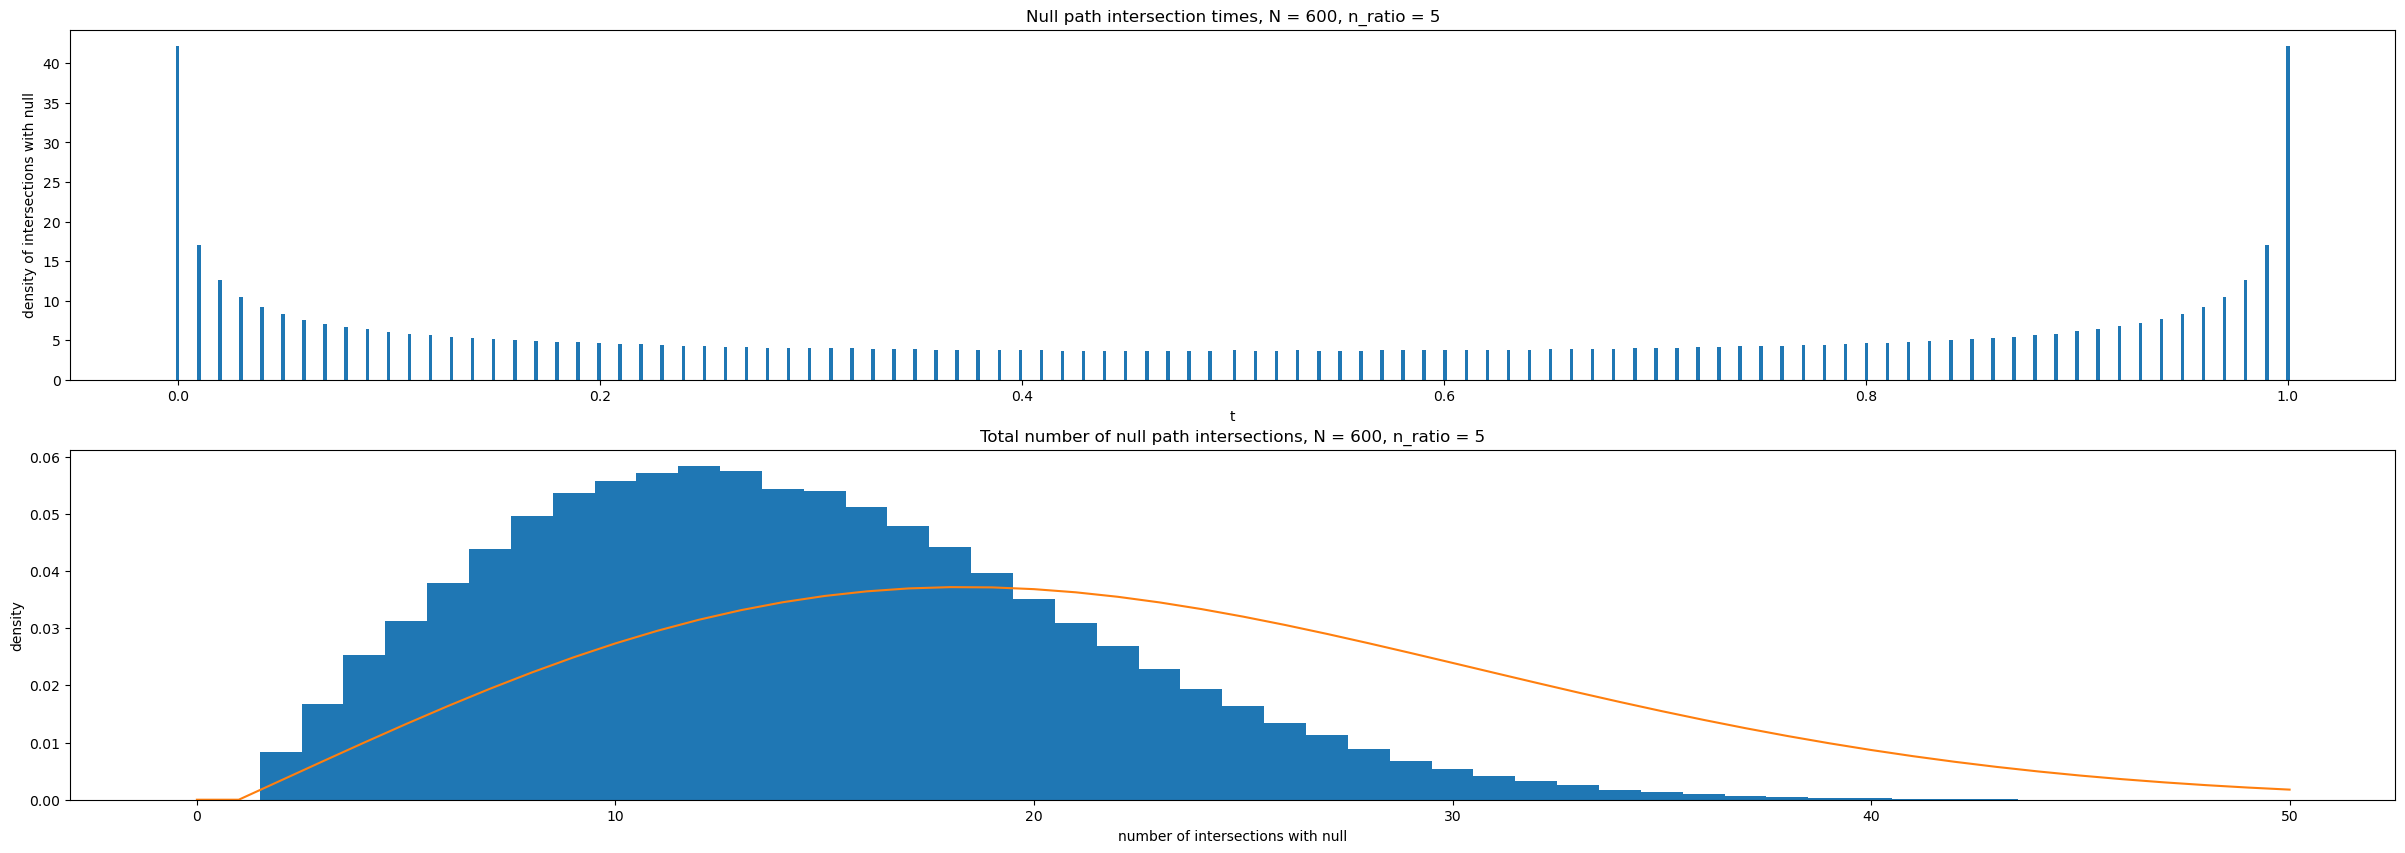

0.001205


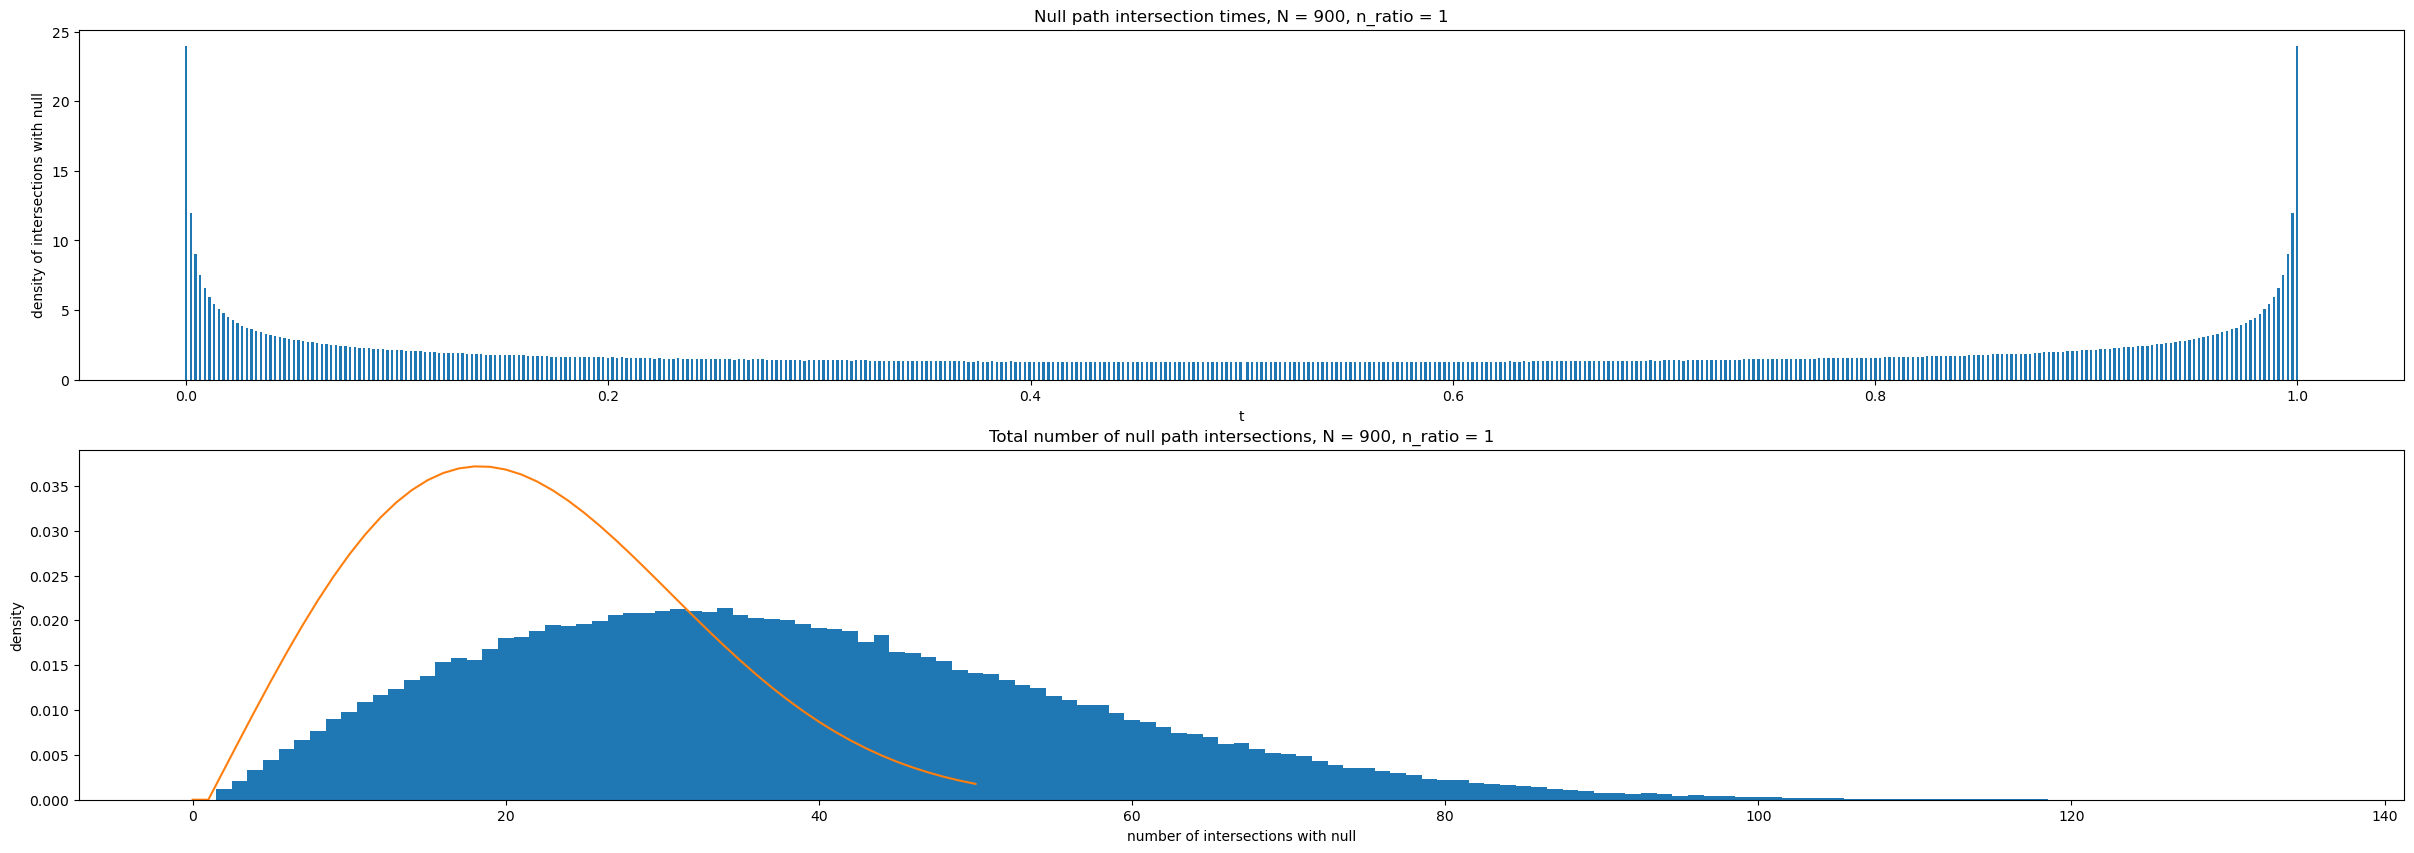

0.00235


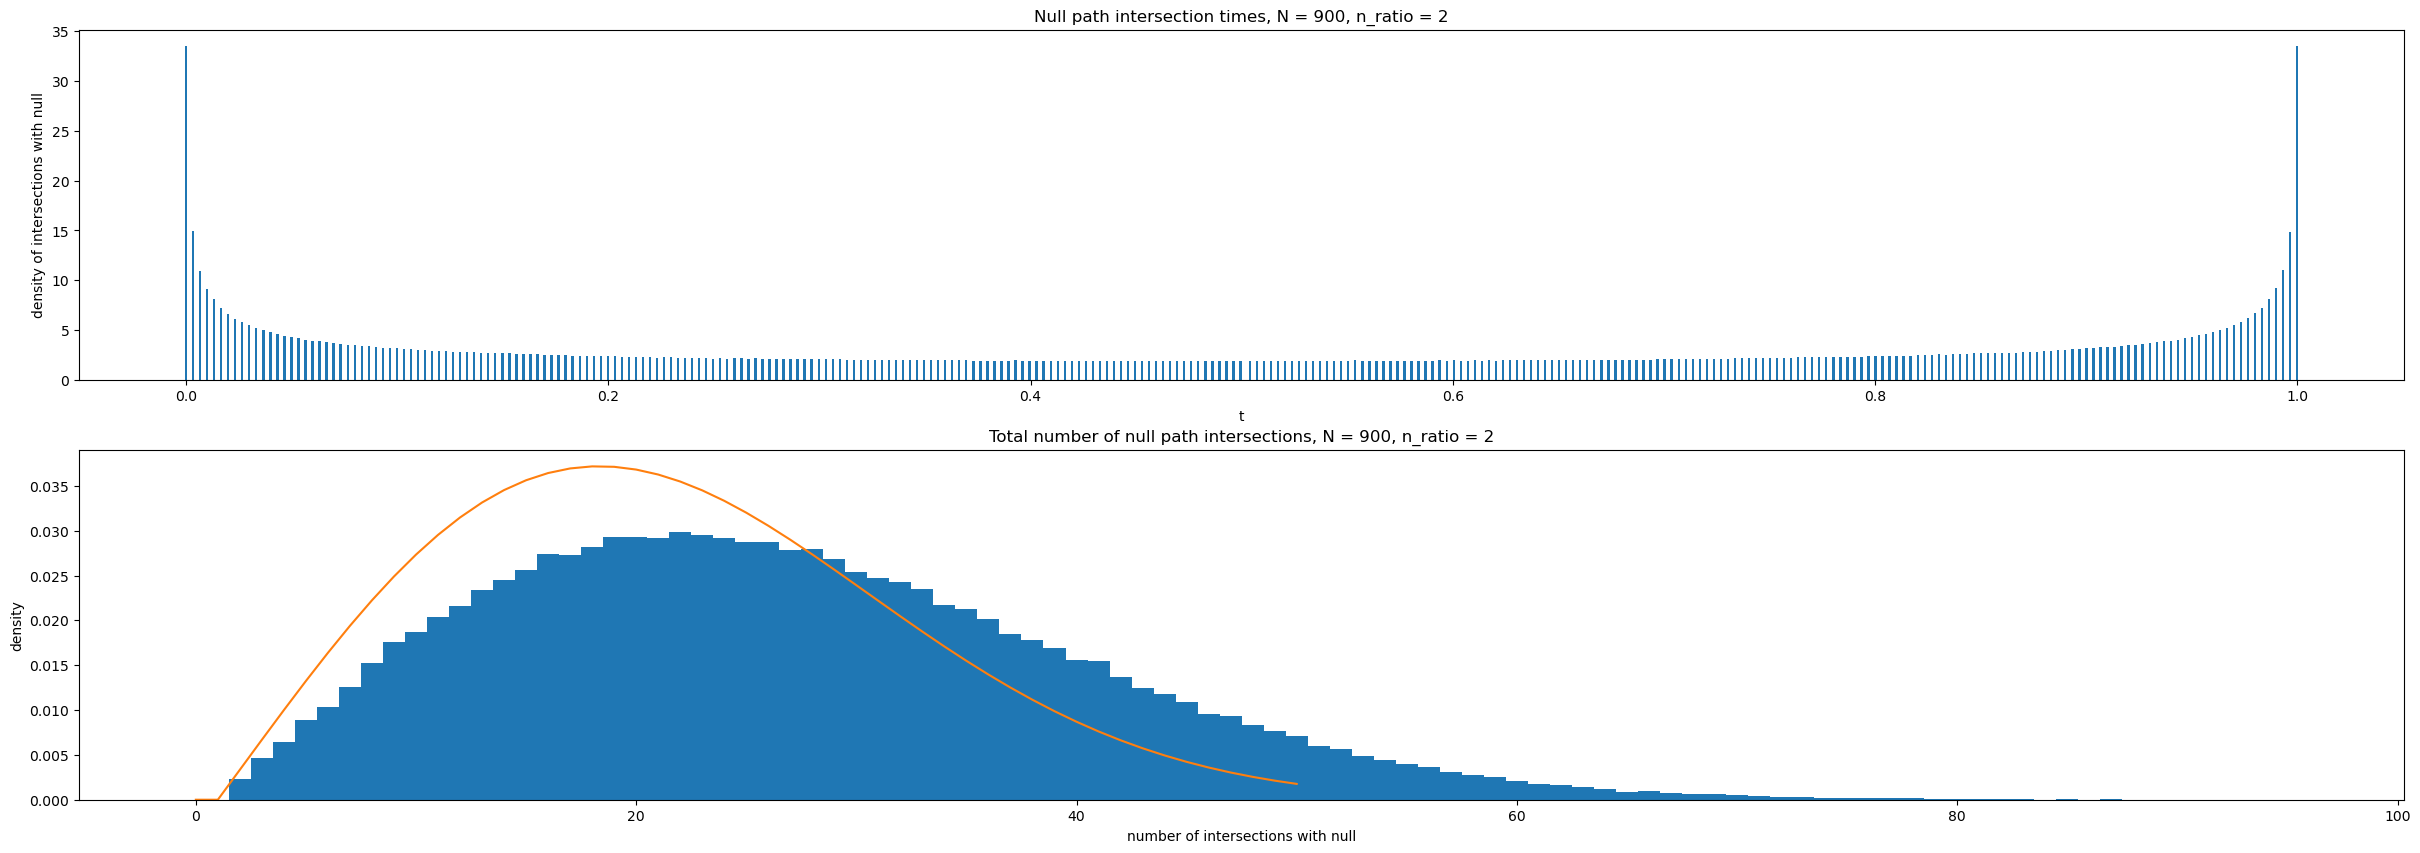

0.00343


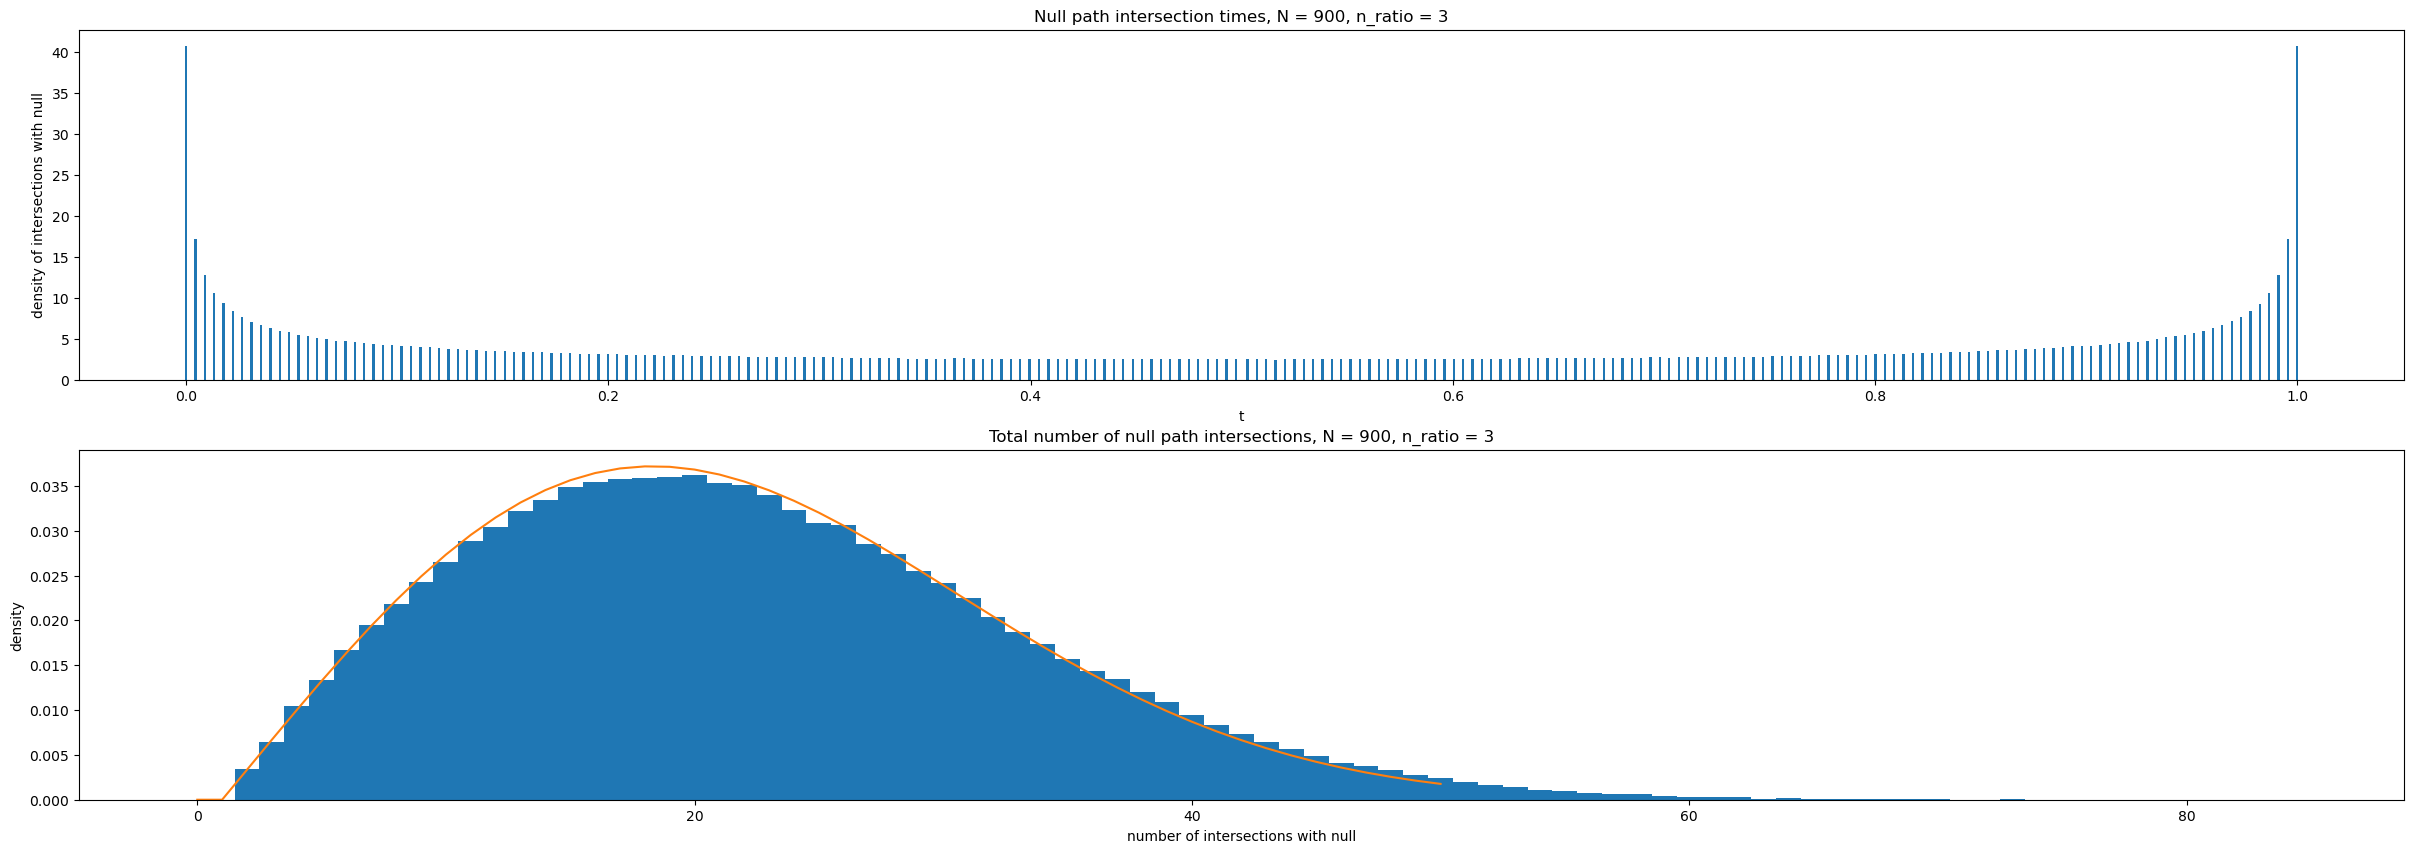

0.00463


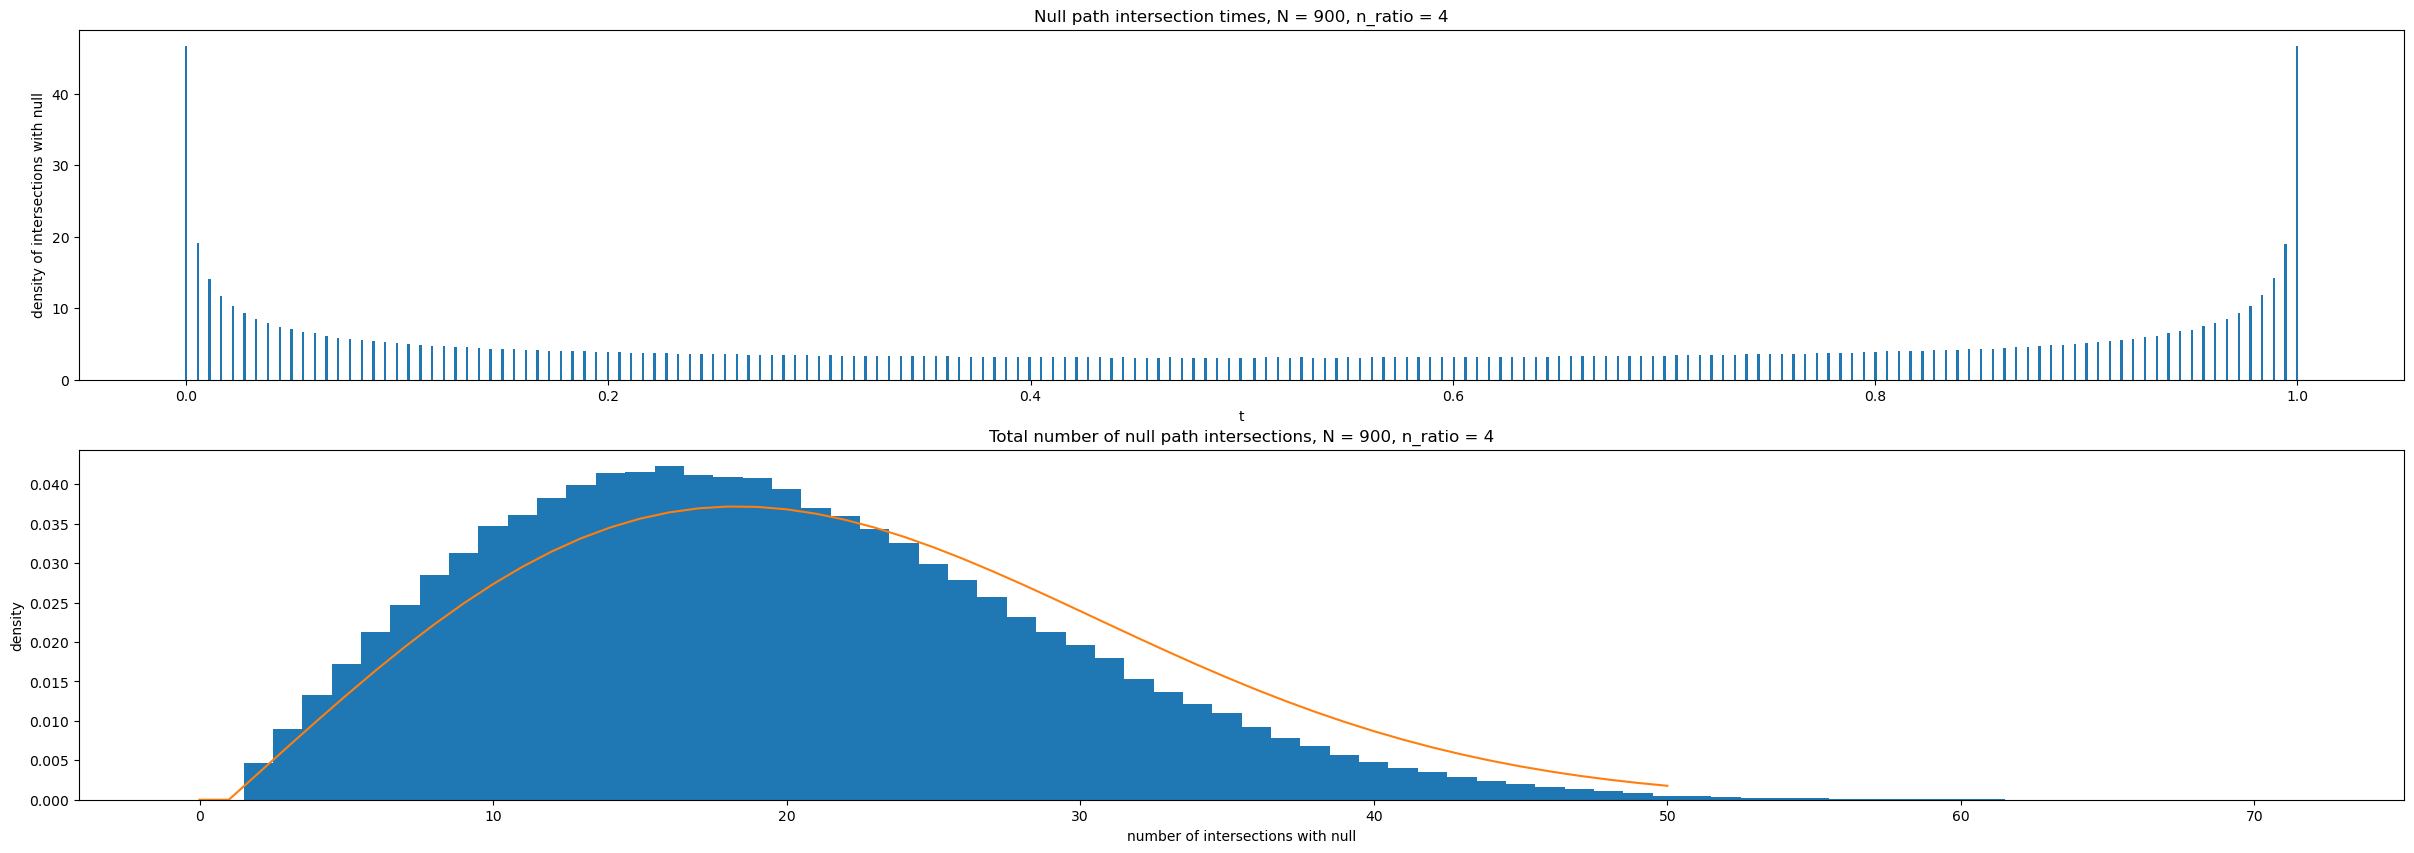

0.00548


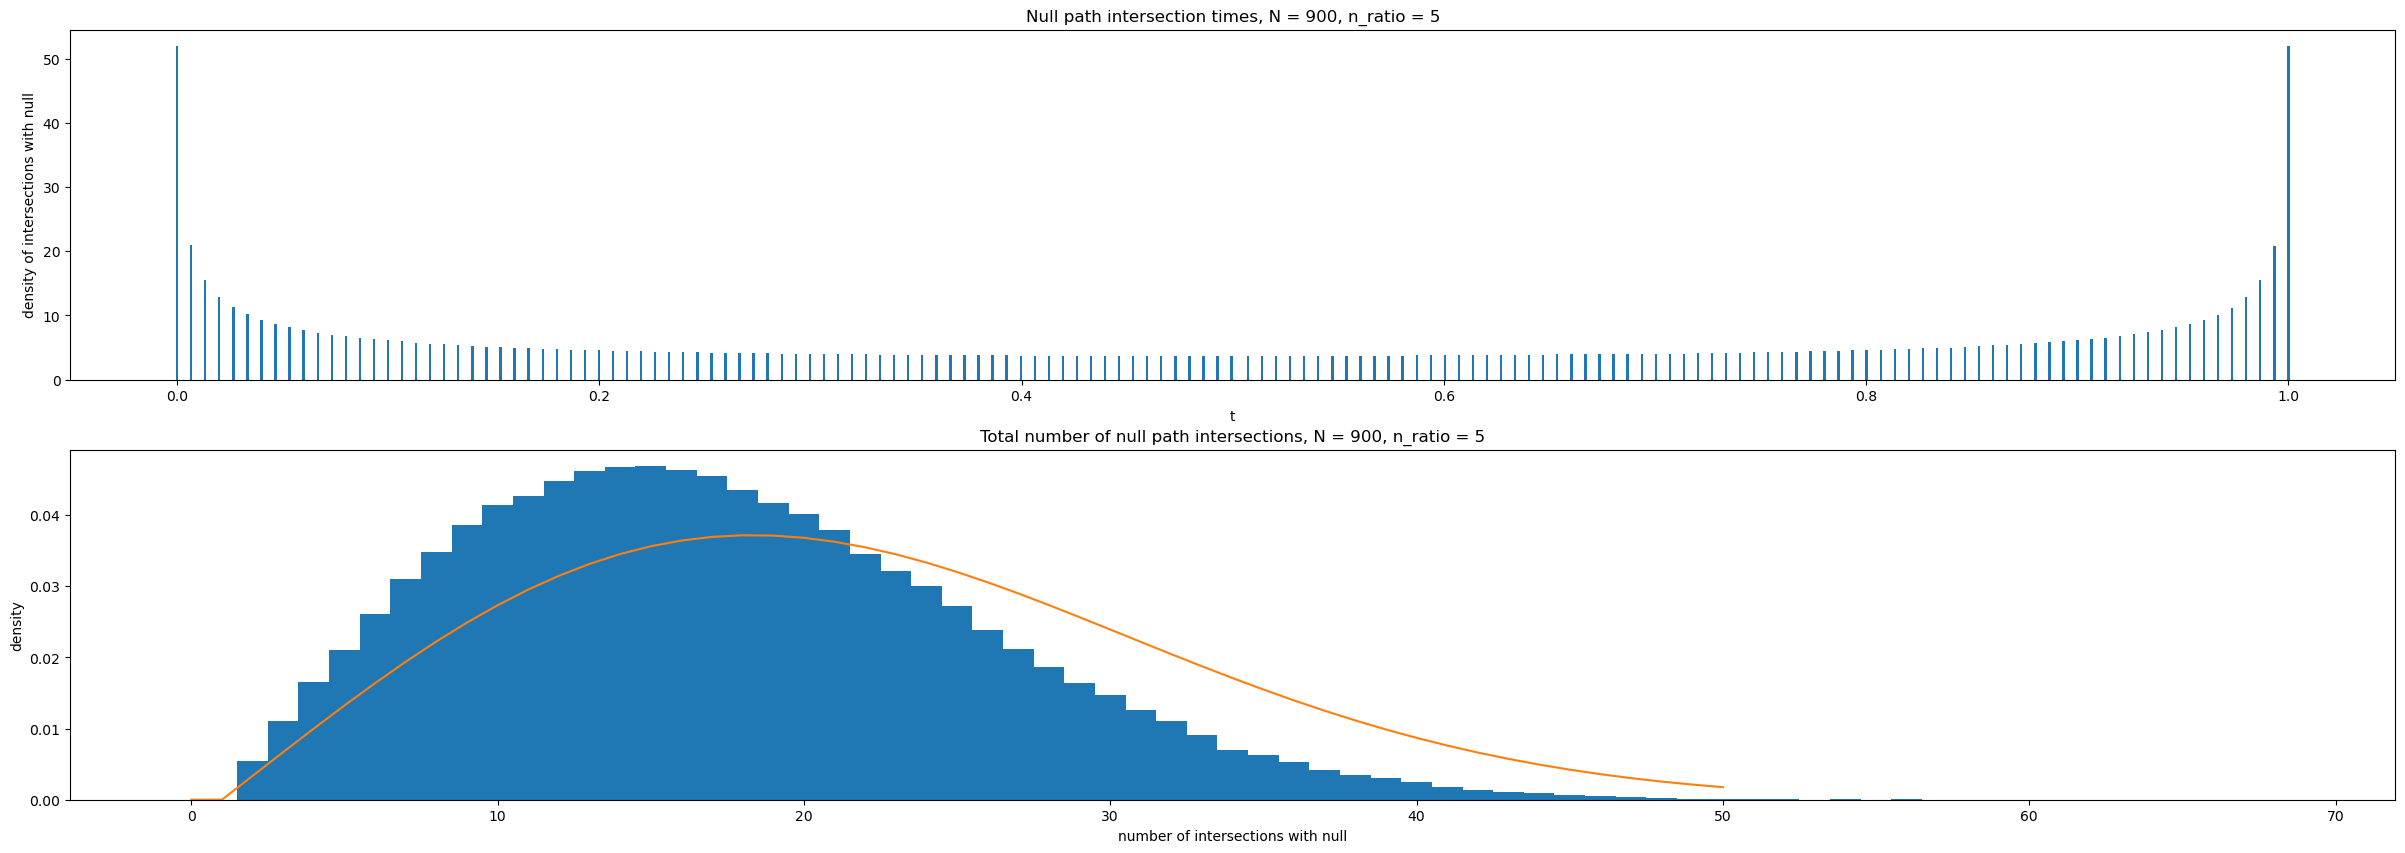

In [177]:
for i in range(len(N1)):
    for j in range(len(n_ratios)):
        inters, inter_number = runs[i][j]
        N = N1[i]
        n_ratio = n_ratios[j]
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        axs[0].hist(inters, bins = N+2, density = True, range = [- 0.5 / N, 1 + 0.5/N])
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        print(np.sum(inter_number <= 2) / len(inter_number))
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        
        scale = 3
        a = prob_sums[i][j] / scale
        Np = N * n_ratio / (n_ratio + 1)
        Nm = N - Np
        c = np.sqrt(Np * (N - Np)) / N
        est = sp.stats.gamma.pdf(np.arange(60), a, scale = scale)
        est_p = sp.stats.poisson.pmf(np.arange(60), c)
        # axs[1].plot(np.arange(60), est)
        axs[1].plot(np.arange(51), dp[-1])
        # axs[1].plot(np.arange(60), est_p)
        plt.show()

In [18]:
def null_intersection_exact(N, n_ratio):
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])
    probs = []
    for j in range(N+1):
        prob = float(sp.stats.hypergeom.pmf(k=j * Ns[0] / N, N=j, n=Ns[0], M=N))
        probs.append(prob)
    return probs

In [ ]:
prob_array = []
prob_sums = []
for N in N1:
    prob_array.append([])
    prob_sums.append([])
    for n_ratio in n_ratios:
        prob_array[-1].append(null_intersection_exact(N, n_ratio))
        prob_sums[-1].append(sum(prob_array[-1][-1]))

print(prob_sums)

[[21.726135174191704, 15.69791804032004, 12.992297450842694, 11.369359845398892, 10.25758946022057], [30.712595481602968, 22.05180265749958, 18.17946178453296, 15.860847521369859, 14.27422549535231], [37.609869852522394, 26.928676311360494, 22.1610658681302, 19.30868644749246, 17.357760115680332]]


In [175]:
# def f(N,l,i,nr):
#     return (1 - 1 / (nr * i - 1)) * sp.special.comb((N - (l - nr * i))/ 2, nr * i / 2)** 2 / sp.special.comb(N - (l - nr * i), nr * i)

def f(N,c,a,nr):
    return (1 / ((a - c)*nr - 1)) * sp.special.comb((N - c * nr)/ 2, nr * (a-c) / 2) ** 2 / sp.special.comb(N - c * nr, nr * (a-c))

l = 300
N = 300
k = 50

# print(f(N, 0, 1, 2))

if l % 2 != 0:
    print("non-int")

dp = np.zeros([int(l/2)+1, k]) # P j_b = a n_r
dp[0,0] = 1
dp[1,1] = sp.special.comb(N / 2, 1) * sp.special.comb(N / 2, 1) / sp.special.comb(N, 2)

# print(dp)
for i in range(2, int(l/2)+1):
    for b in range(1,k):
        if b > i:
            continue
        else:
            x = [dp[c,b-1] * f(N, c, i, 2) for c in range(i)]
            # print(i,b,x)
            dp[i,b] = np.sum(x)
dp = np.concatenate([np.zeros([int(l/2 + 1),1]),dp],axis=1)
print(dp[-1])

[0.         0.         0.00334448 0.00668896 0.00999966 0.0132428
 0.01638515 0.01939467 0.02224099 0.02489598 0.02733425 0.02953355
 0.03147521 0.03314435 0.03453017 0.03562607 0.03642967 0.03694276
 0.03717121 0.03712469 0.03681641 0.03626278 0.03548294 0.03449831
 0.03333214 0.03200894 0.03055399 0.02899283 0.02735081 0.02565255
 0.02392165 0.02218022 0.02044868 0.01874545 0.01708679 0.01548673
 0.01395696 0.01250689 0.01114365 0.00987226 0.00869571 0.00761518
 0.00663021 0.00573891 0.0049382  0.00422403 0.00359155 0.00303538
 0.00254974 0.00212866 0.00176611]


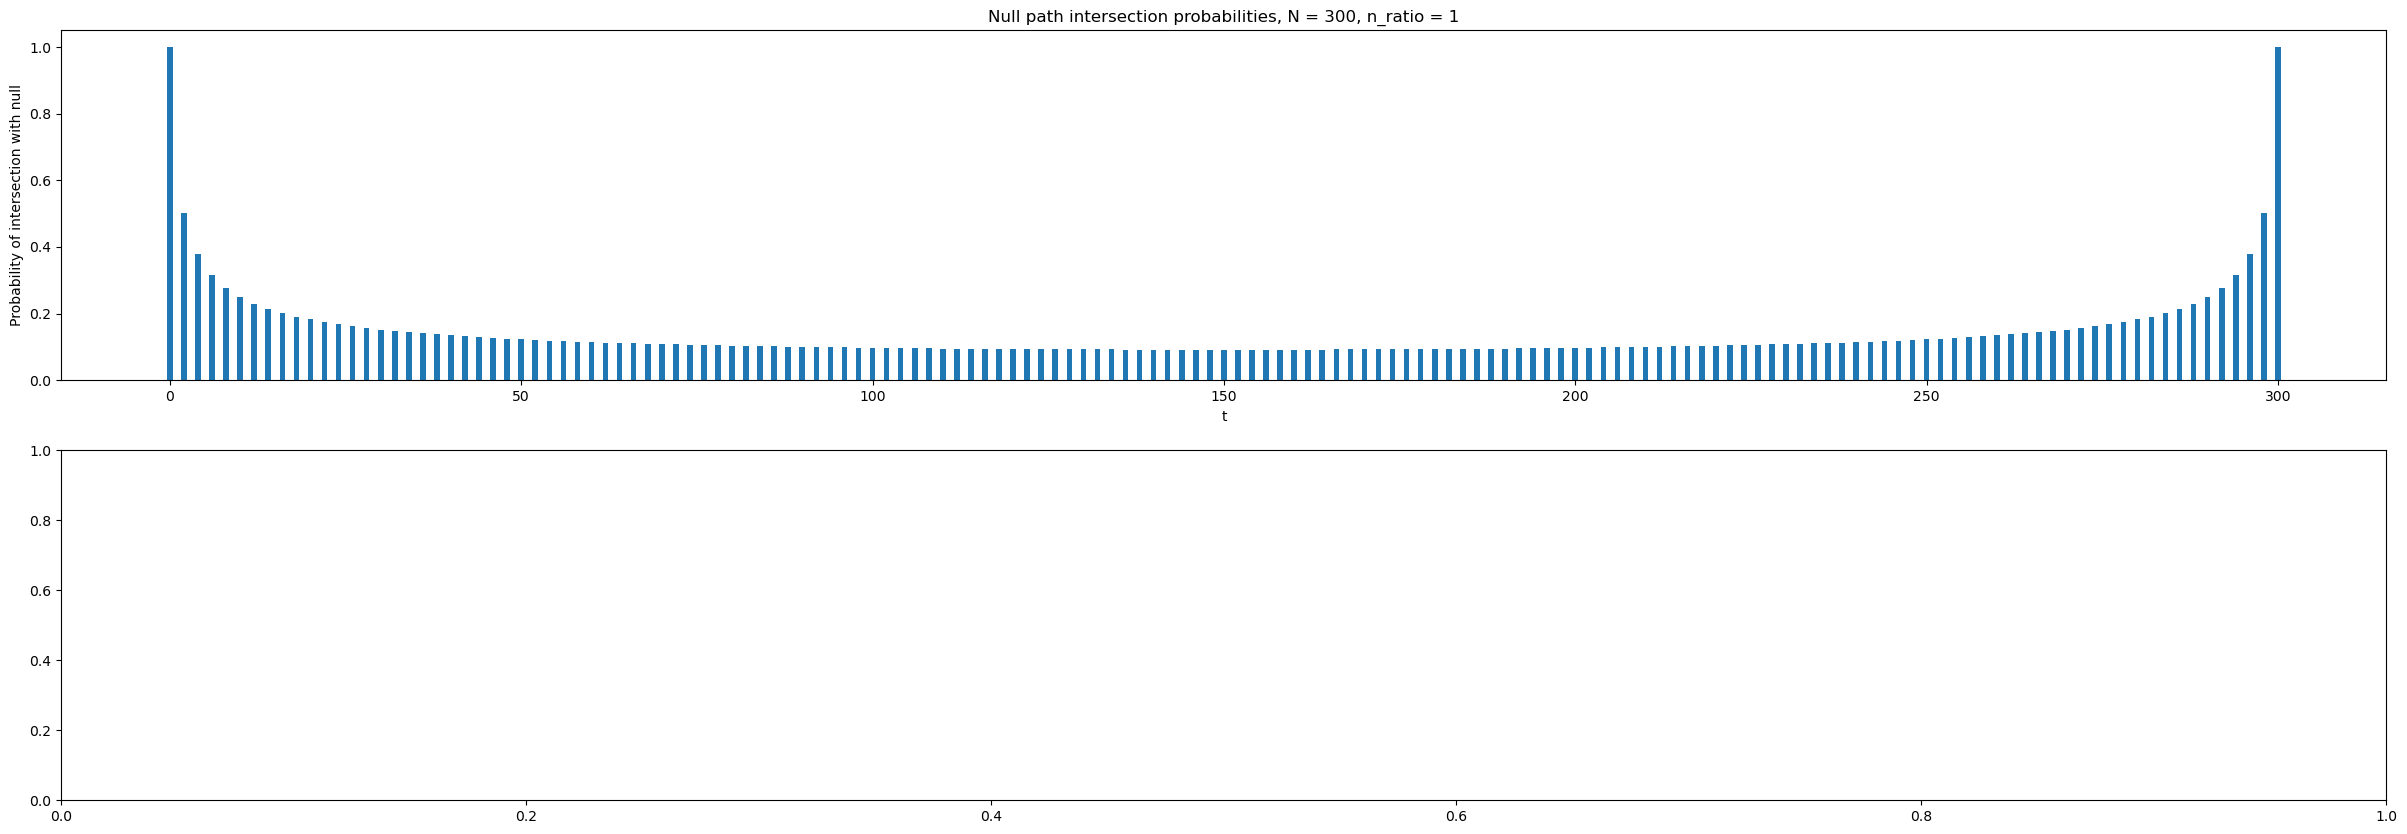

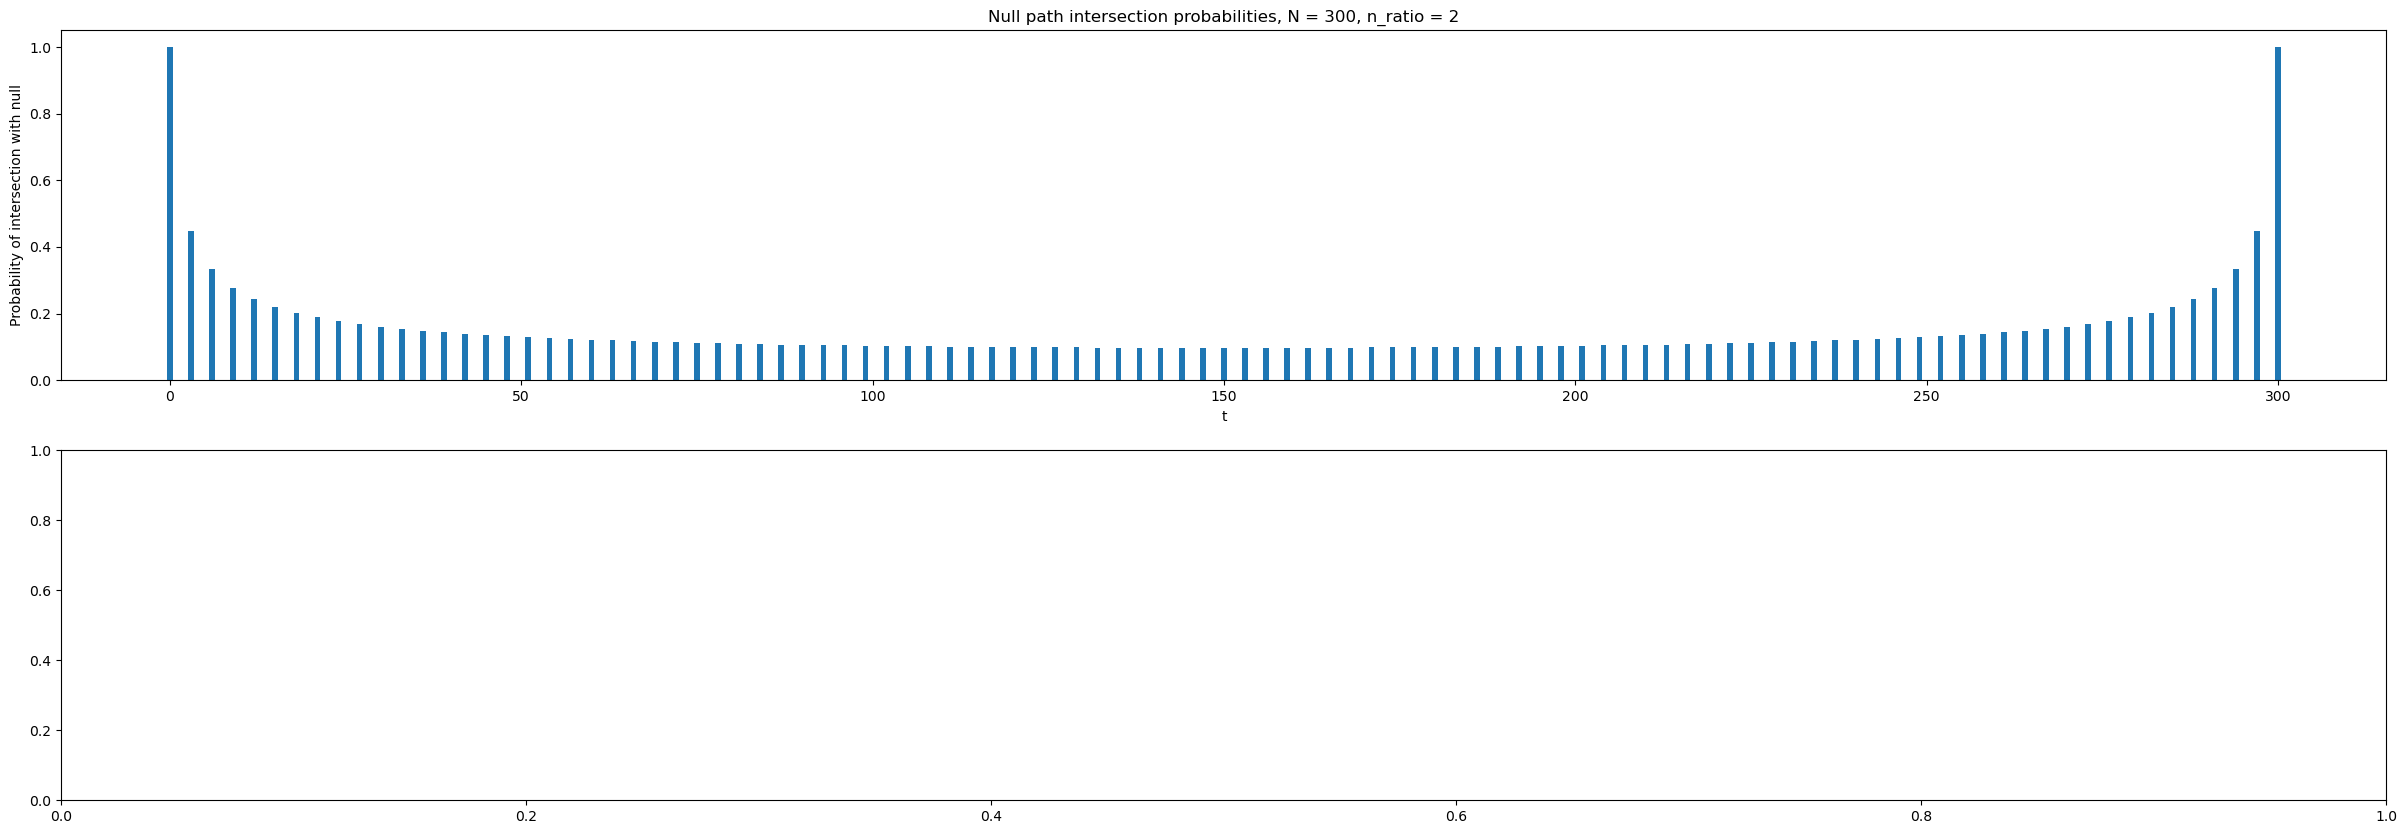

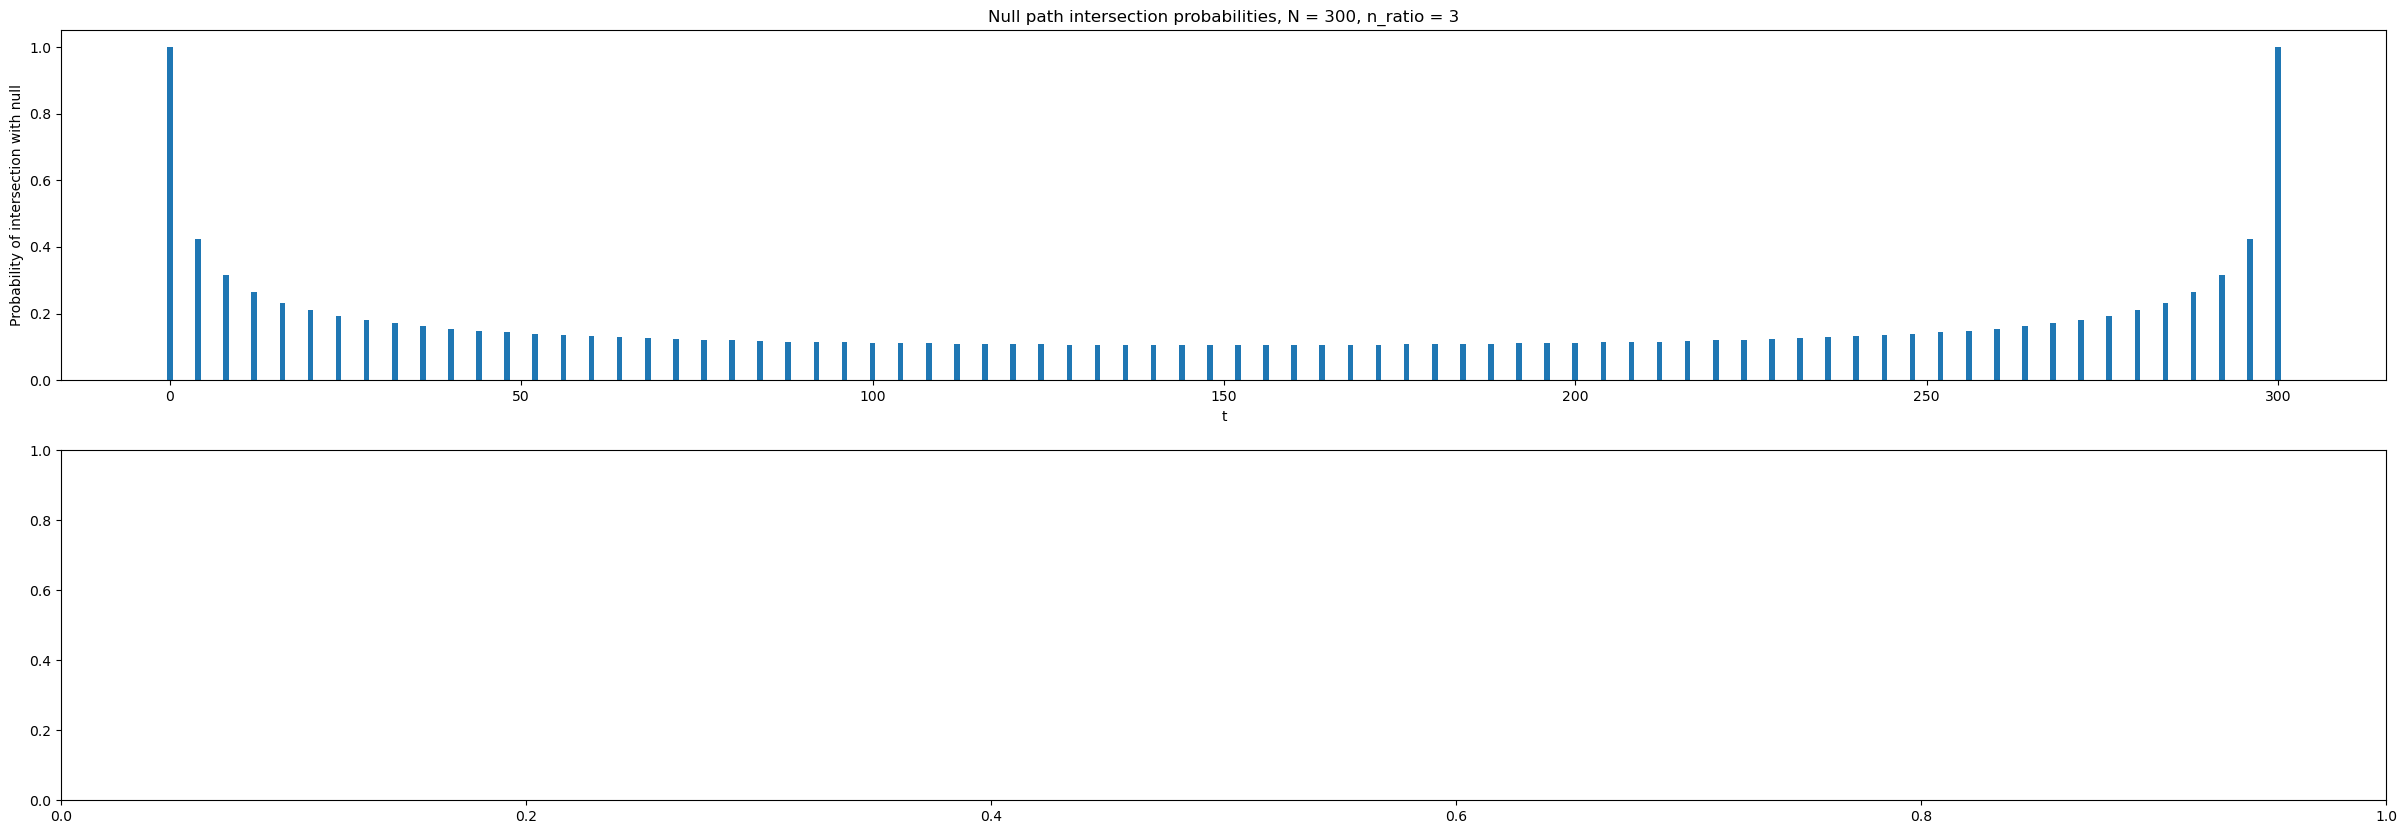

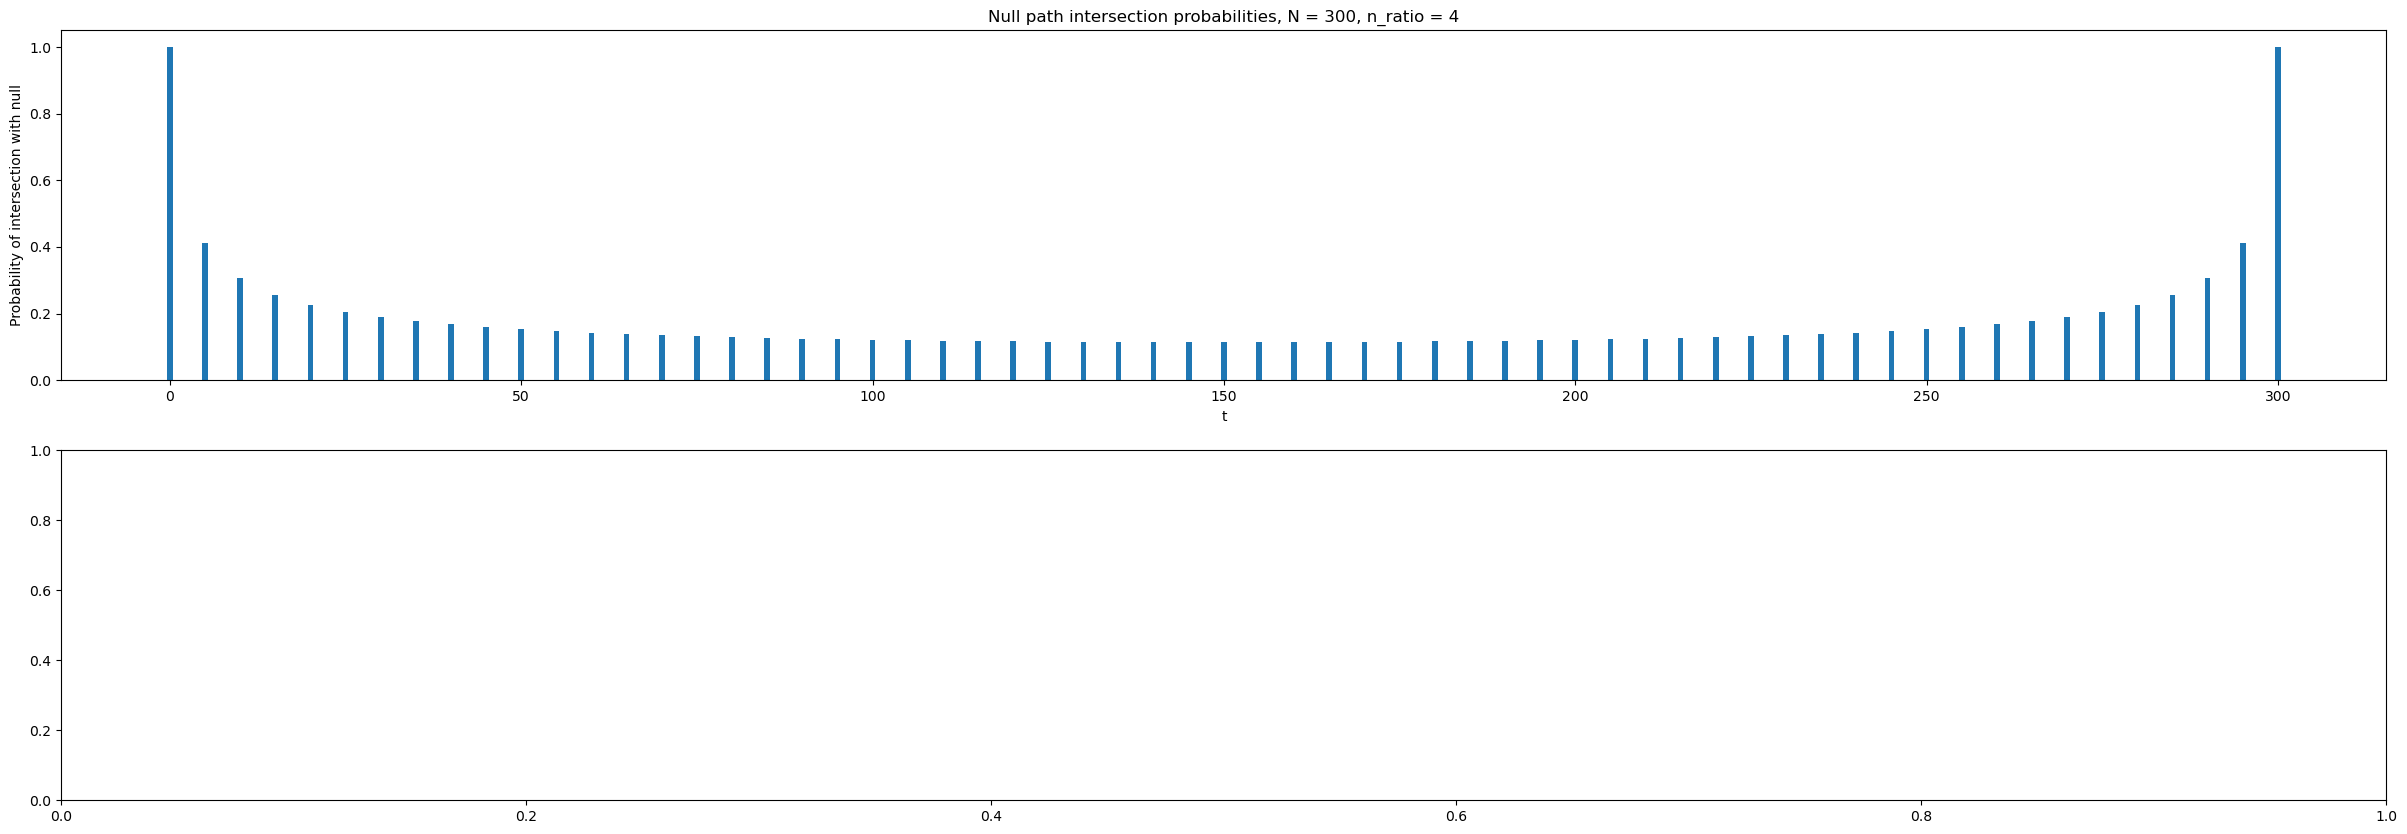

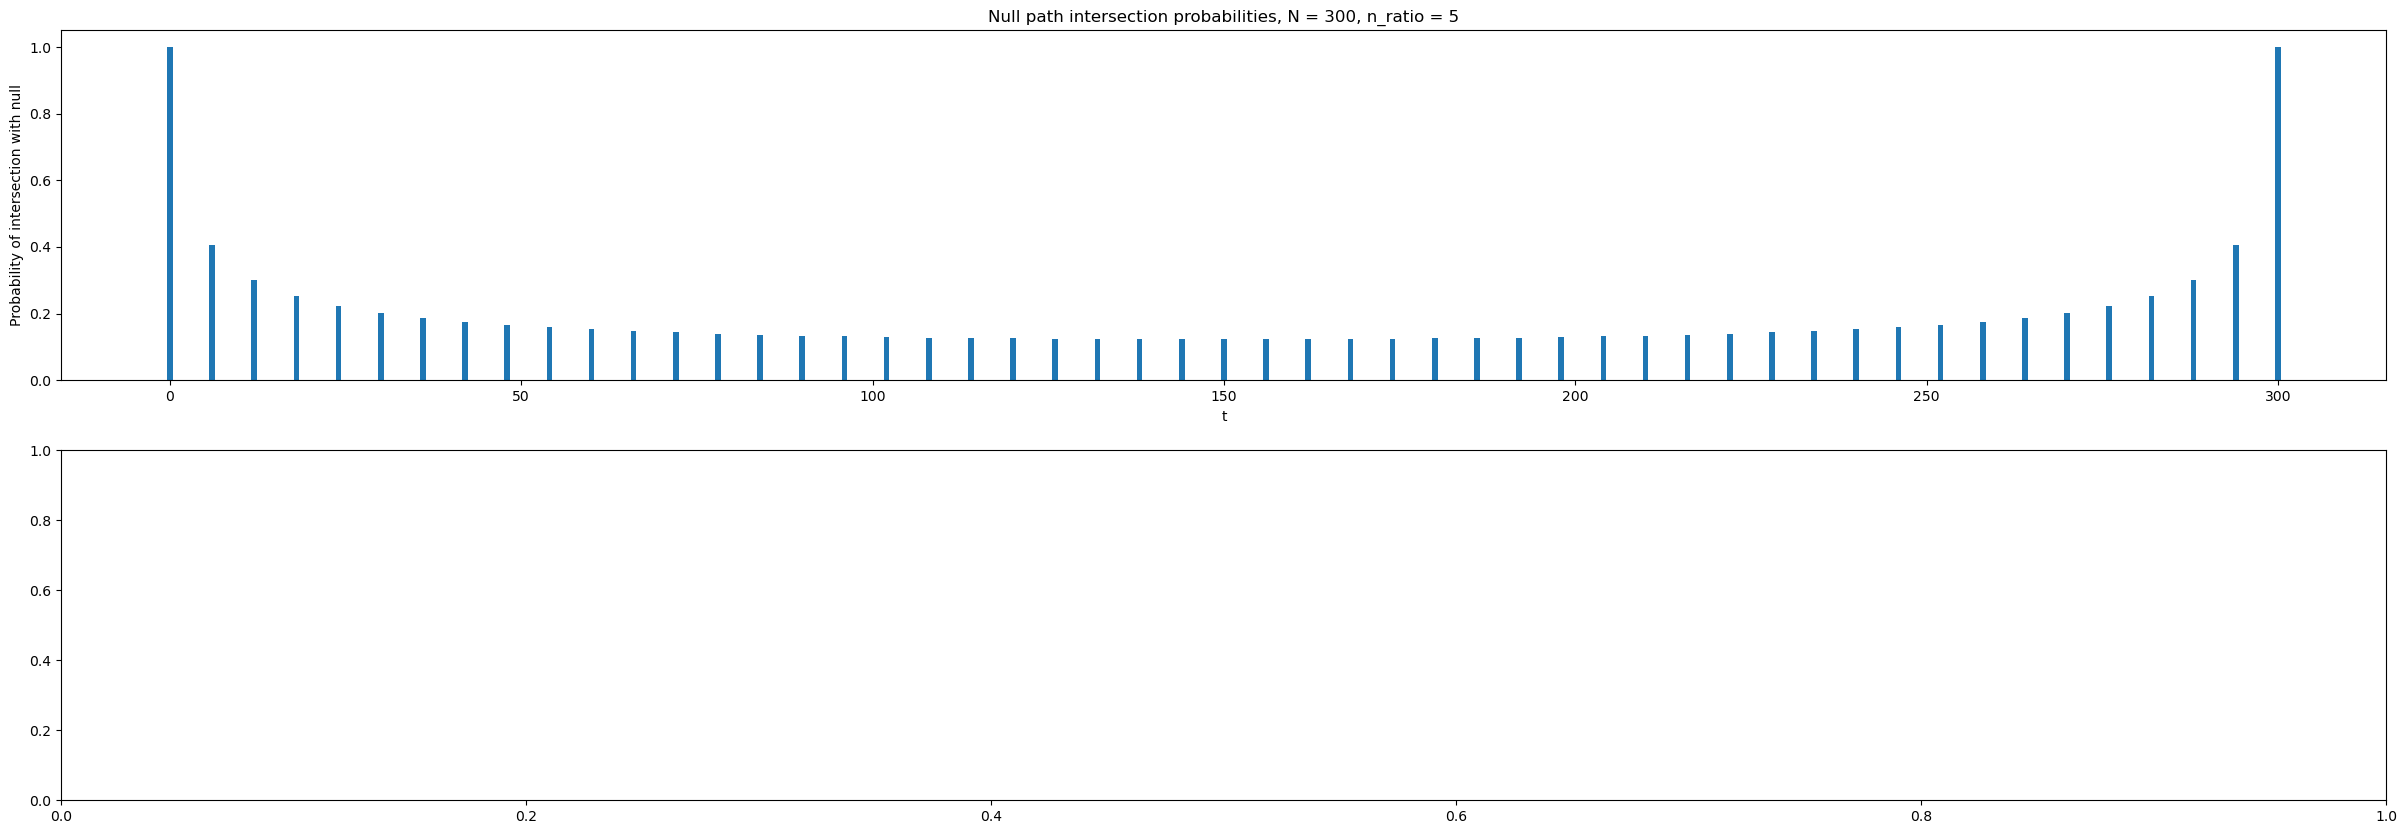

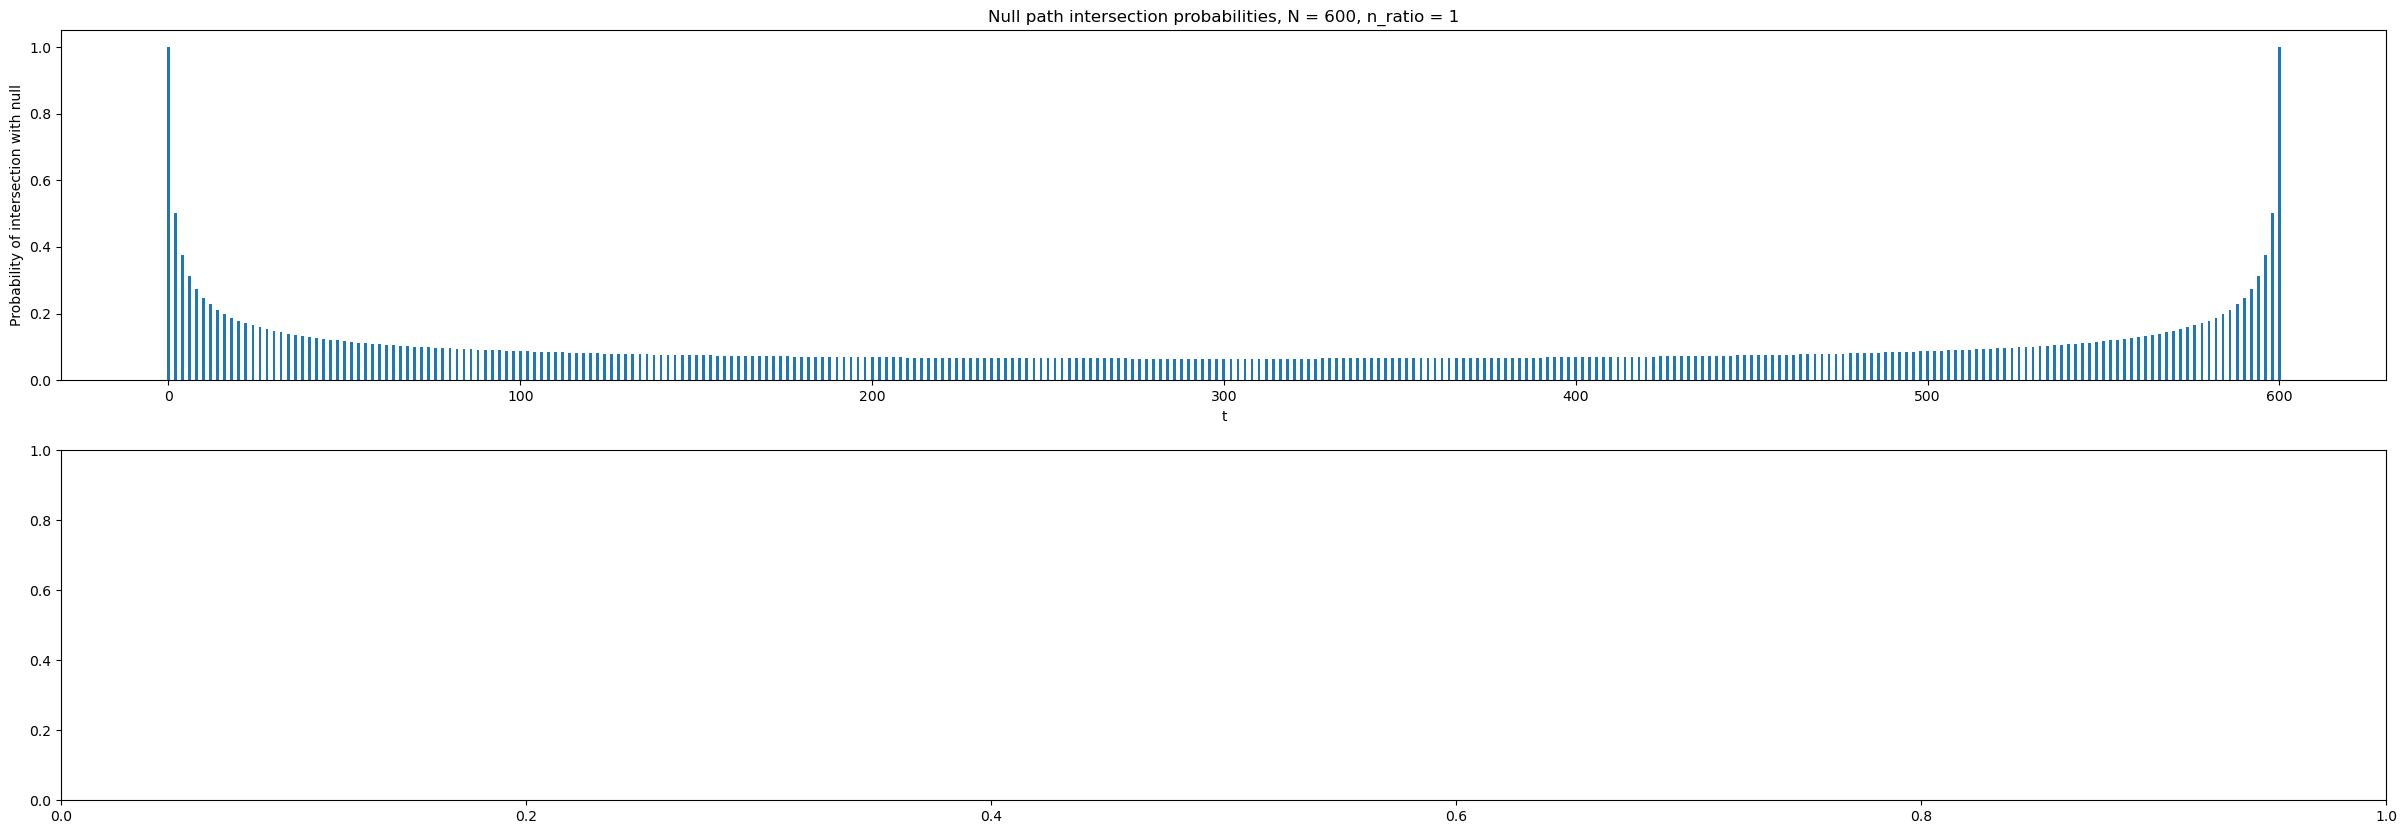

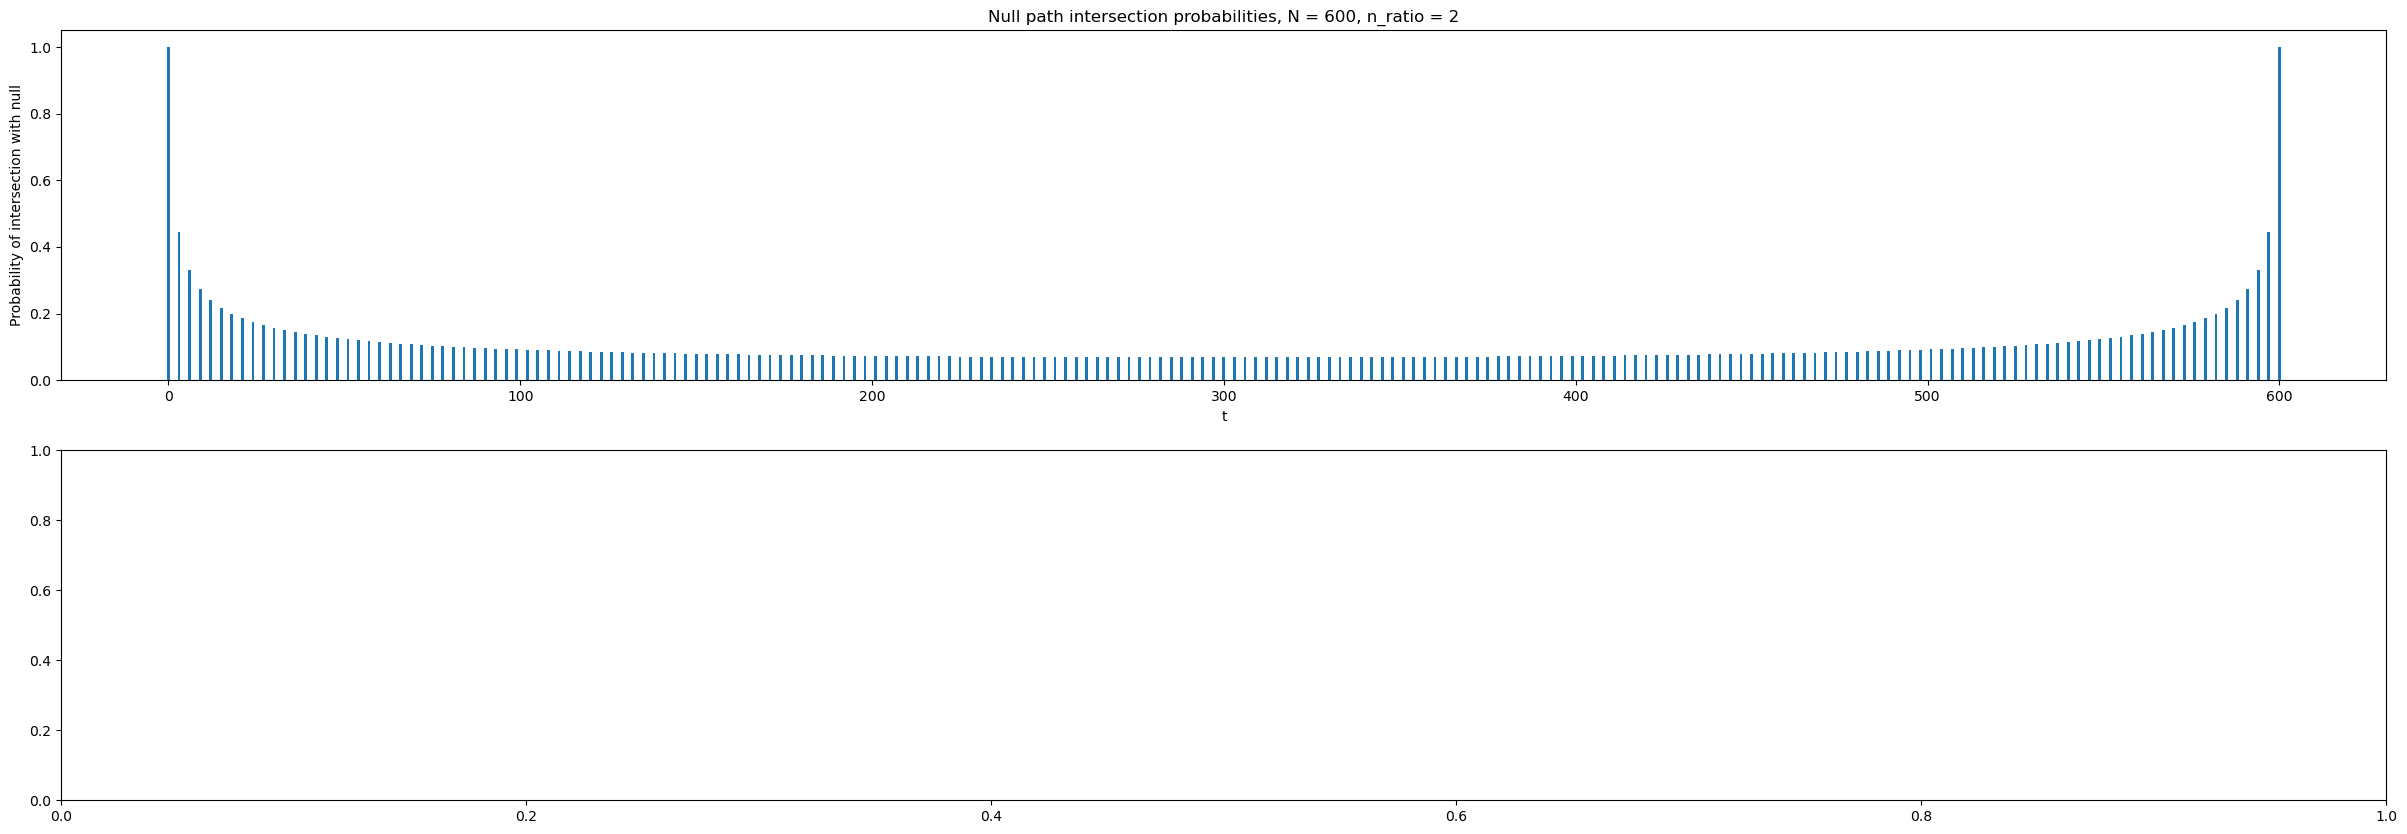

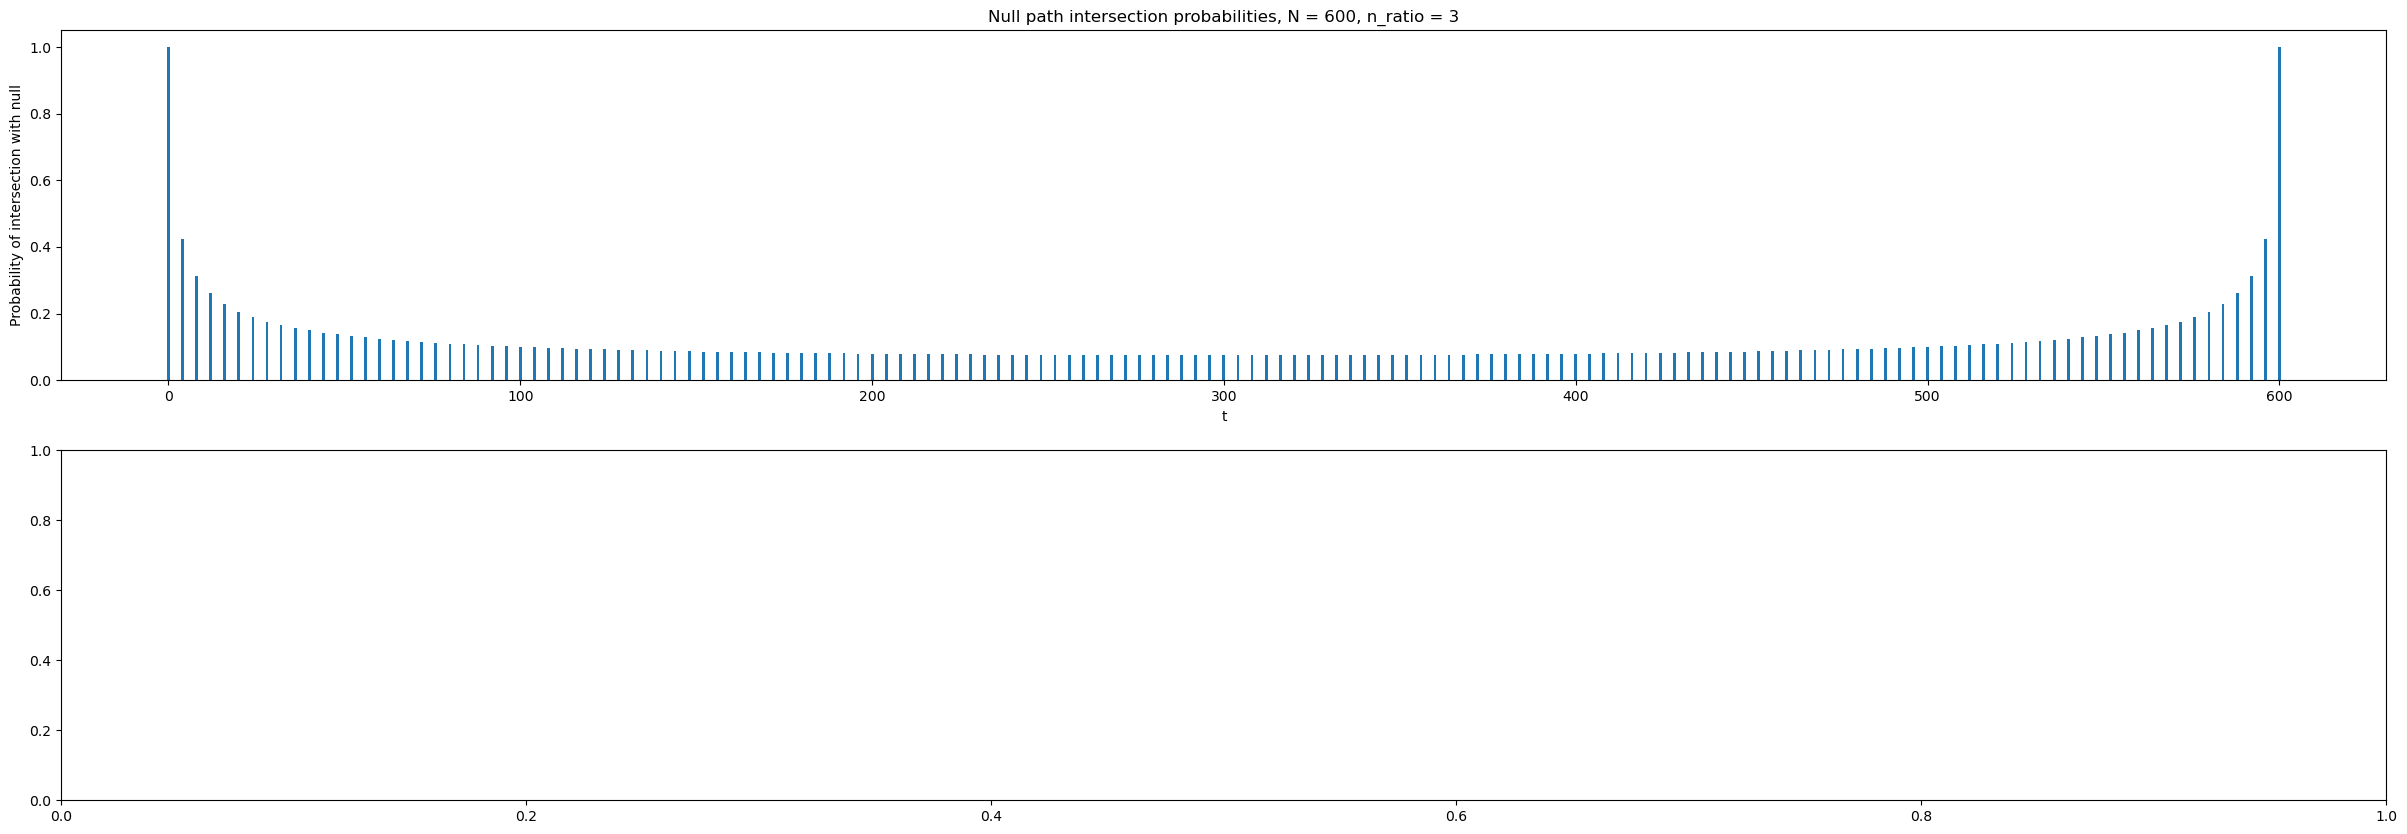

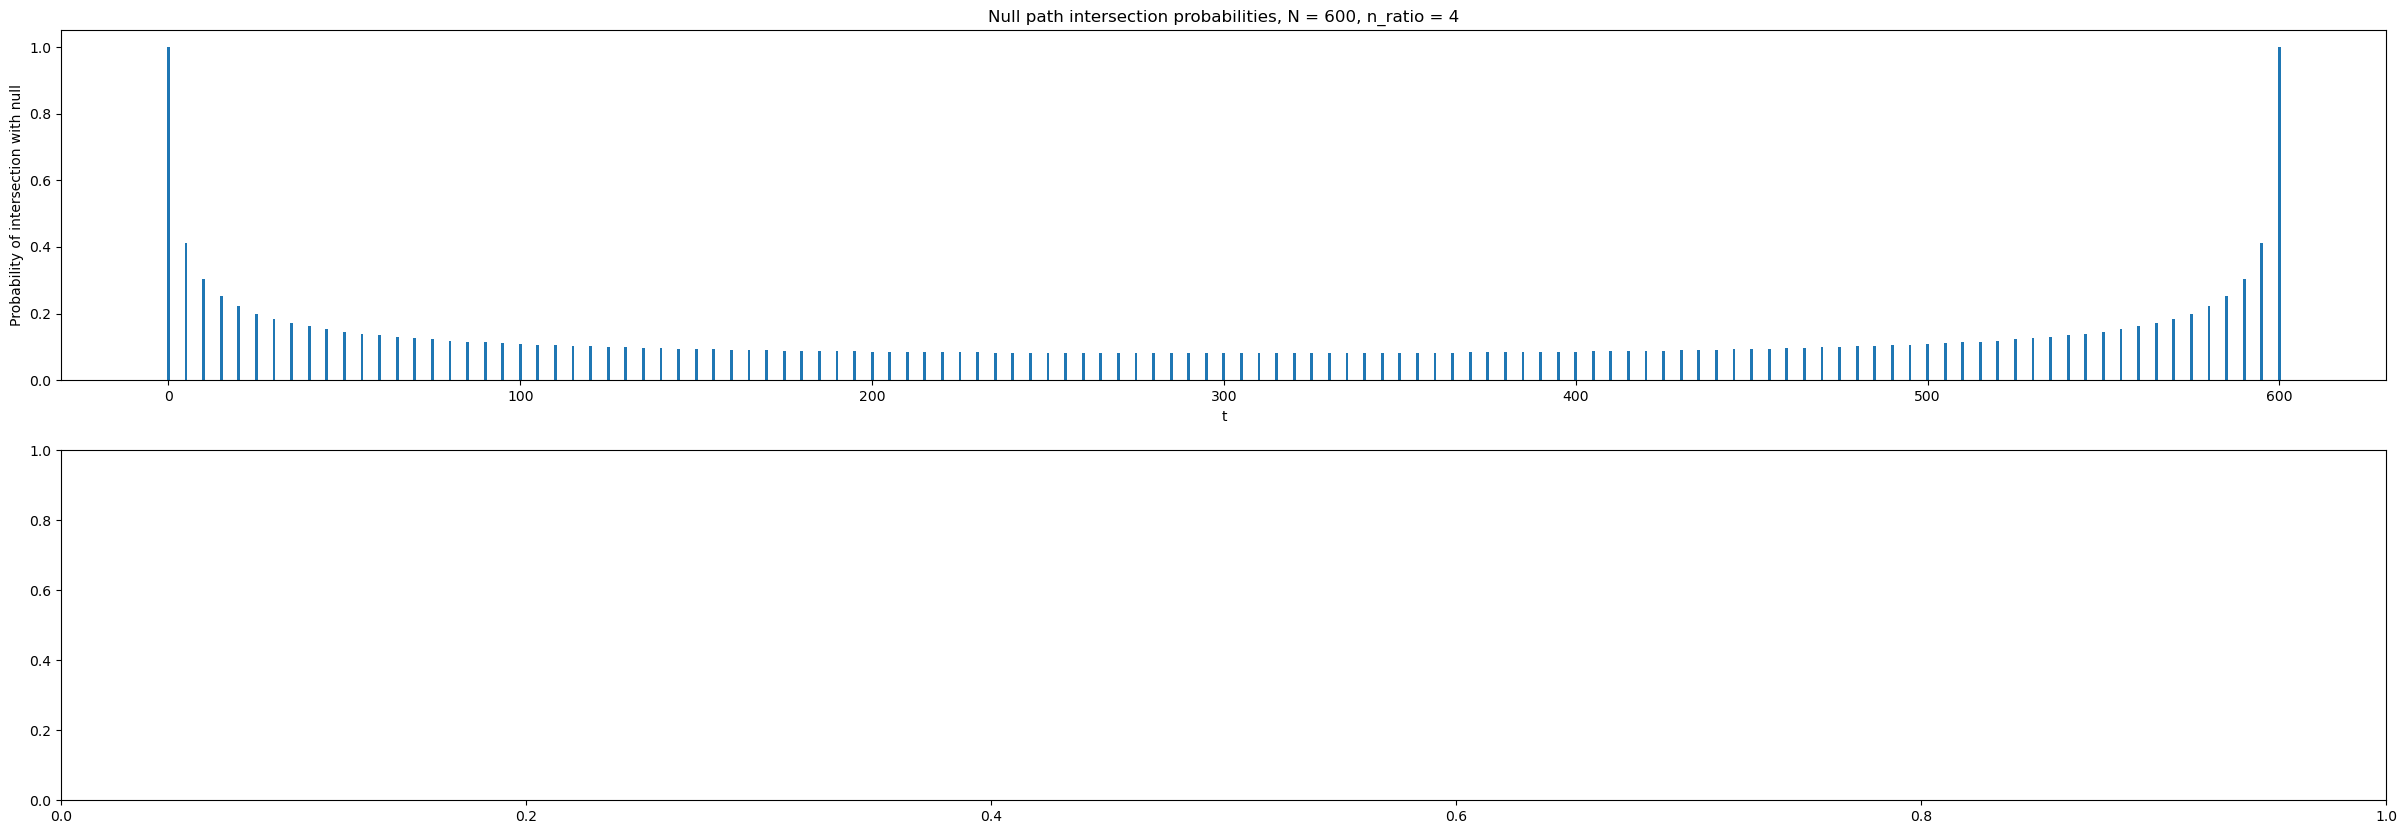

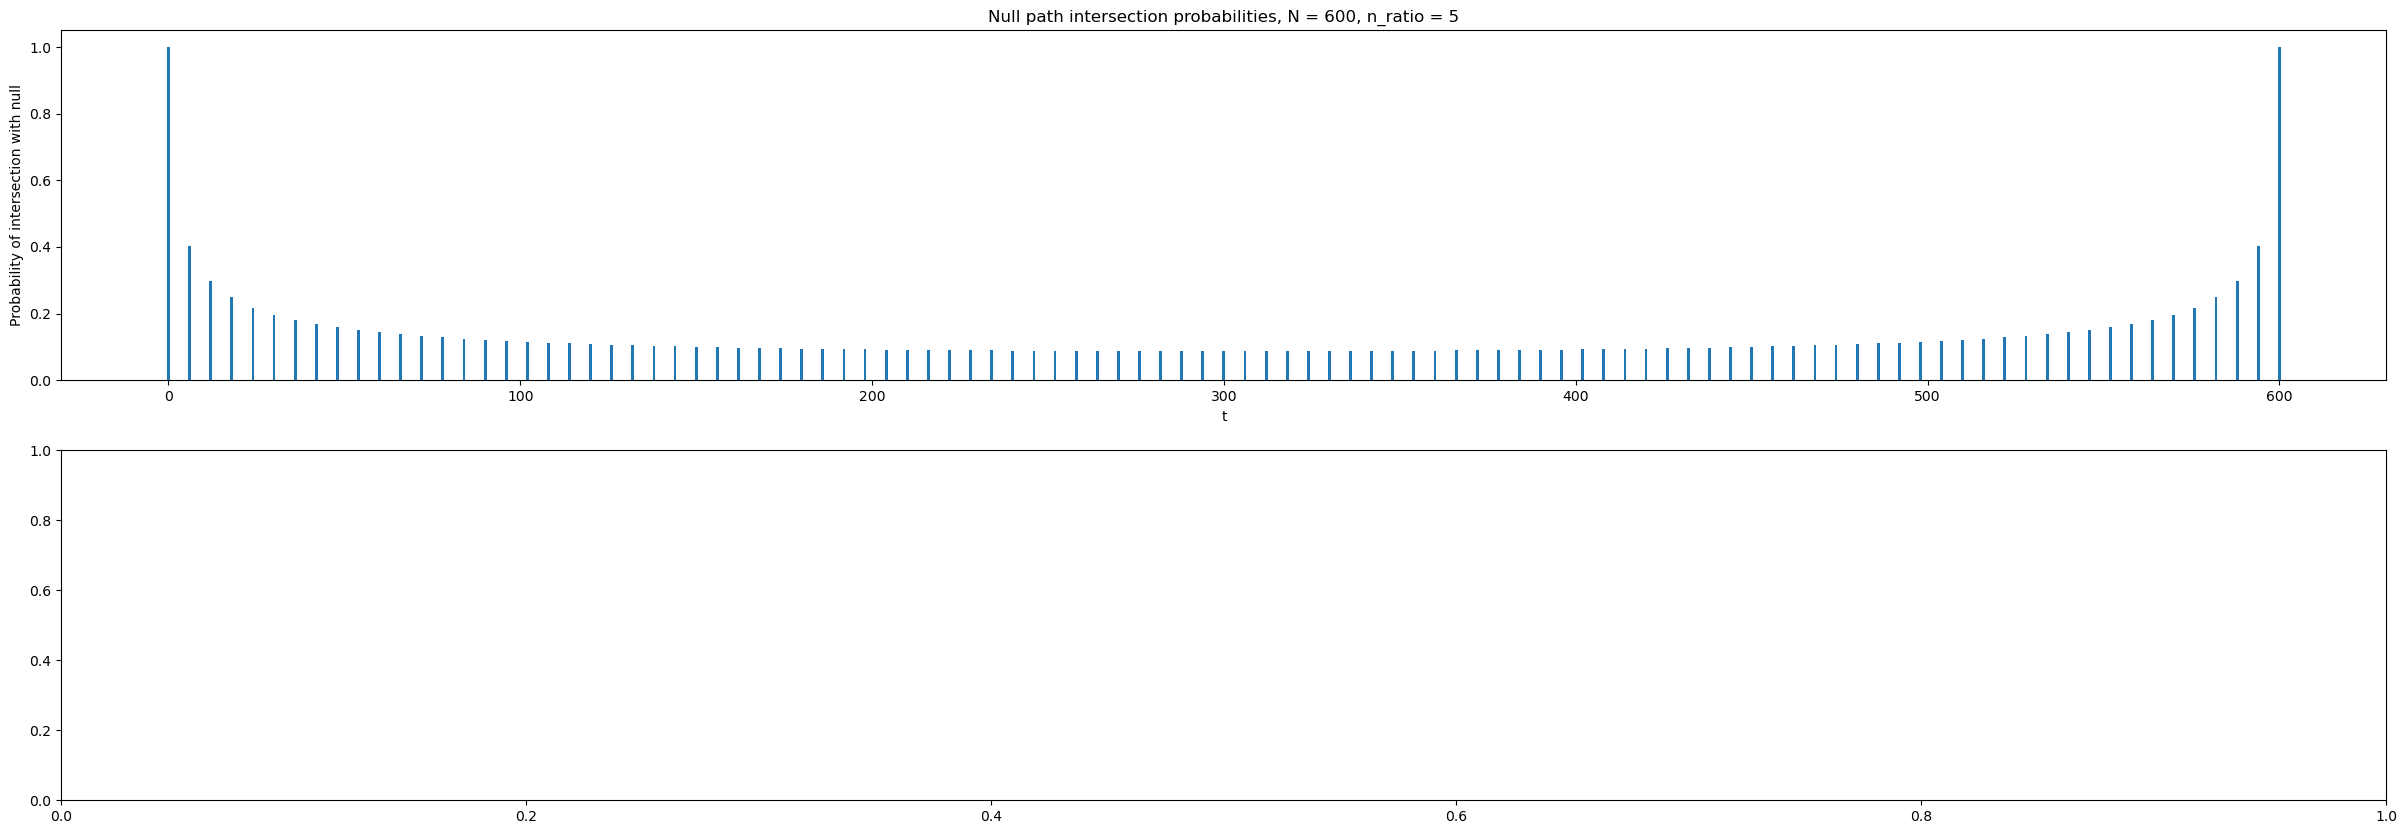

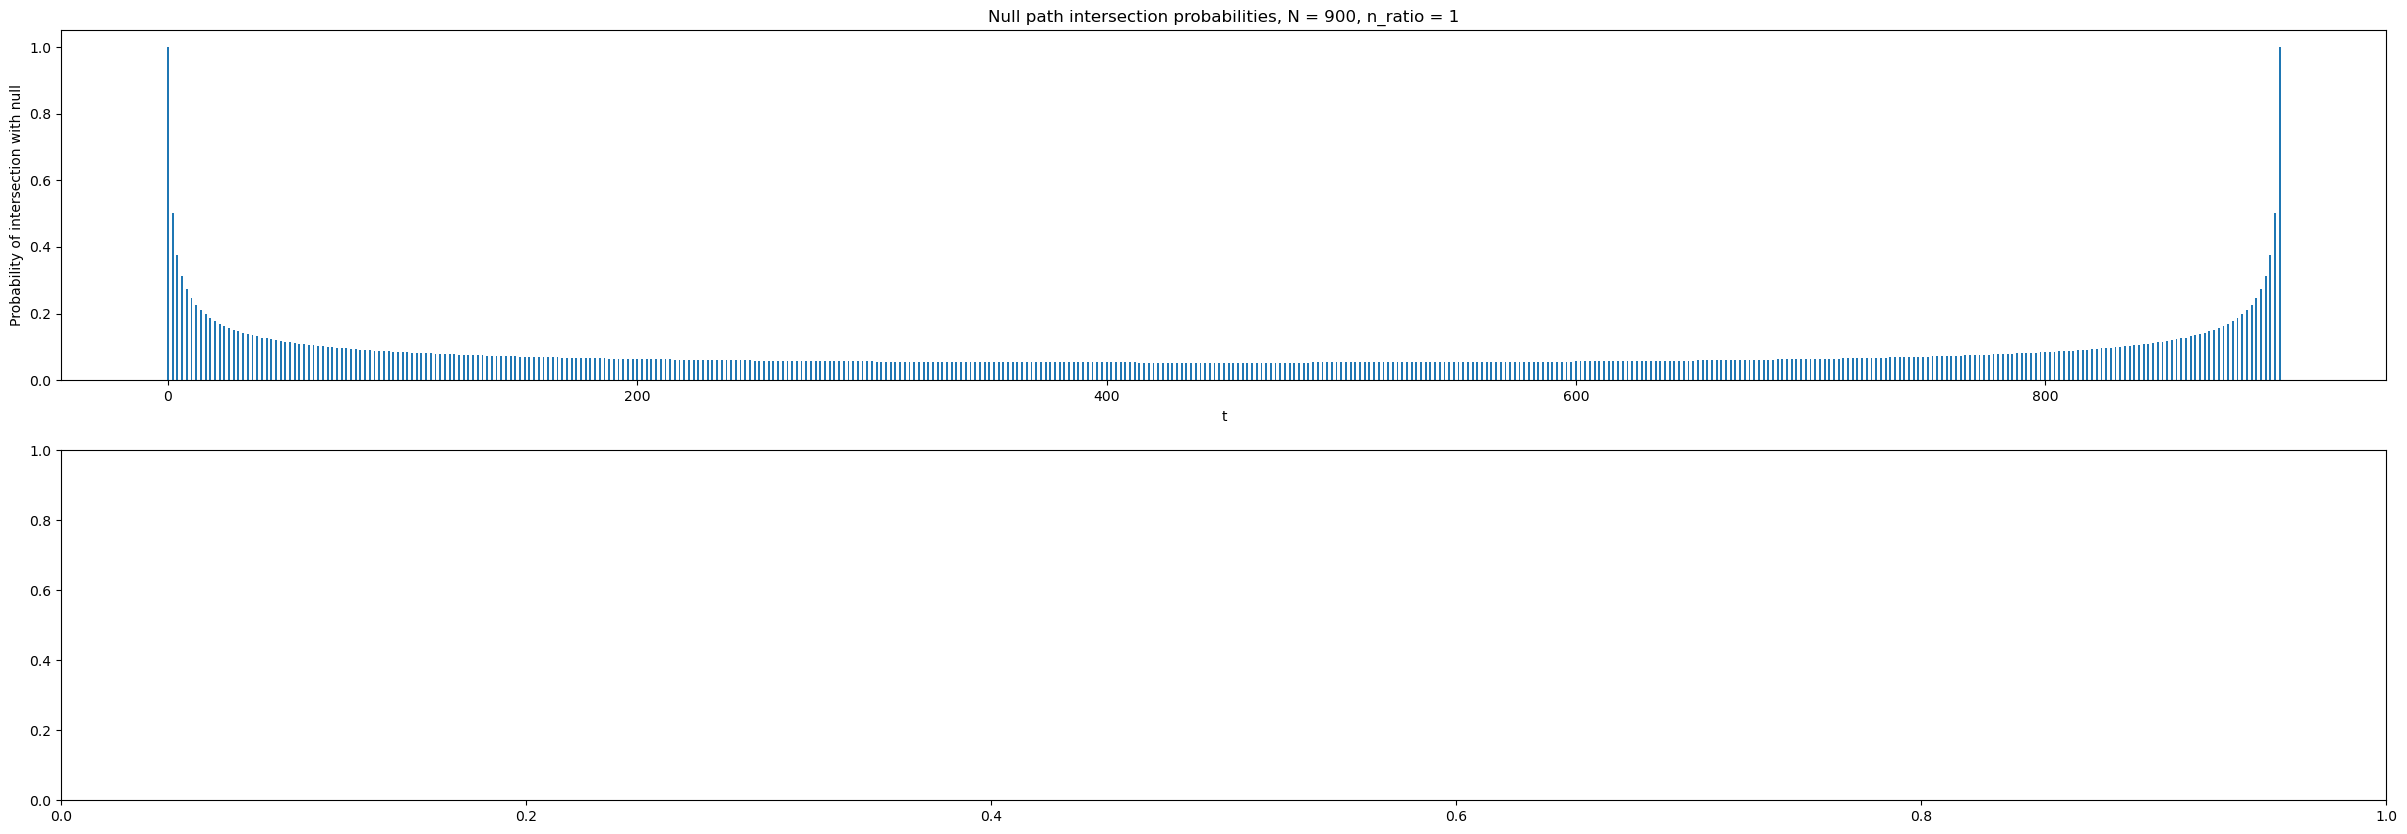

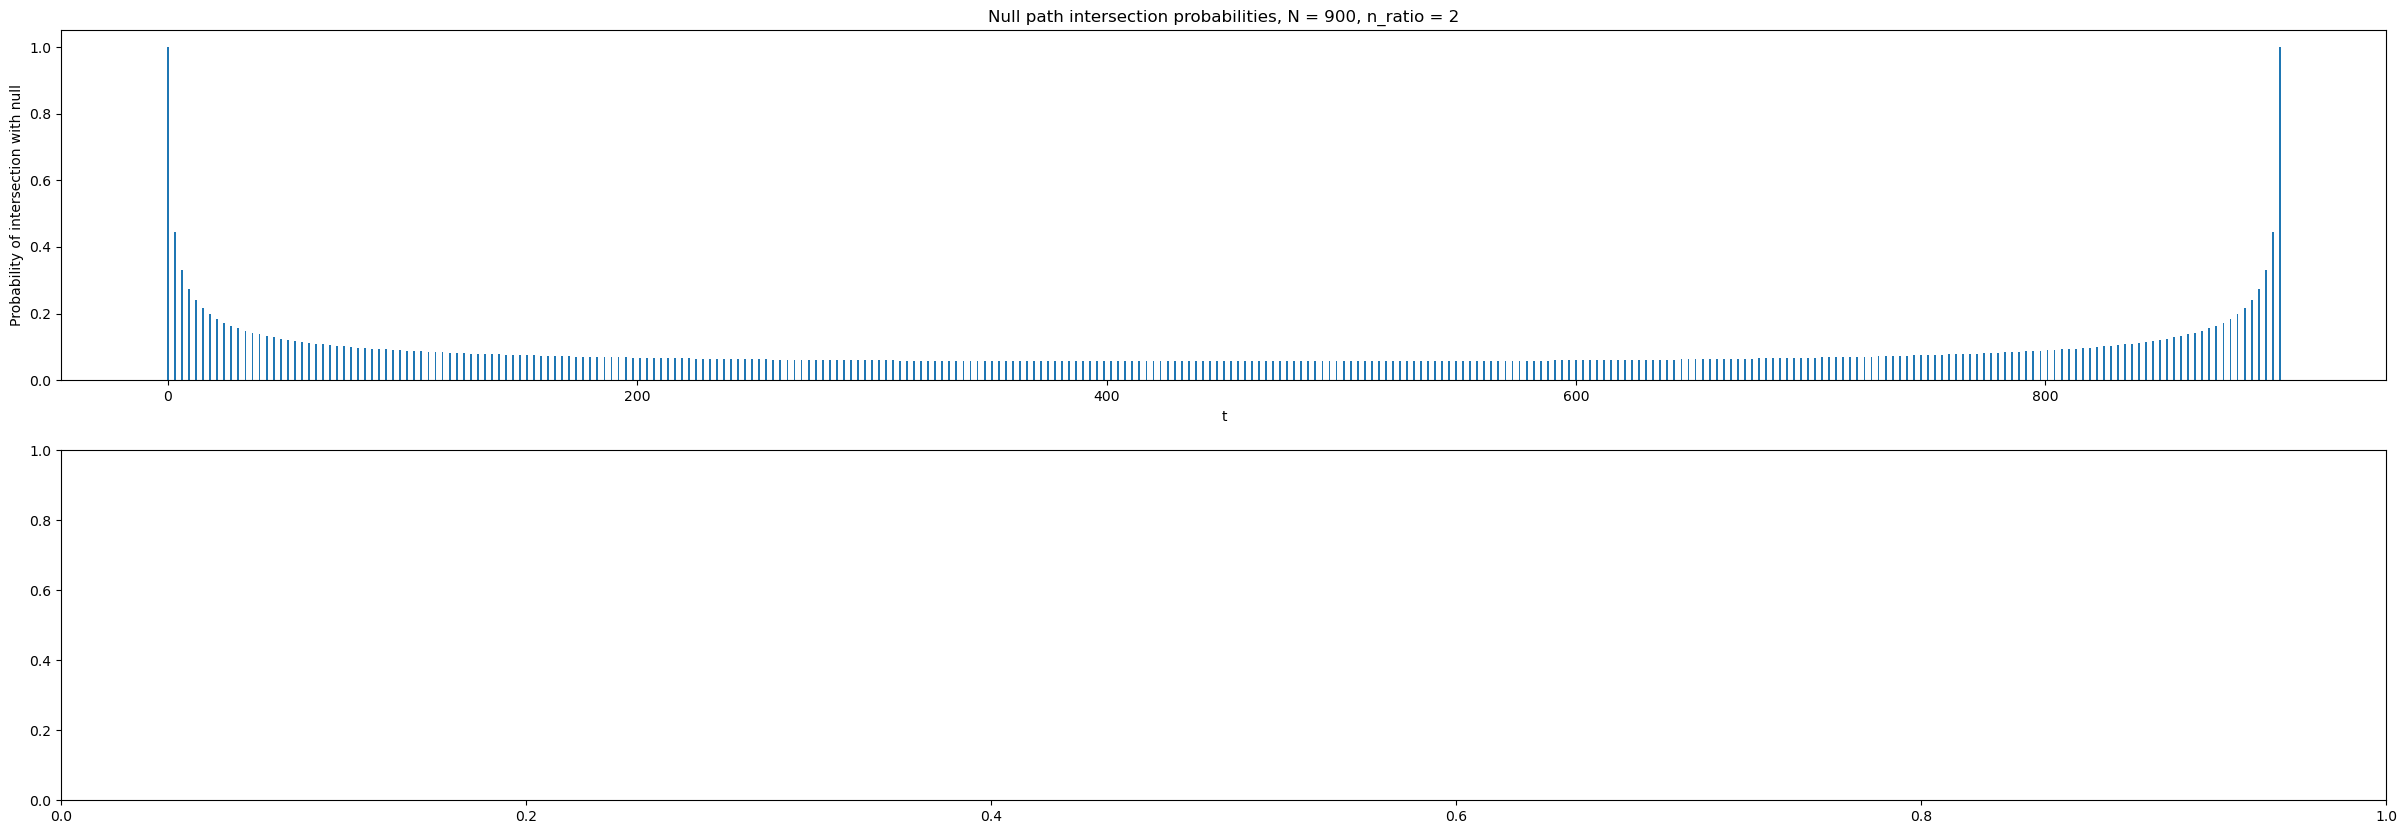

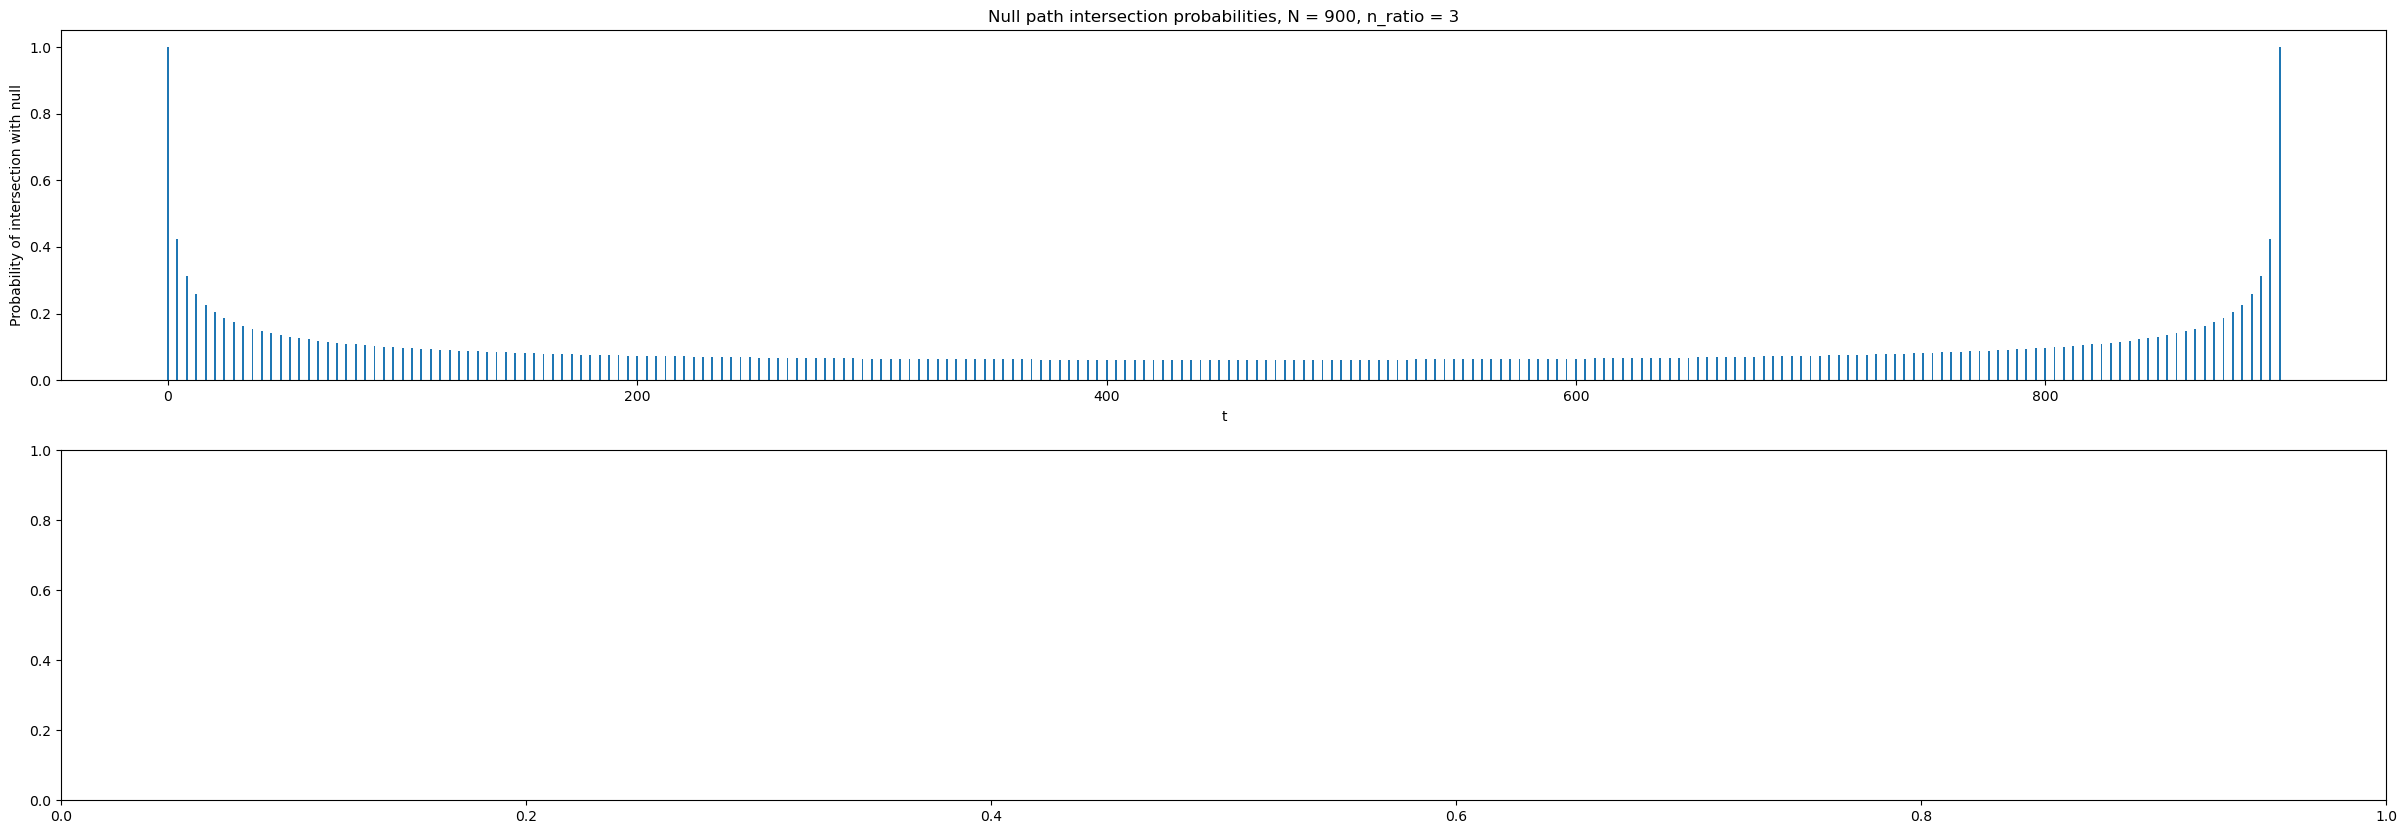

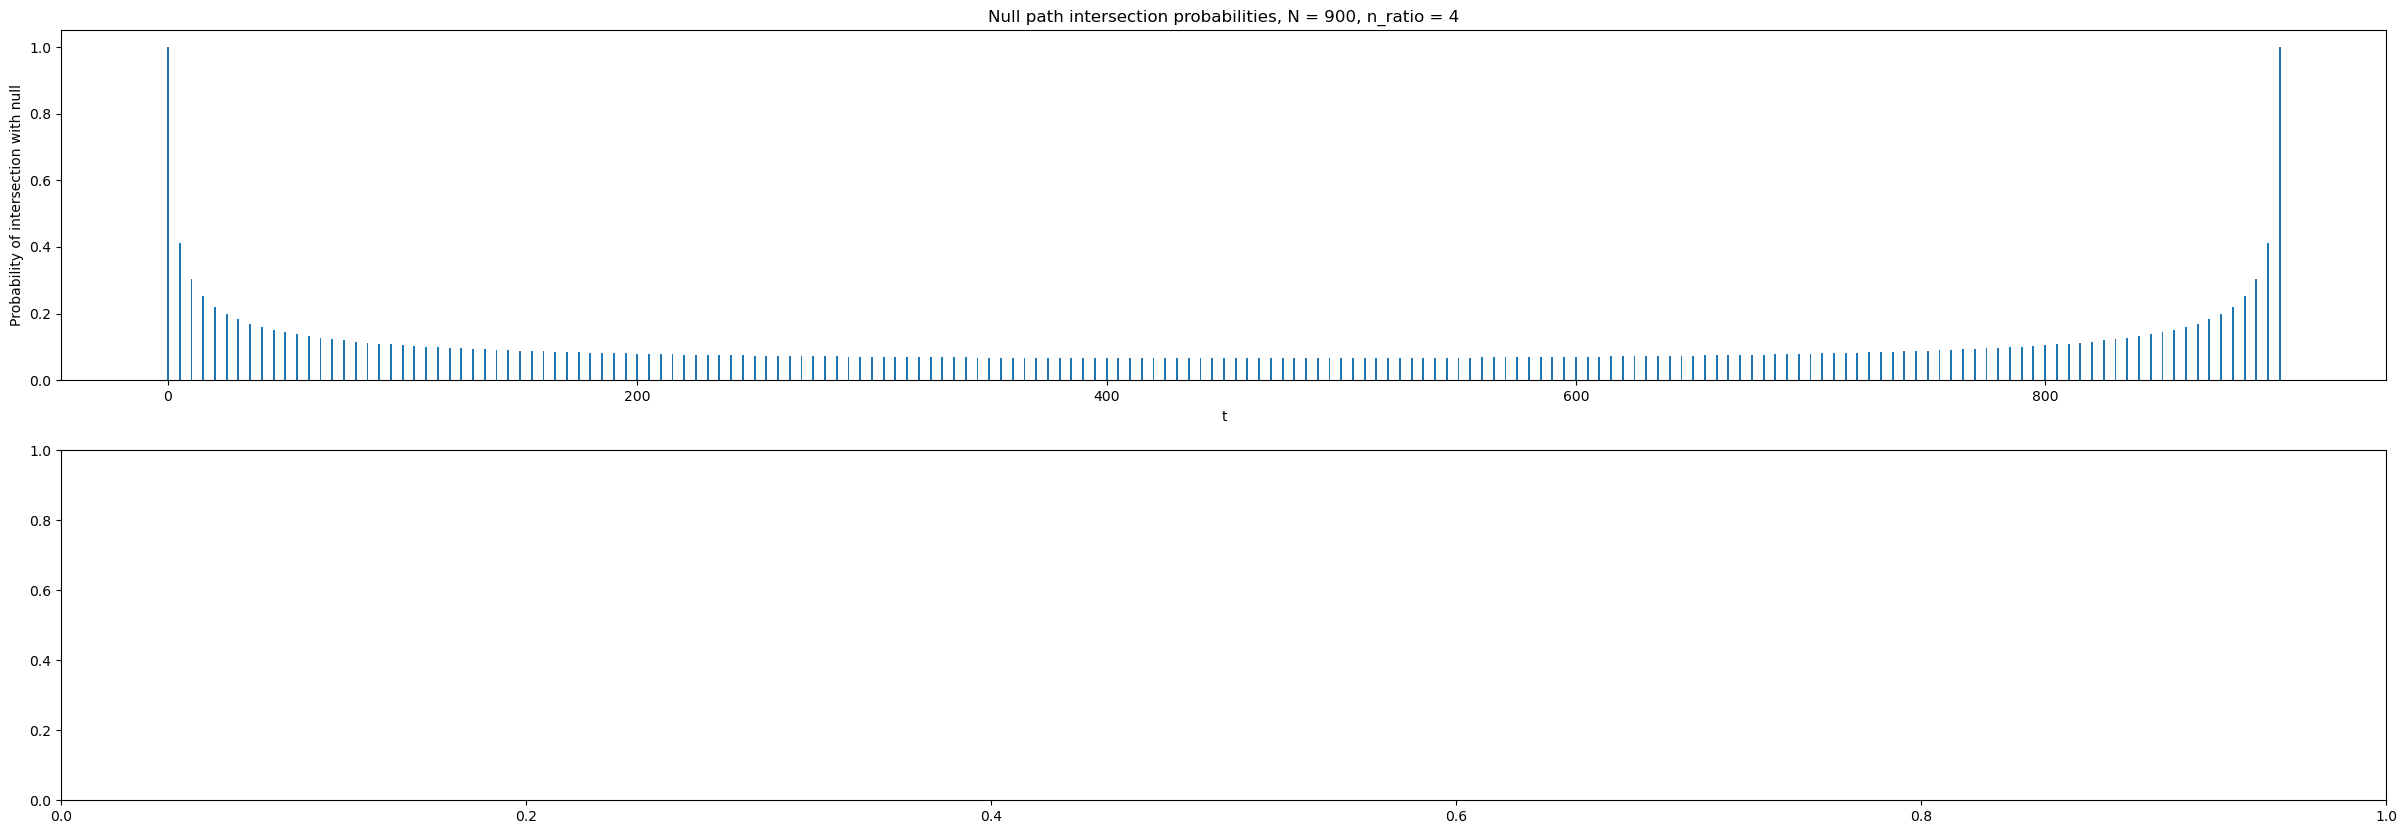

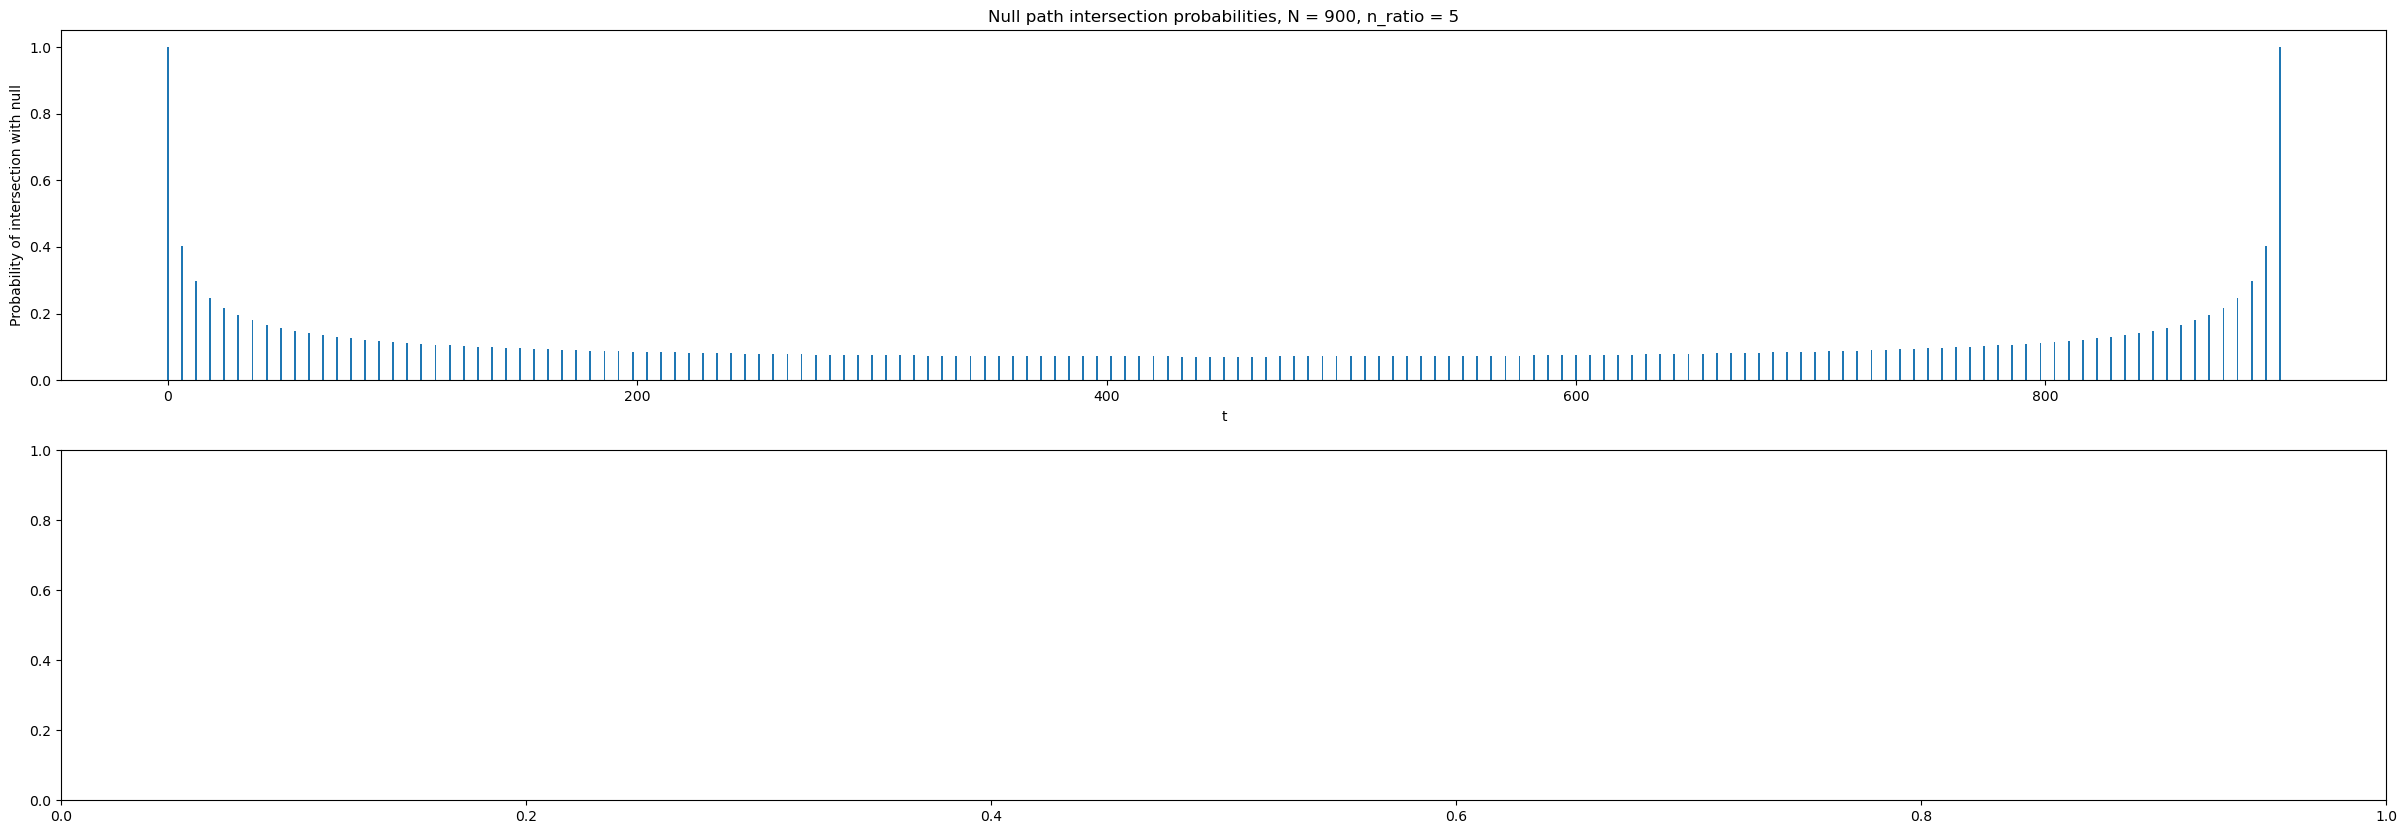

In [20]:
for i in range(len(N1)):
    for j in range(len(n_ratios)):
        N = N1[i]
        n_ratio = n_ratios[j]
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        x = np.arange(N+1)
        axs[0].bar(x,prob_array[i][j])
        axs[0].set_title(f"Null path intersection probabilities, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("Probability of intersection with null")
        
        # axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        # # axs[1].bar(np.arange(len(inter_number)), inter_number)

        # axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        # axs[1].set_xlabel("number of intersections with null")
        # axs[1].set_ylabel("density")
        plt.show()

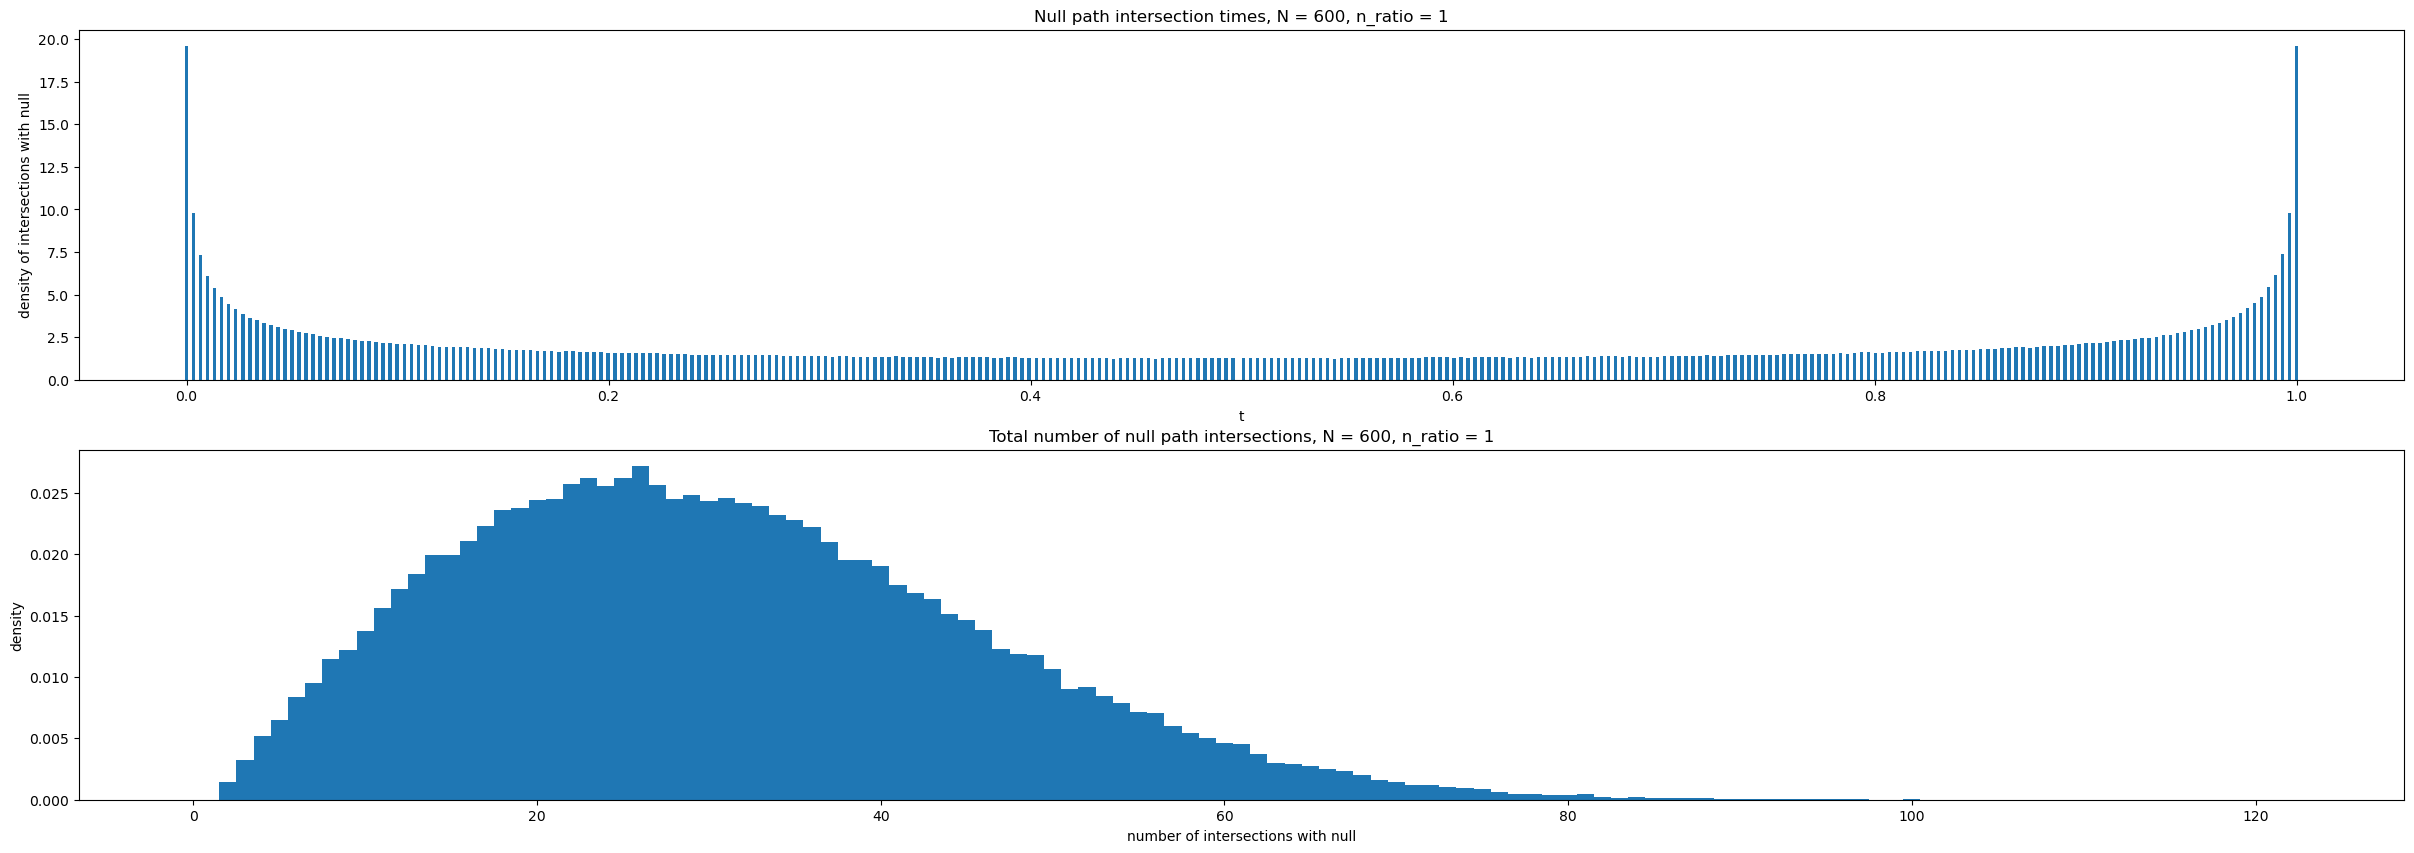

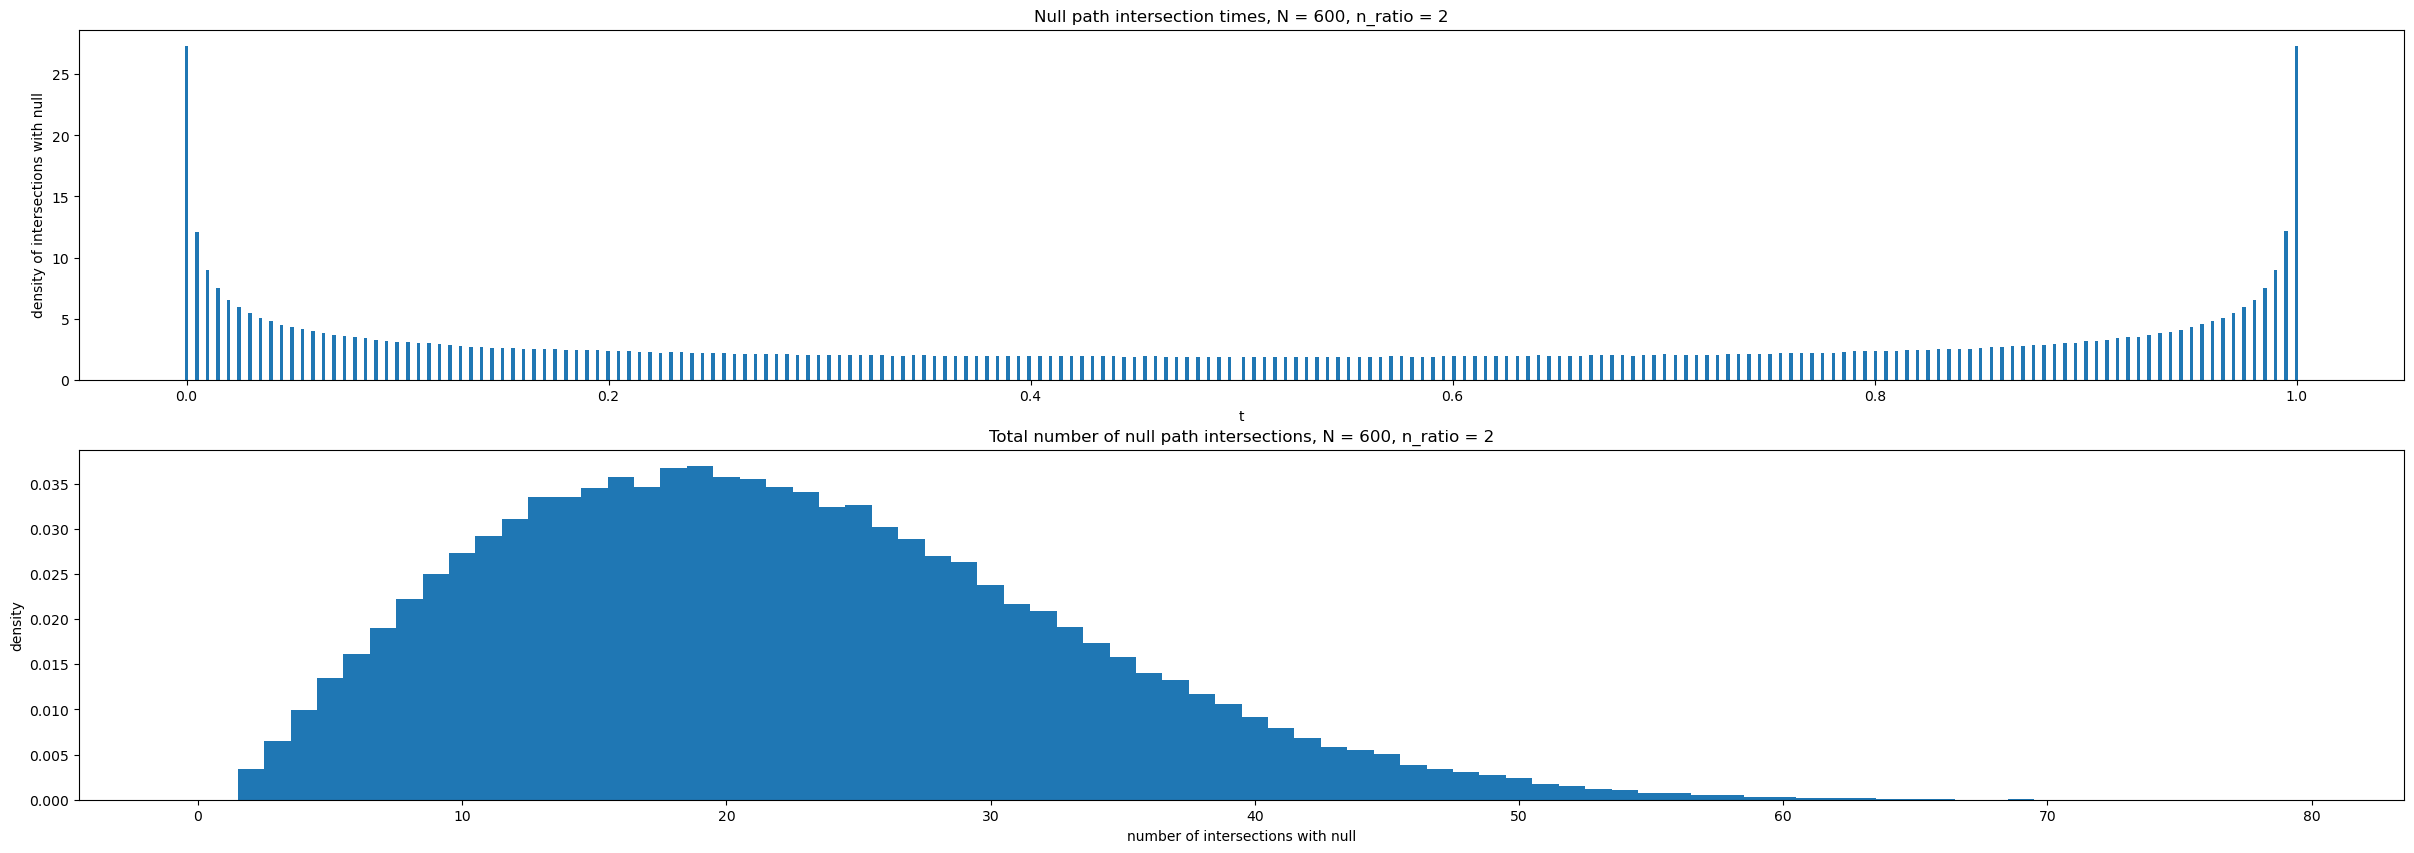

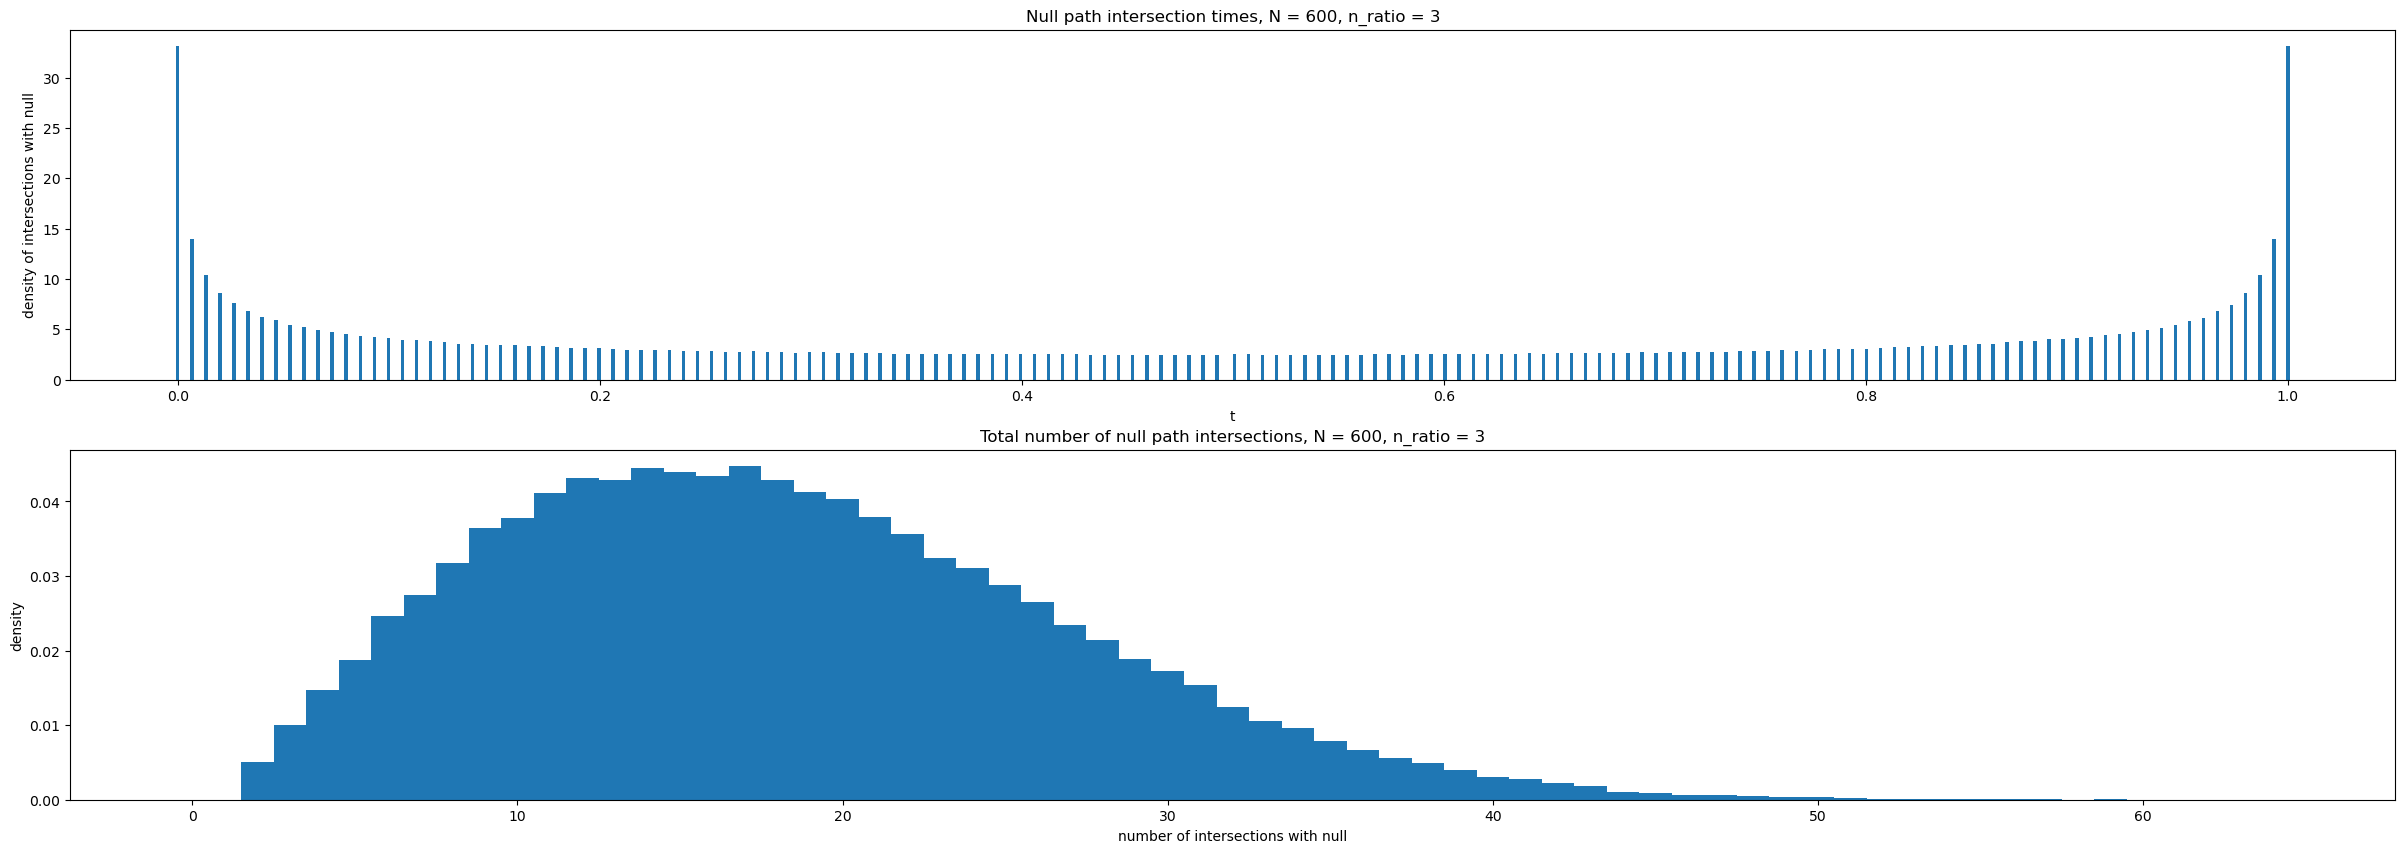

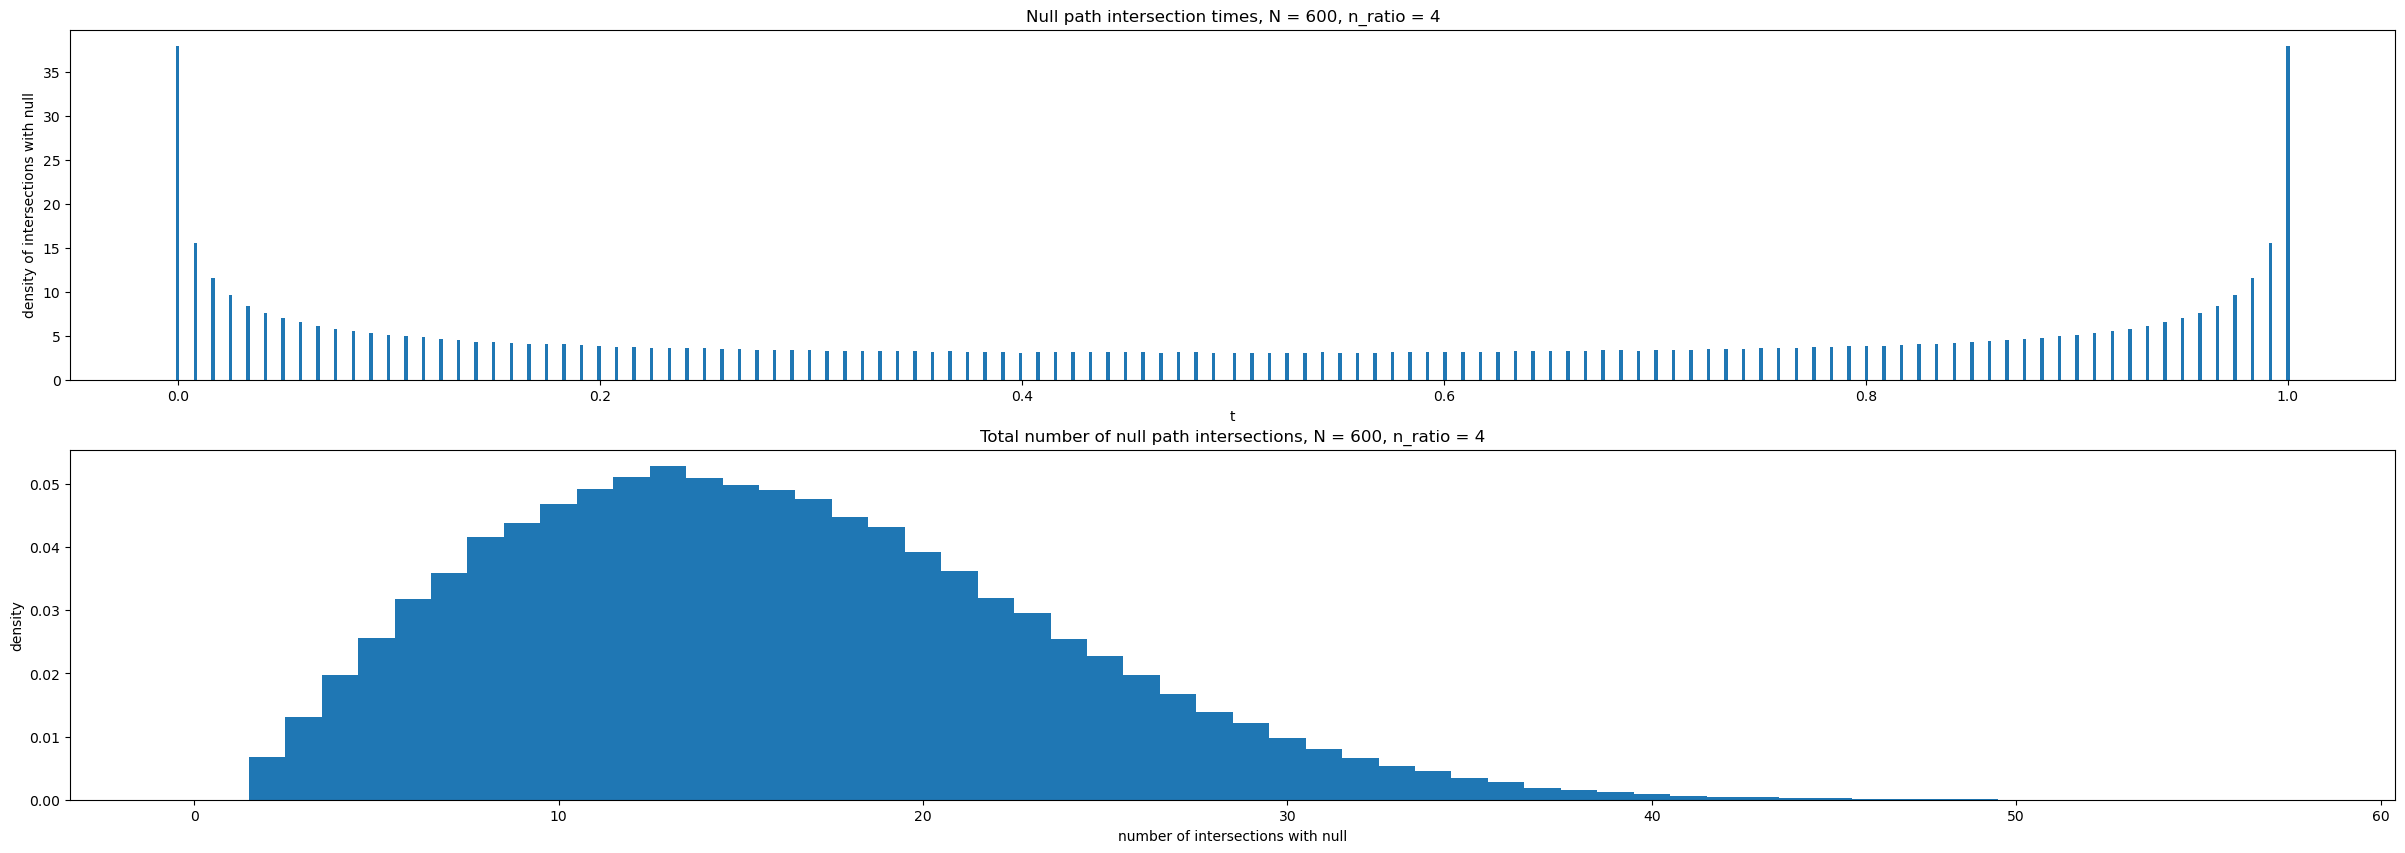

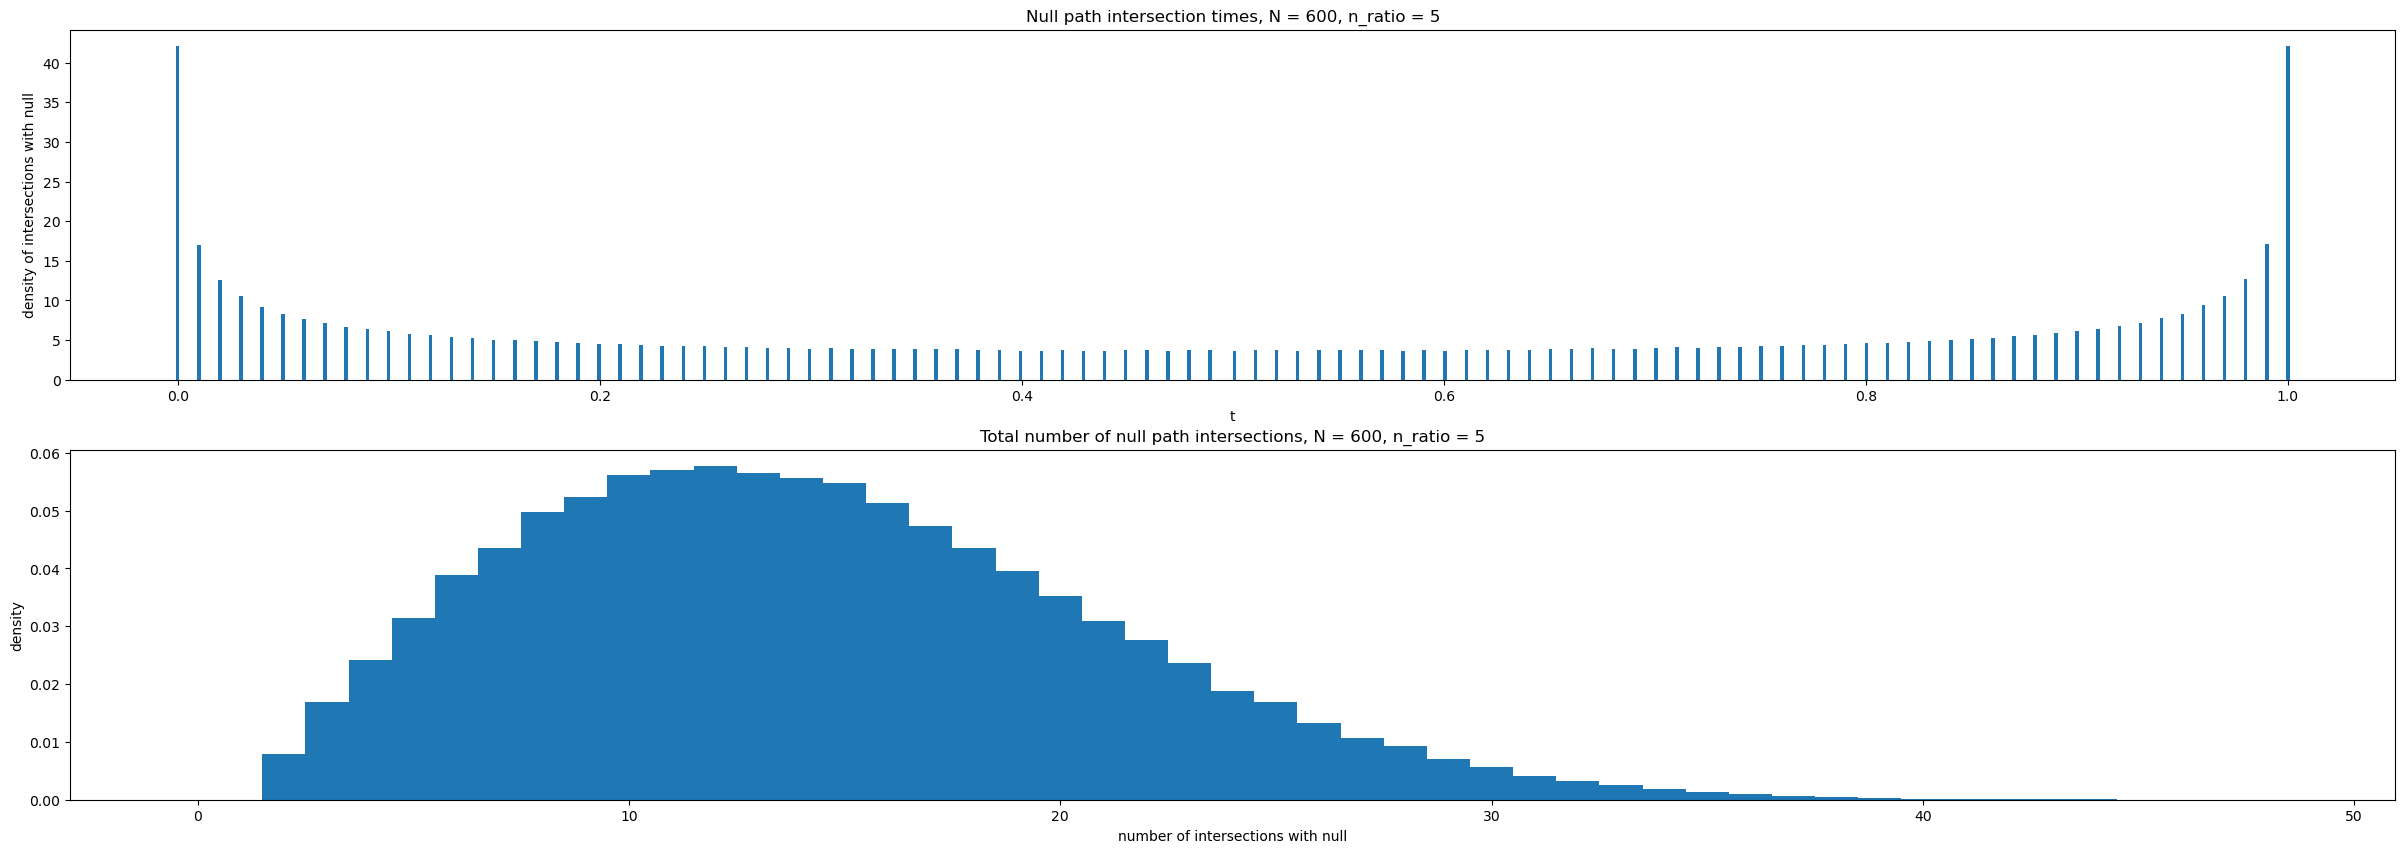

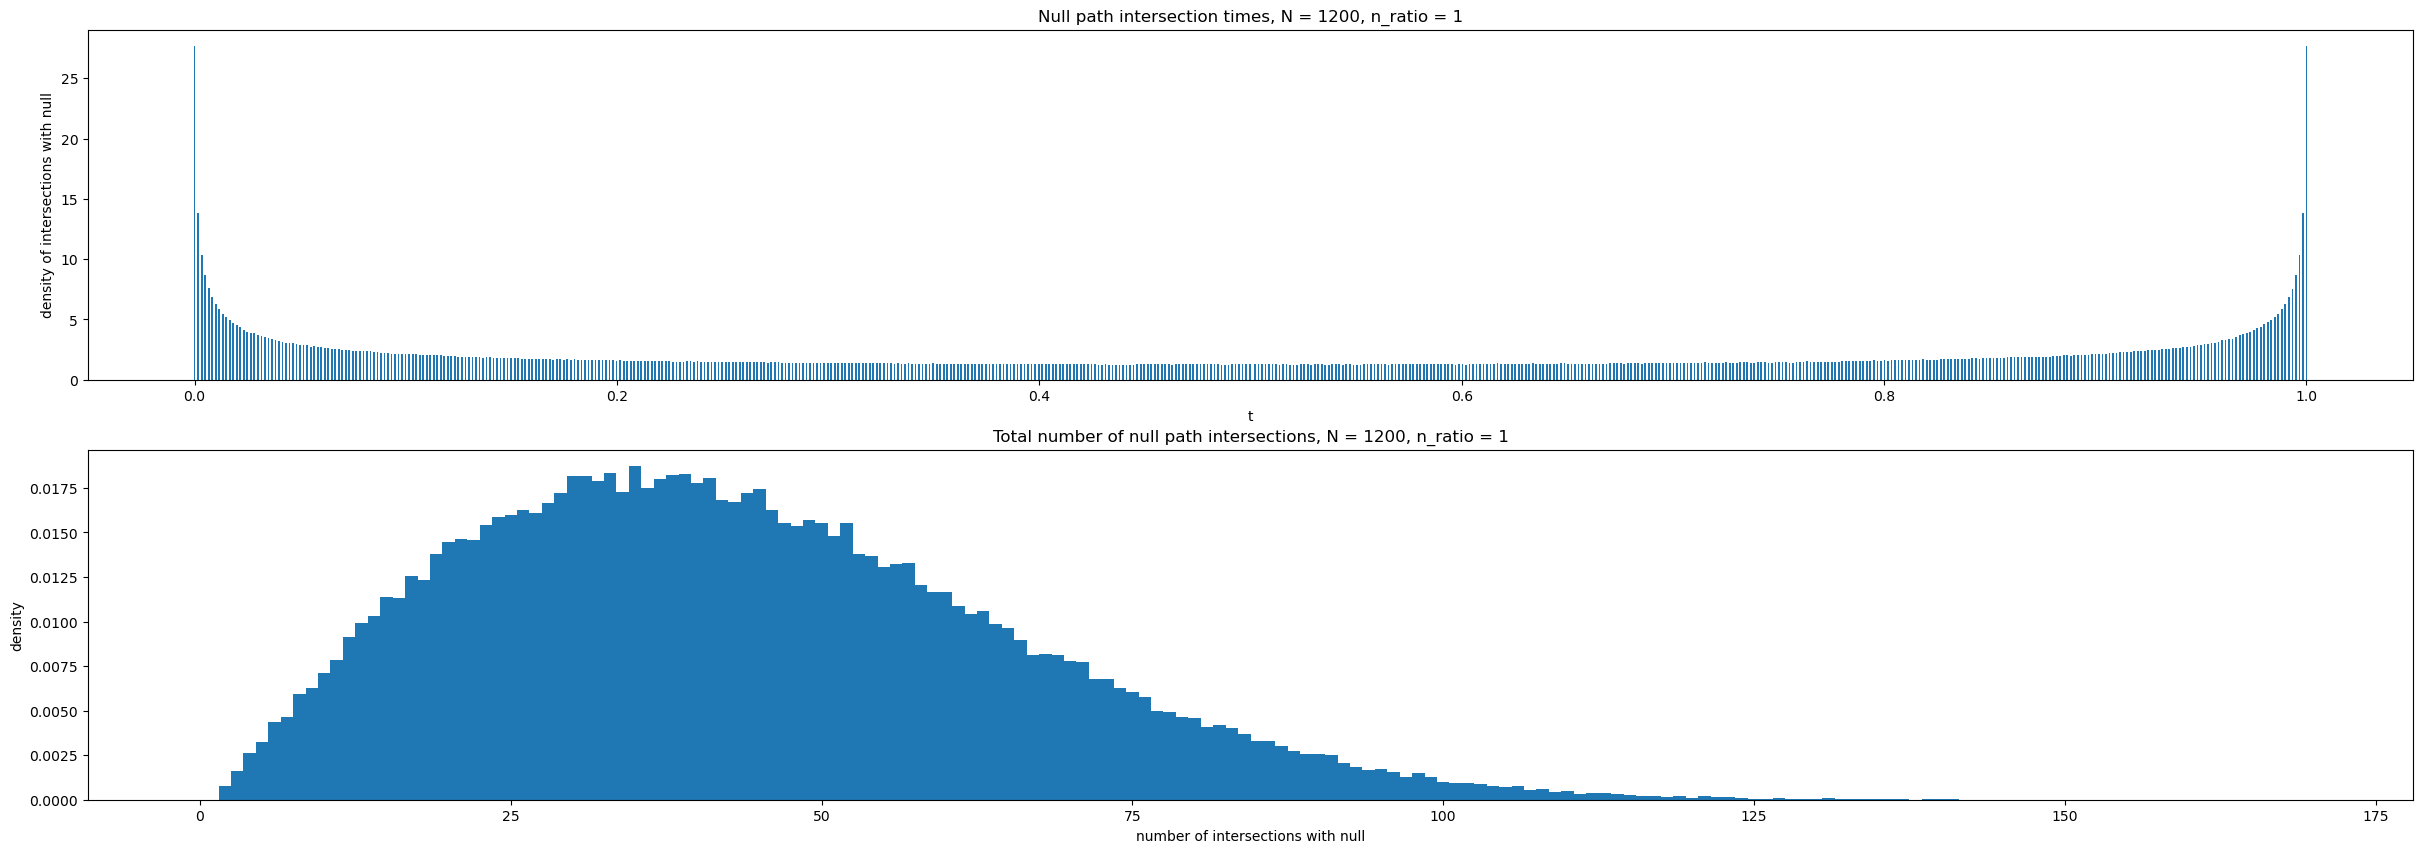

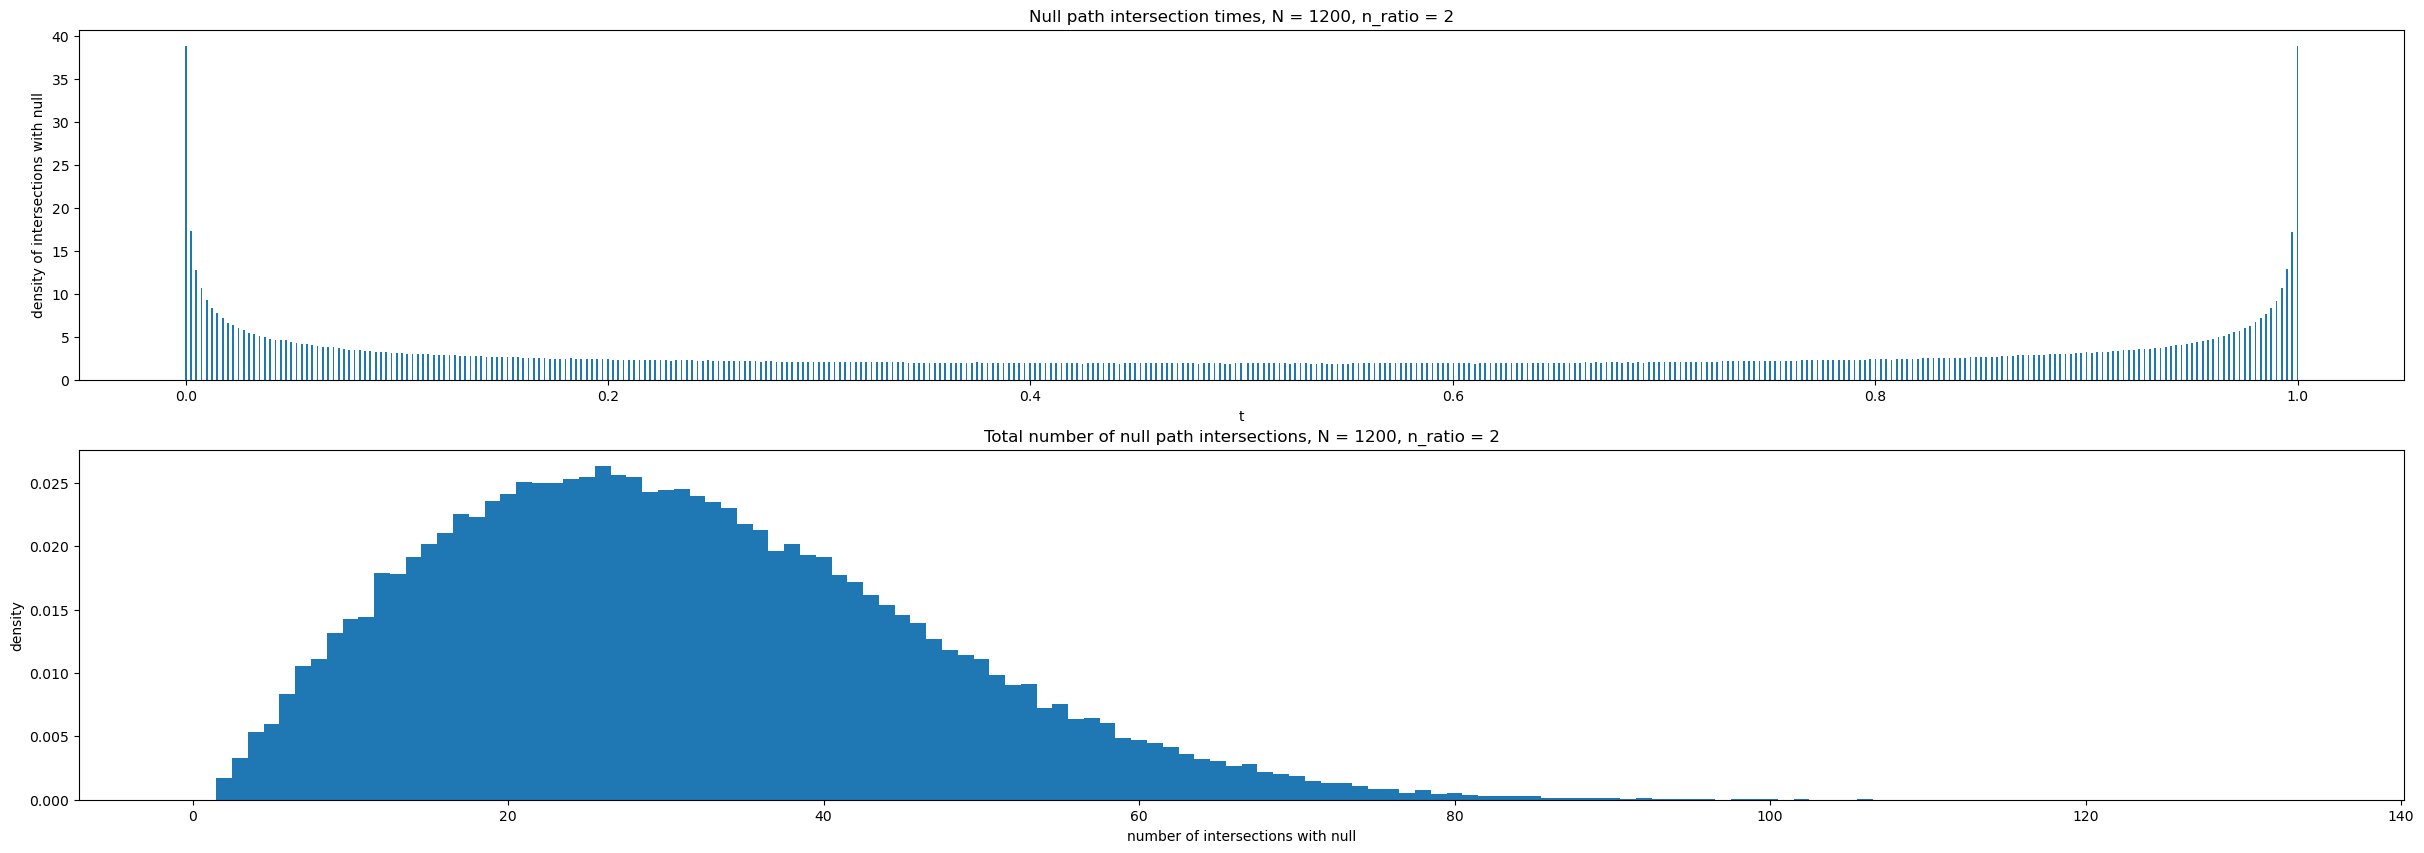

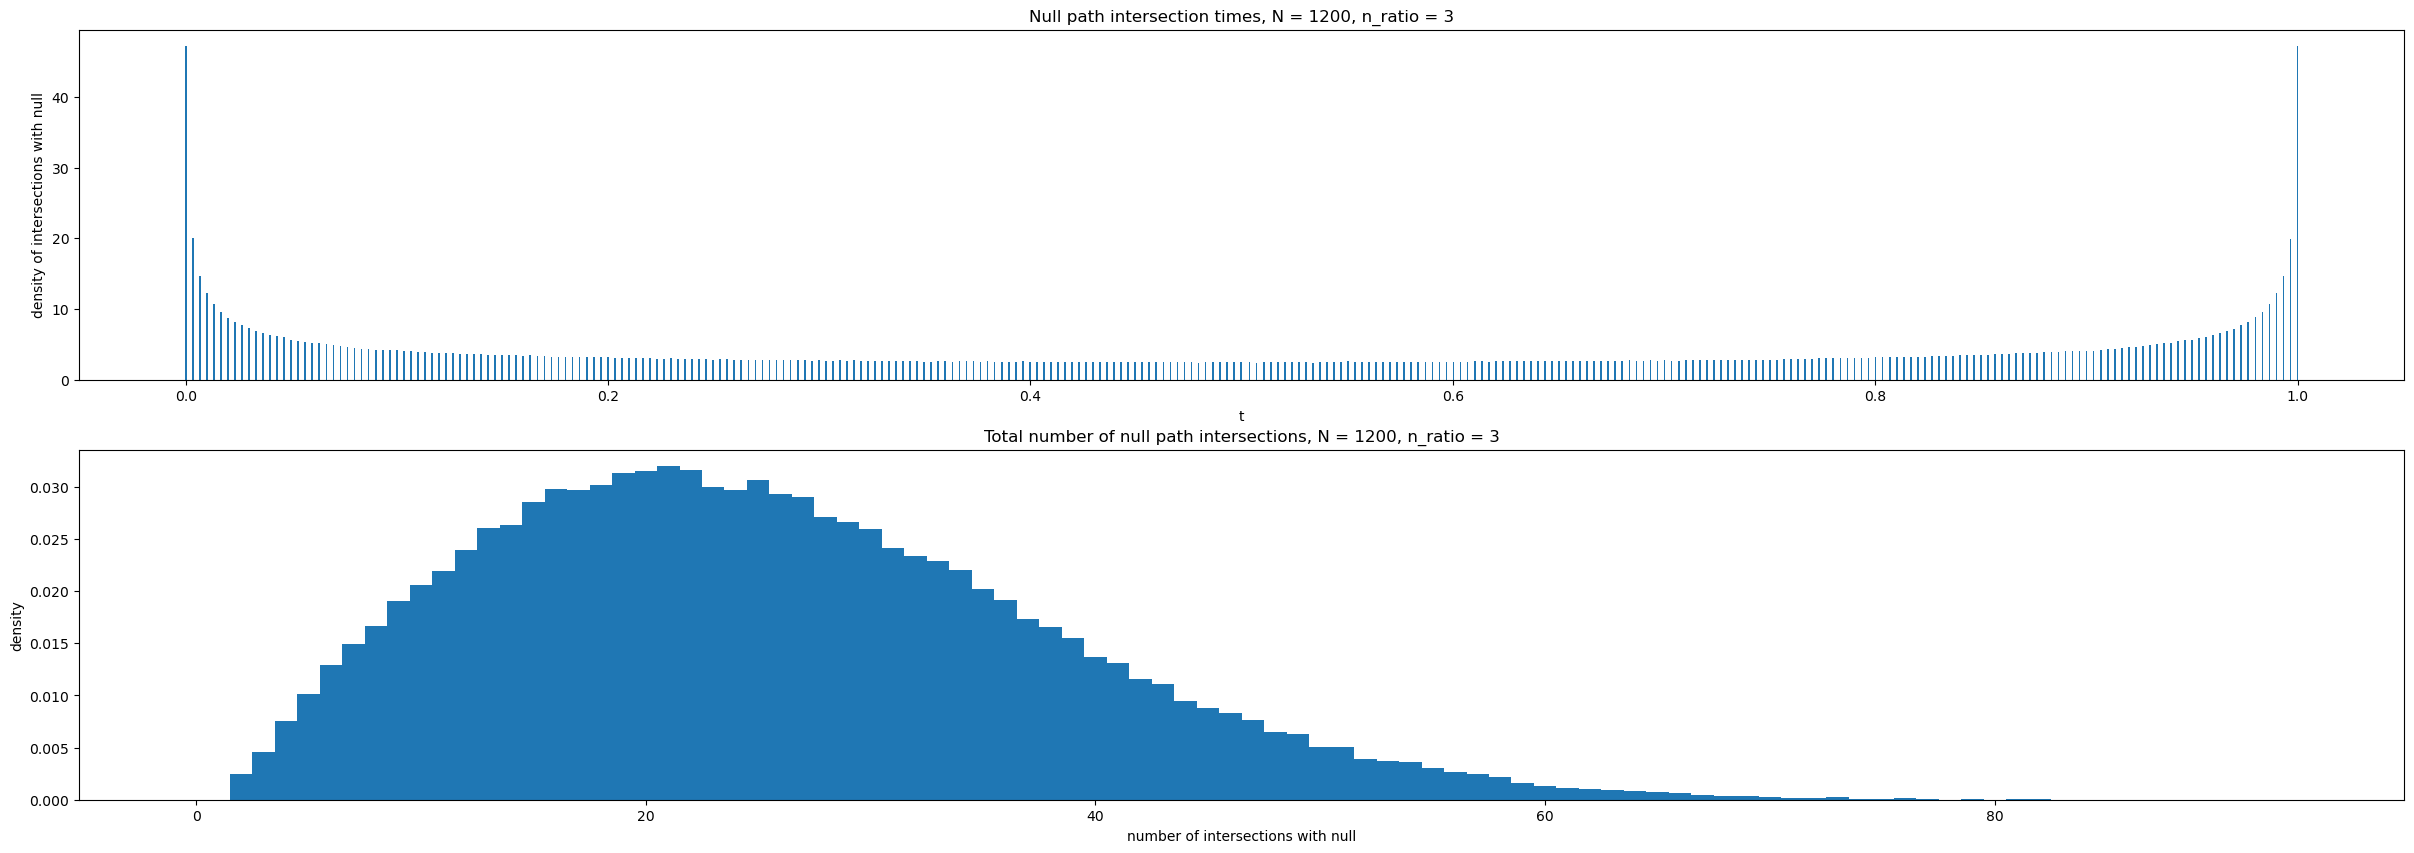

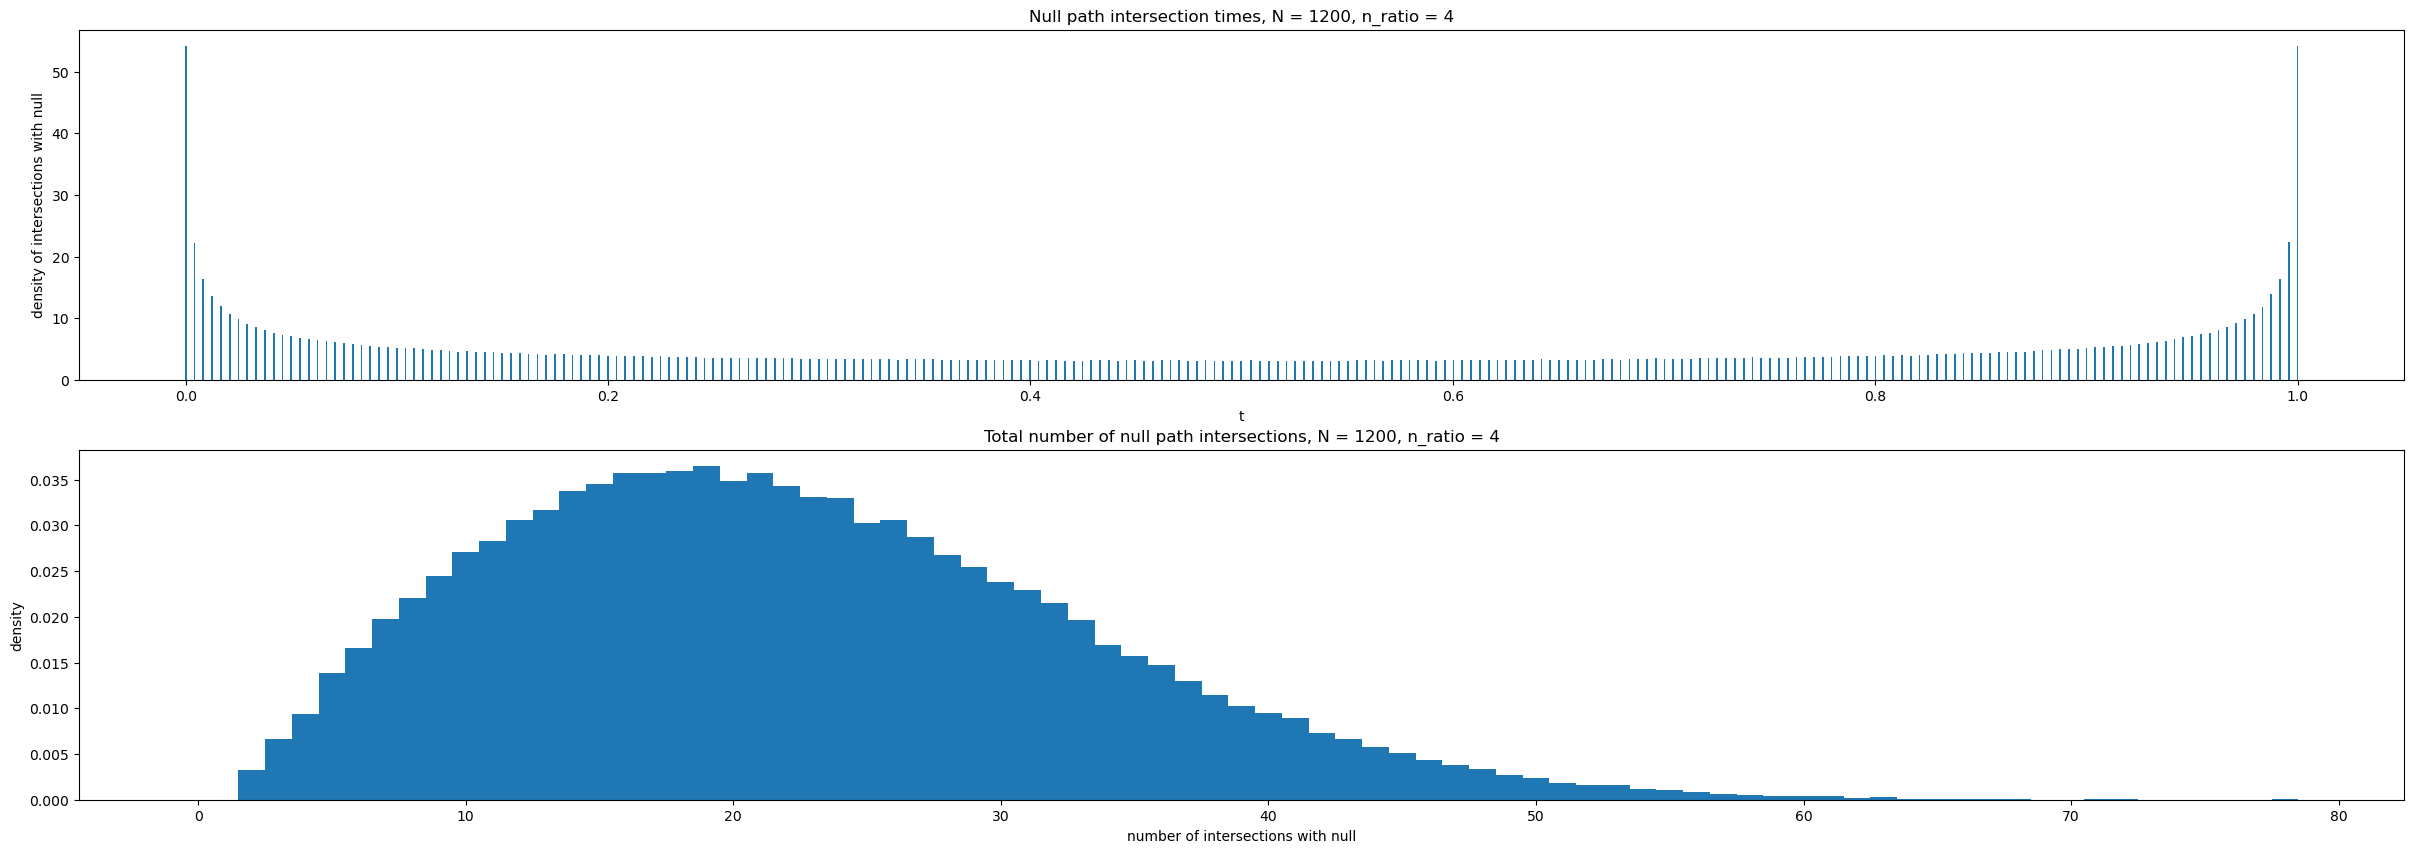

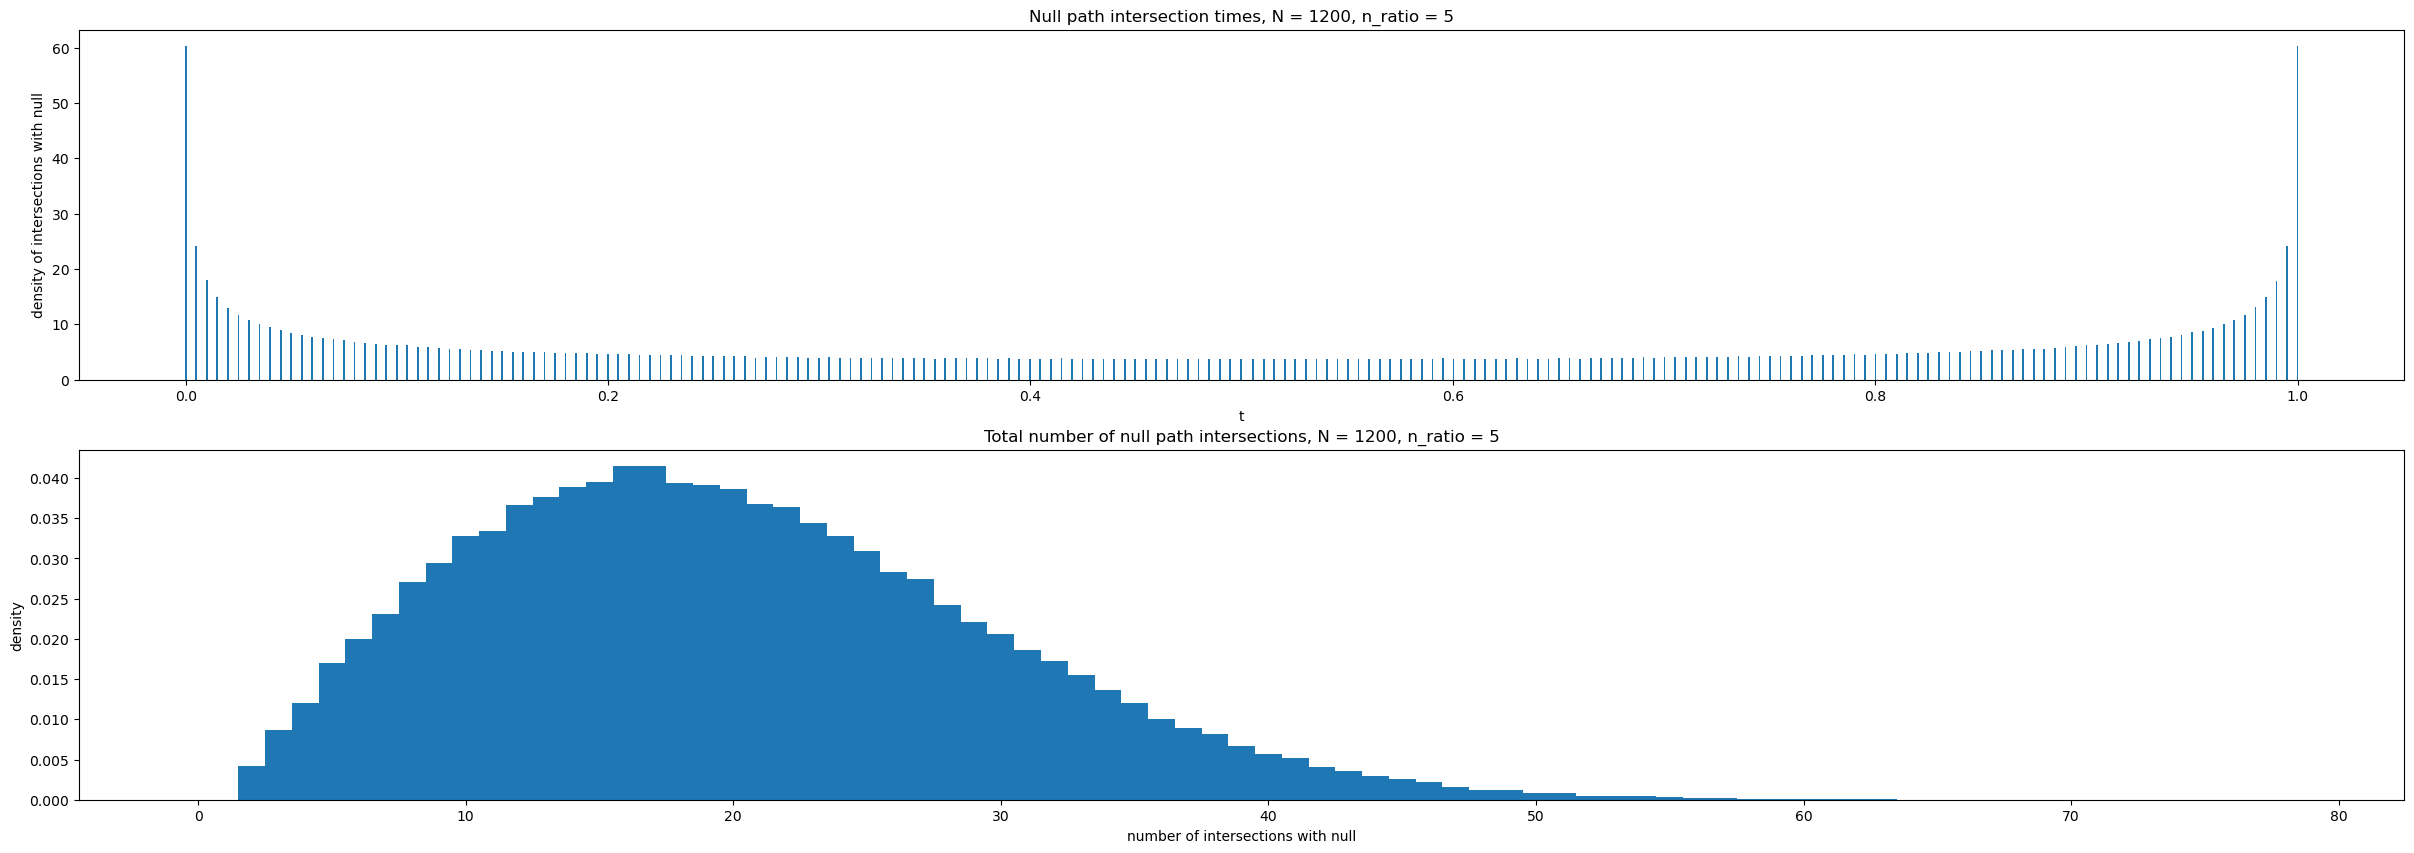

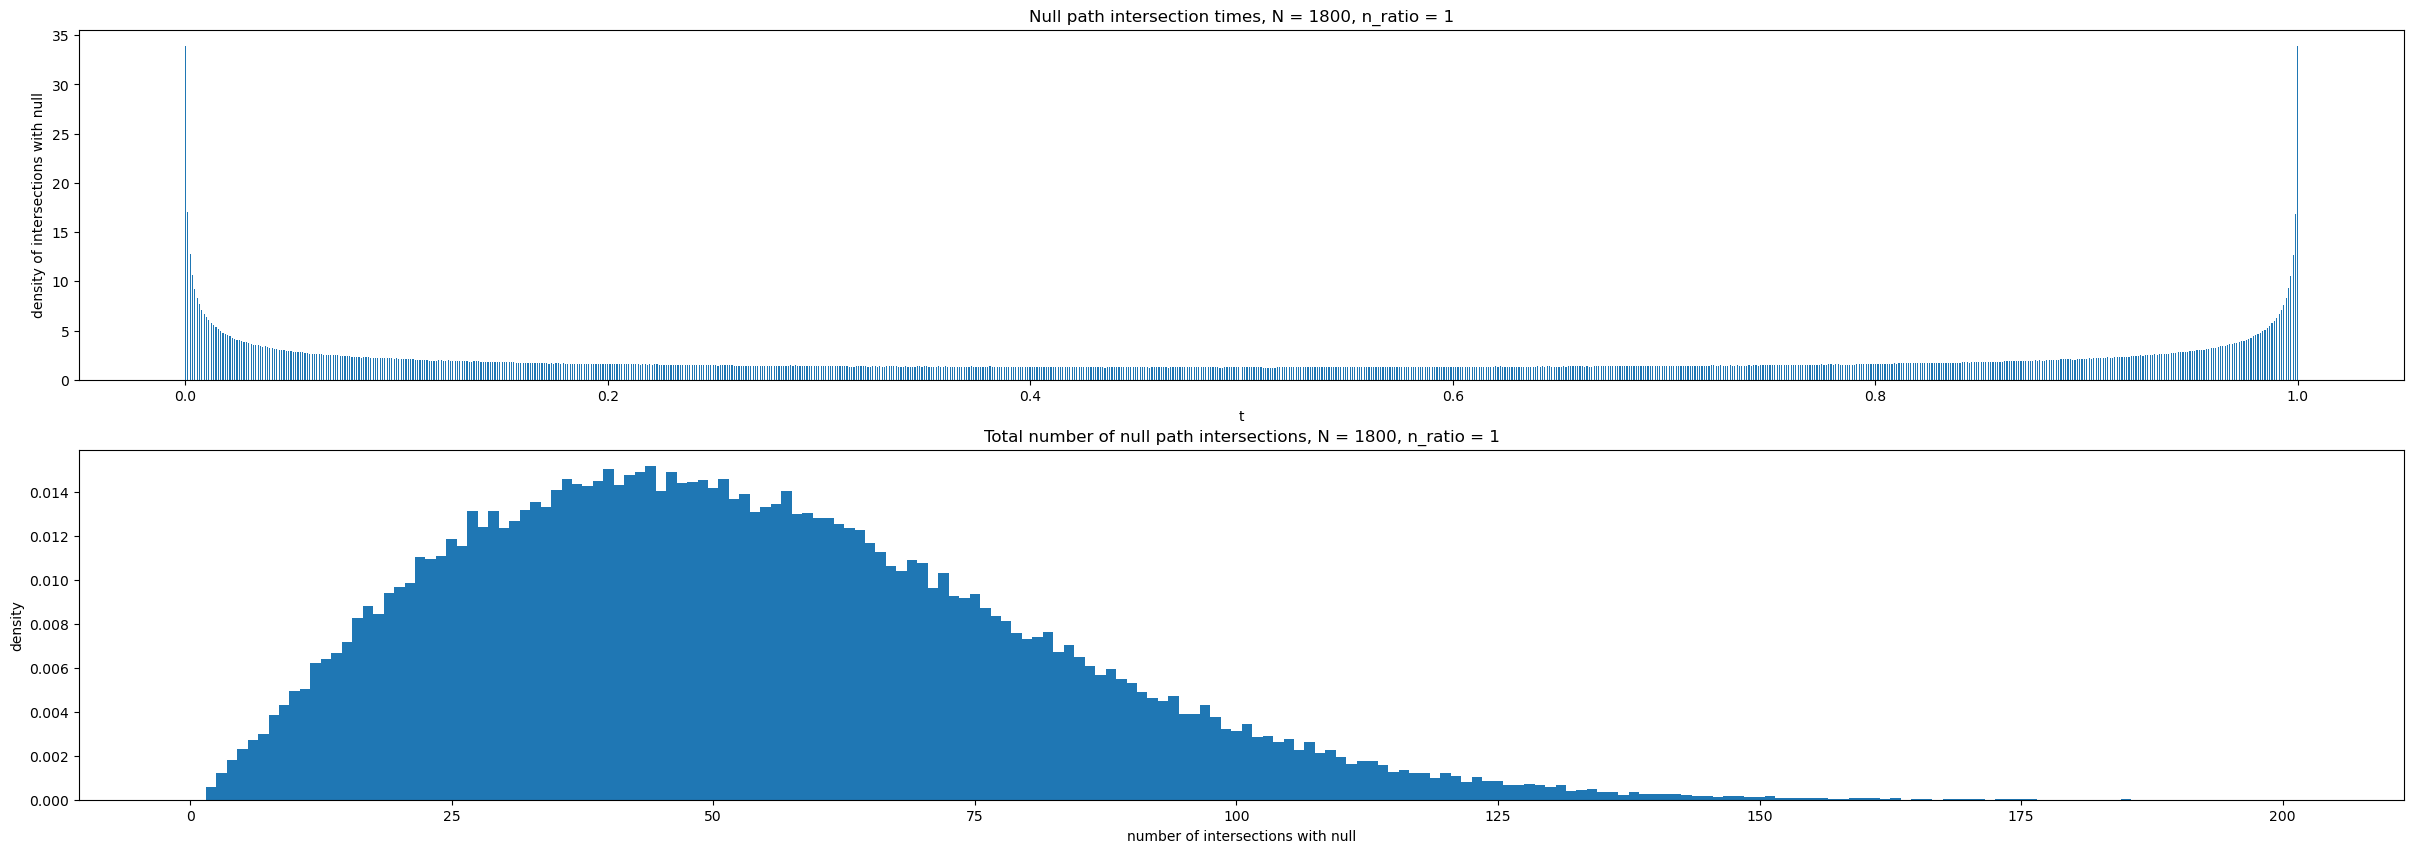

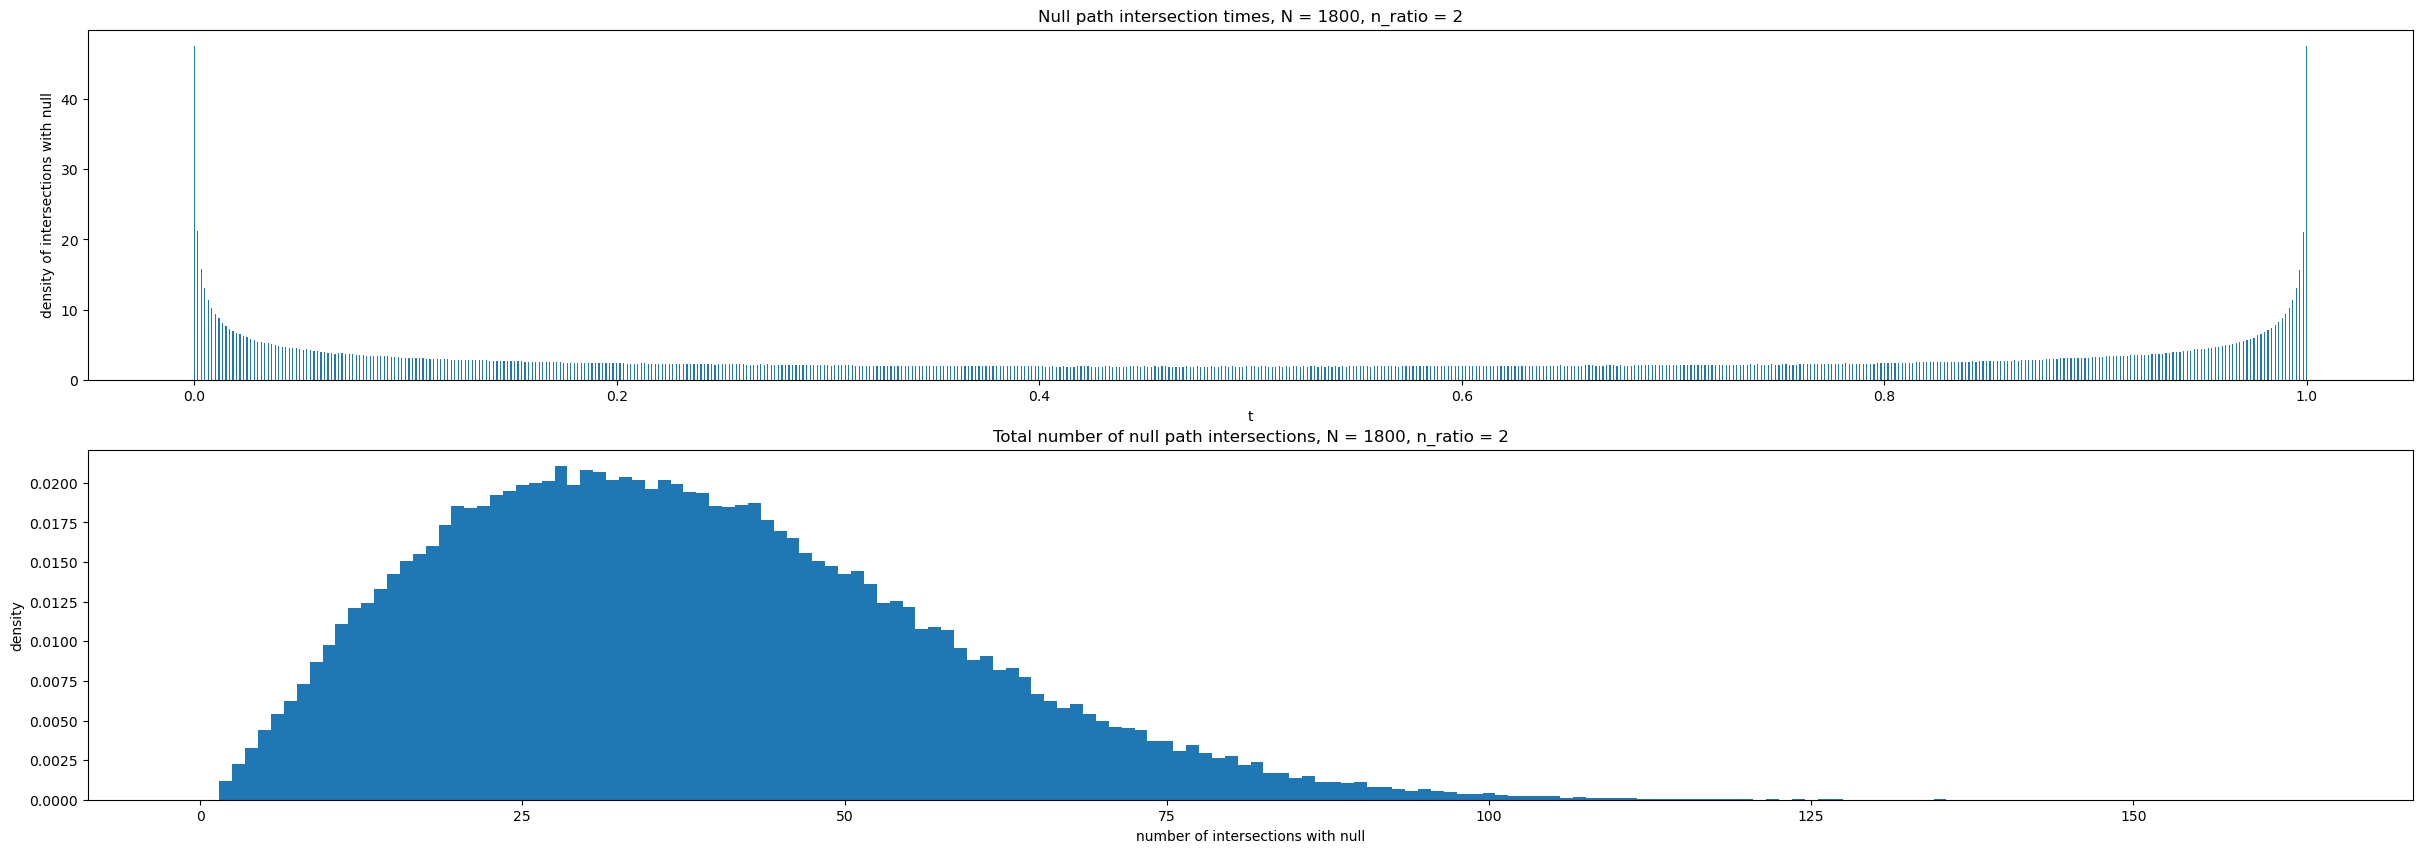

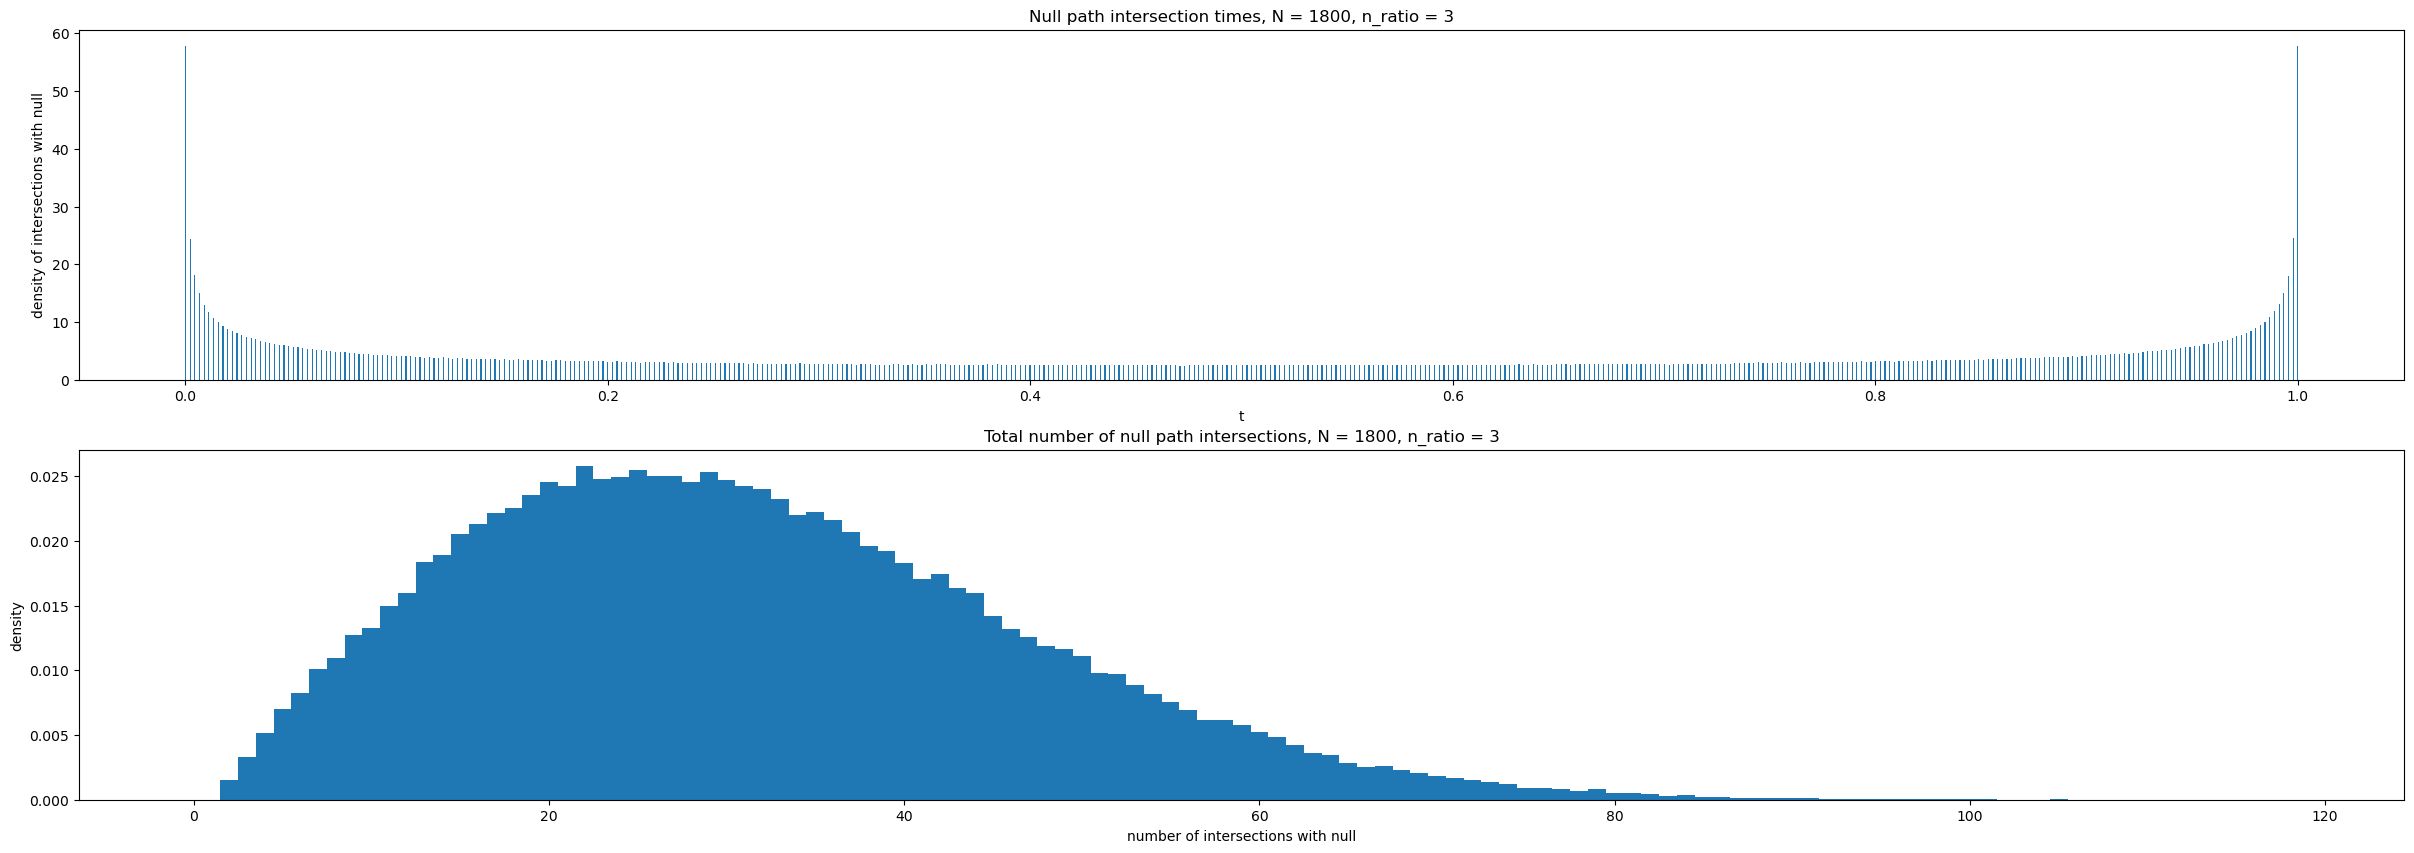

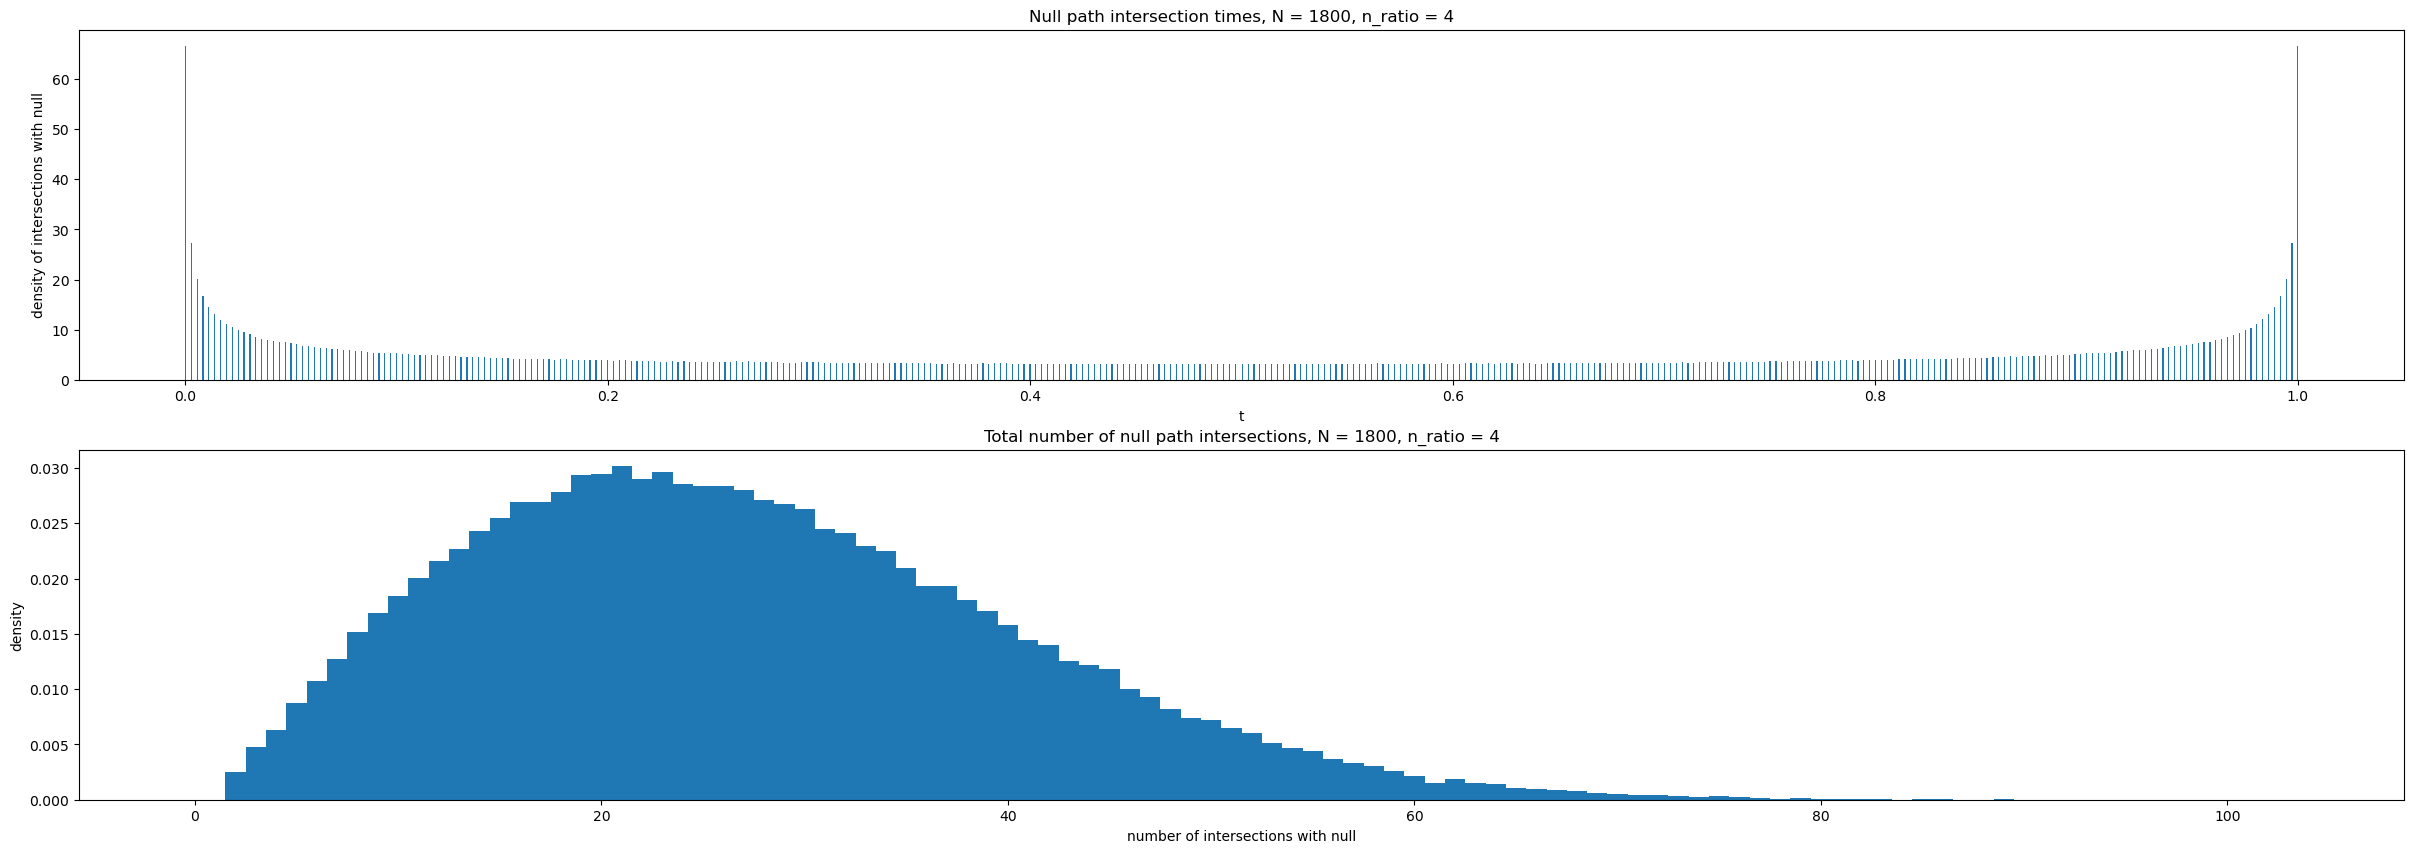

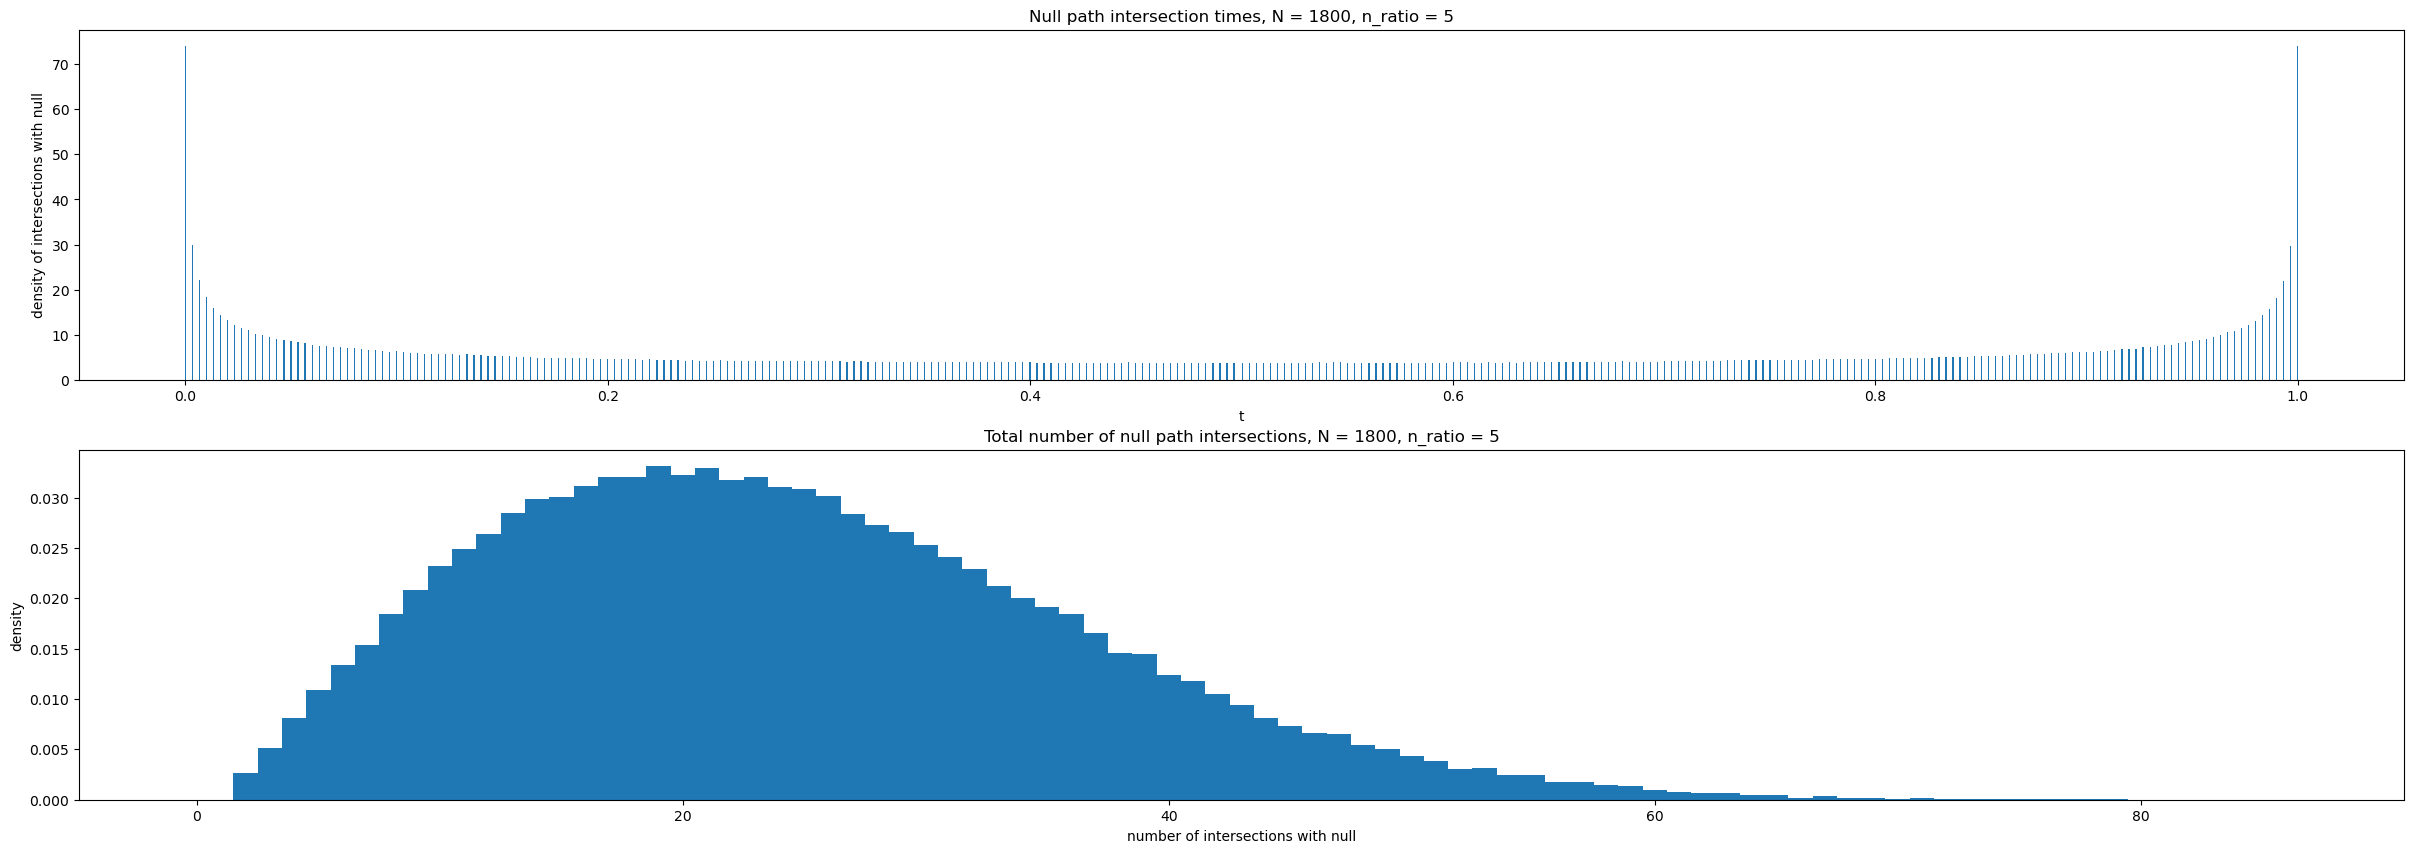

In [13]:
for i in range(len(N1)):
    for j in range(len(n_ratios)):
        inters, inter_number = runs[i][j]
        N = N1[i]
        n_ratio = n_ratios[j]
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        axs[0].hist(inters, bins = N+2, density = True, range = [- 0.5 / N, 1 + 0.5/N])
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        # axs[1].bar(np.arange(len(inter_number)), inter_number)

        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        plt.show()

mean of mean recurrence times = 0.057686012629266946


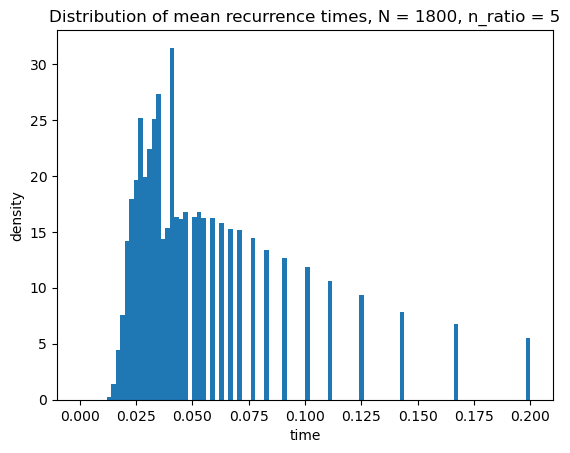

In [14]:
mean_recurrences = 1 / inter_number
print(f'mean of mean recurrence times = {np.mean(mean_recurrences)}')

fig, ax = plt.subplots()
ax.hist(mean_recurrences, bins = 100, density = True, range = [0,0.2])
ax.set_title(f"Distribution of mean recurrence times, N = {N}, n_ratio = {n_ratio}")
ax.set_xlabel("time")
ax.set_ylabel("density")
plt.show()

In [15]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def parametric(n_ratio, N, ax, c = None):

    x = gillespie(n_ratio, N).get()[0]
    seq = np.array(x[1:] < x[:-1]) * 1
    parametric = [[0],[0]]
    for i in seq:
        parametric[i].append(parametric[i][-1] + 1)
        parametric[i-1].append(parametric[i-1][-1])
    parametric = np.array(parametric) / N
    
    ax.plot(parametric[0], parametric[1], label = f' +/- ratio={n_ratio}', c=c)
    ax.set_title("Path in parametric axes")
    ax.set_xlabel("x+")
    ax.set_ylabel("x-")
    return parametric

def parametric_shifted(n_ratio, N, path, ax):
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])

    # shift by null path
    t = np.linspace(0, 1, N+1)
    shift_plus = Ns[0] / N * t
    shift_minus = Ns[1] / N * t
    x = path[0] - shift_plus
    y = path[1] - shift_minus


    points = np.array([x, y]).transpose().reshape(-1, 1, 2)
    # set up a list of segments
    # segs = np.concatenate([points[:-1],points[1:]],axis=1)
    segs = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('viridis'))

    lc.set_array(t)  # color the segments by our parameter

    # plot the collection

    ax.add_collection(lc)  # add the collection to the plot

    a = list(ax.get_xlim())
    b = list(ax.get_ylim())
    a = [np.min([a[0], x.min()]), np.max([a[1], x.max()])]
    b = [np.min([b[0], y.min()]), np.max([b[1], y.max()])]

    ax.set_xlim(a)
    ax.set_ylim(b)

    ax.set_title("Parametric path shifted by null path")
    ax.set_xlabel("y+")
    ax.set_ylabel("y-")

    return np.array([x, y])

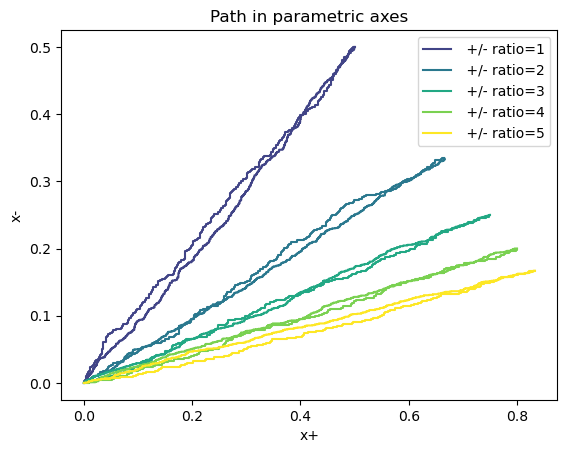

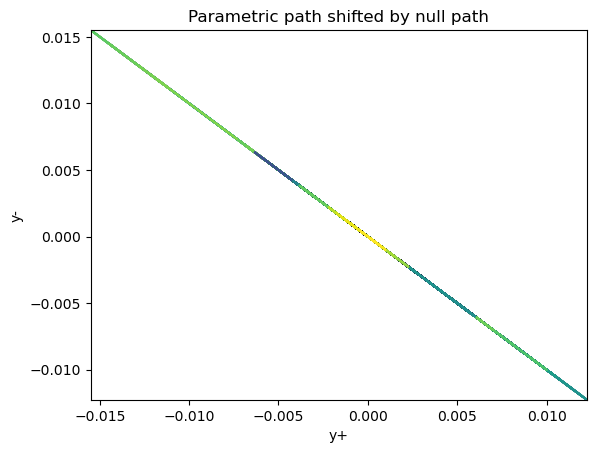

In [16]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax2.set_xlim(-0.001,0.001)
ax2.set_ylim(-0.001,0.001)

paths = []
shifted = []
n_ratios = [i for i in range(1,6)]
N1 = [1000 * i for i in range(1,3)]

c = plt.cm.viridis(n_ratios / np.max(n_ratios))

for N in N1:
    paths.append([])
    shifted.append([])
    for j in range(len(n_ratios)):
        paths[-1].append(parametric(n_ratios[j], N, ax1, c=c[j]))
        shifted[-1].append(parametric_shifted(n_ratios[j], N, paths[-1][-1], ax2))
legend_without_duplicate_labels(ax1)
plt.show()

(5, 1001)


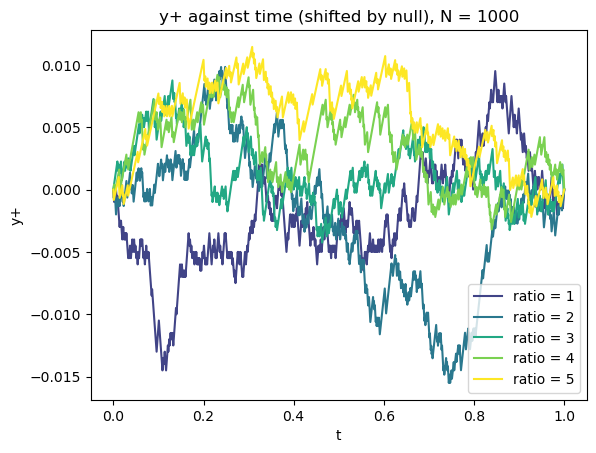

(5, 2001)


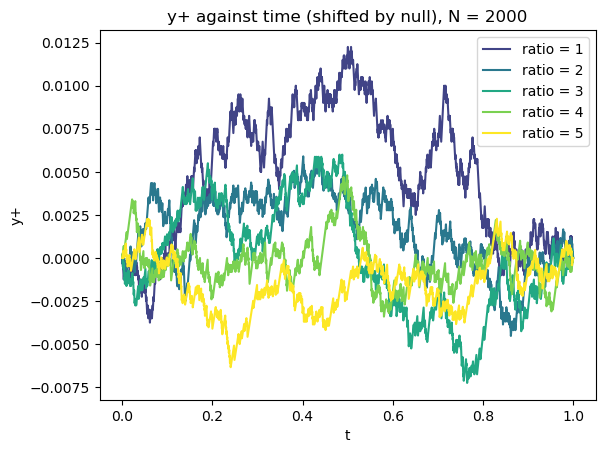

In [17]:
for i in range(len(N1)):
    shifted_plus = np.transpose(shifted[i], [1,0,2])[0]

    print(np.shape(shifted_plus))
    # print(np.shape(np.transpose(shifted[i])))
    t = np.linspace(0, 1, N1[i]+1)
    for j in range(len(n_ratios)):
        plt.plot(t, shifted_plus[j], label = f'ratio = {n_ratios[j]}', c = c[j])

    plt.xlabel("t")
    plt.ylabel("y+")
    plt.title(f"y+ against time (shifted by null), N = {N1[i]}")
    legend_without_duplicate_labels(plt.gca())
    plt.show()